## Imports

In [189]:
# !pip install tabulate

In [190]:
# !pip install xgboost

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from collections import Counter
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error


In [192]:
# pip install tabulate

In [193]:
market = pd.read_excel('market_updated.xlsx')
sales = pd.read_excel('sales_updated.xlsx')

In [194]:
market.head()

date  MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
0 2004-02-01       16.940704       16.940704      112.091273       83.458866   
1 2004-03-01       23.711852       23.711852      136.327976      106.168192   
2 2004-04-01       24.435235       24.435235      117.791806       92.007646   
3 2004-05-01       23.708115       23.708115      109.002541       85.696486   
4 2004-06-01       27.009138       27.009138      133.785737      106.641482   

   MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
0       82.623037       79.452532      124.289603       86.560493   
1      100.556582       97.012918      143.411662      106.344544   
2       89.653203       84.932358      129.083828       95.579673   
3       86.880571       82.372794      135.590391      100.087039   
4       99.010814       95.108740      136.424935      110.889719   

   MAB_ELE_PRO392  ...  PRO28250_org  PRO28276_org  PRO27840_org  \
0      109.334010  ...    118.274109     80.829010    117.723991   
1      140.884616  ...    148.121841    102.130104    119.220779   
2      105.853579  ...    125.482231     90.961426    117.441124   
3      101.864777  ...    116.649750     88.082901    117.899216   
4      120.332920  ...    143.248734    100.978699    119.499107   

   PRO271000_org  PRO27756_org  PRO27826_org  PRO27380_org  PRO27392_org  \
0            NaN     81.100000    120.706516    141.510864    106.161262   
1            NaN     76.690307    138.309550    152.880234    140.288741   
2            NaN     71.552403    115.557330    137.796875    106.271197   
3            NaN     66.414500    119.269534    143.860535    101.608710   
4            NaN     61.276596    128.849416    144.315308    116.655248   

   PRO27250_org  PRO27276_org  
0    102.077057     85.913200  
1    117.225685     97.670815  
2    105.335777     87.253983  
3     96.616508     84.675552  
4    118.458710     95.401802  

[5 rows x 48 columns]

In [195]:
sales.head()

DATE  Mapped_GCK  Counts   Sales_CPI_€
0 2018-10-01           1       3  3.577403e+07
1 2018-10-01           3       4  8.016661e+06
2 2018-10-01           4       3  3.941808e+05
3 2018-10-01           5       3  2.476570e+06
4 2018-10-01           6       3  3.659085e+05

In [196]:
sales.rename(columns={'DATE': 'Date'}, inplace=True)

### Handle missing sales for products

In [197]:
# check the first and the last value for 'sales'
print(sales['Date'].min())
print(sales['Date'].max())

2018-10-01 00:00:00
2022-04-01 00:00:00


In [198]:
# Define the complete date range
complete_date_range = pd.date_range(start='2018-10-01', end='2022-04-01', freq='MS')

# Iterate over each product
for product in sales['Mapped_GCK'].unique():
    print(f"\nProduct: {product}")
    
    # Filter the DataFrame for the specific product
    product_sales = sales[sales['Mapped_GCK'] == product]
    
    # Get the unique dates present in the filtered DataFrame
    unique_dates = pd.to_datetime(product_sales['Date']).dt.to_period('M').unique().to_timestamp()
    
    # Identify missing dates
    missing_dates = complete_date_range[~complete_date_range.isin(unique_dates)]
    
    if len(missing_dates) == 0:
        print("All dates present.")
    else:
        print("Missing dates:")
        print(missing_dates)


Product: 1
All dates present.

Product: 3
All dates present.

Product: 4
All dates present.

Product: 5
All dates present.

Product: 6
All dates present.

Product: 8
All dates present.

Product: 9
Missing dates:
DatetimeIndex(['2018-12-01'], dtype='datetime64[ns]', freq='MS')

Product: 11
All dates present.

Product: 12
All dates present.

Product: 13
All dates present.

Product: 14
Missing dates:
DatetimeIndex(['2018-12-01', '2019-04-01', '2019-12-01', '2021-08-01'], dtype='datetime64[ns]', freq=None)

Product: 16
All dates present.

Product: 20
Missing dates:
DatetimeIndex(['2019-12-01', '2020-02-01', '2021-01-01', '2021-09-01',
               '2022-01-01'],
              dtype='datetime64[ns]', freq=None)

Product: 36
All dates present.


In [199]:
new_rows = []

unique_products = sales['Mapped_GCK'].unique()

# Iterate over each product
for product in unique_products:
    # Filter sales data for the current product
    product_sales = sales[sales['Mapped_GCK'] == product]
    
    # Get the unique dates for the current product
    unique_dates = product_sales['Date'].unique()
    
    # Check for missing dates
    all_dates = pd.date_range(start='2018-10-01', end='2022-04-01', freq='MS')
    missing_dates = all_dates[~all_dates.isin(unique_dates)]
    
    # If there are missing dates, add rows with zero sales
    if len(missing_dates) > 0:
        for date in missing_dates:
            new_rows.append({'Date': date, 'Mapped_GCK': product, 'Counts': 0, 'Sales_CPI_€': np.nan})

# Append the new rows to the DataFrame
sales = pd.concat([sales, pd.DataFrame(new_rows)], ignore_index=True)

# Sort the DataFrame by 'Date'
sales = sales.sort_values('Date', ascending=True)

In [200]:
sales[sales['Date'] == '2022-01-01'].head()

Date  Mapped_GCK  Counts   Sales_CPI_€
549 2022-01-01          36       2  6.327138e+03
548 2022-01-01          16       7  9.575503e+04
601 2022-01-01          20       0           NaN
546 2022-01-01          13       5  3.994740e+04
544 2022-01-01          11       5  1.109419e+06

In [201]:
# List of unique products
unique_products = sales['Mapped_GCK'].unique()

# Iterate over each product
for product in unique_products:
    # Filter sales data for the current product
    product_sales = sales[sales['Mapped_GCK'] == product]
    
    # Interpolate Sales_CPI_€ values for the current product
    product_sales['Sales_CPI_€'] = product_sales['Sales_CPI_€'].interpolate(method='linear', limit_direction='both')
    
    # Update the interpolated values in the original DataFrame
    sales.loc[sales['Mapped_GCK'] == product, 'Sales_CPI_€'] = product_sales['Sales_CPI_€']



C:\Users\User\AppData\Local\Temp\ipykernel_18700\580079218.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_sales['Sales_CPI_€'] = product_sales['Sales_CPI_€'].interpolate(method='linear', limit_direction='both')


In [202]:
# check for missing data in 'sales' 
sales.isnull().sum()

Date           0
Mapped_GCK     0
Counts         0
Sales_CPI_€    0
dtype: int64

### Aggregating by product and date:

In [203]:
sales['Mapped_GCK'].unique()
# the sales dataset considers 14 different product groups

array([ 1, 36, 20, 16, 13, 12, 11, 14,  8,  6,  5,  4,  3,  9],
      dtype=int64)

In [204]:
# Create an empty dictionary to store the merged DataFrames
merged_dfs = {}

# Iterate over unique Mapped_GCK values
for gck in sales['Mapped_GCK'].unique():
    # Filter sales DataFrame for the current Mapped_GCK
    sales_gck = sales[sales['Mapped_GCK'] == gck]
    
    # Merge the filtered sales DataFrame with the market DataFrame on 'Date'
    merged_df = sales_gck.merge(market, how='left', left_on='Date', right_on='date')
    
    # Store the merged DataFrame in the dictionary
    merged_dfs[gck] = merged_df

# Print the keys of the dictionary
print("Keys of the merged DataFrames dictionary:", list(merged_dfs.keys()))


Keys of the merged DataFrames dictionary: [1, 36, 20, 16, 13, 12, 11, 14, 8, 6, 5, 4, 3, 9]


In [205]:
# Columns to remove
columns_to_remove = ['Mapped_GCK', 'date', 'Counts']

# Remove specified columns from each DataFrame in the dictionary
merged_dfs = {gck: df.drop(columns=columns_to_remove) for gck, df in merged_dfs.items()}
merged_dfs = {gck: df.set_index('Date') for gck, df in merged_dfs.items()}
merged_dfs = {gck: df[[col for col in df.columns if col != 'Sales_CPI_€'] + ['Sales_CPI_€']] for gck, df in merged_dfs.items()}


In [206]:
merged_dfs[4].head()

MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
Date                                                                         
2018-10-01      211.955755      211.955755      108.280608      122.451734   
2018-11-01      220.519655      220.519655       99.636911      115.958210   
2018-12-01      241.846854      241.846854       94.690312      115.128469   
2019-01-01      175.668147      175.668147       90.143775      108.325154   
2019-02-01      175.668147      175.668147       92.551521      108.944656   

            MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
Date                                                                         
2018-10-01      124.227879      137.741953      118.350514      122.456894   
2018-11-01      127.404132      142.732193      107.719260      120.132032   
2018-12-01      120.518565      141.407661       88.783181      131.936099   
2019-01-01      104.776326      118.703828       99.275113       92.418842   
2019-02-01      109.597012      122.686997      104.586684      103.214212   

            MAB_ELE_PRO392  MAB_ELE_SHP392  ...  PRO28276_org  PRO27840_org  \
Date                                        ...                               
2018-10-01      125.209957      124.793250  ...    127.461136    112.853256   
2018-11-01      122.624695      123.289888  ...    132.987915    113.145294   
2018-12-01      122.991956      124.508413  ...    137.363281    111.823624   
2019-01-01      105.514024      106.303946  ...    104.432930    109.499725   
2019-02-01      114.466647      114.996302  ...    112.838226    110.835655   

            PRO271000_org  PRO27756_org  PRO27826_org  PRO27380_org  \
Date                                                                  
2018-10-01     129.325775    112.970843    118.670791     93.001511   
2018-11-01     128.236176    114.736013    120.467019     84.133400   
2018-12-01     117.043549    116.501182    105.378705     64.881248   
2019-01-01     111.522202    110.354610    107.174933     81.556343   
2019-02-01     112.666725    104.208038    110.647640     83.451233   

            PRO27392_org  PRO27250_org  PRO27276_org   Sales_CPI_€  
Date                                                                
2018-10-01    112.376774     97.849541    118.298233  394180.84379  
2018-11-01    111.907535     91.155960    117.163727  365752.58370  
2018-12-01    112.524242     78.033028     89.626122  423649.44560  
2019-01-01     95.957352     81.908257    105.406097  473037.88076  
2019-02-01    107.309956     80.322929    103.652771  608251.19580  

[5 rows x 48 columns]

### Lag Features

Before applying the feature selection algorithms, lagged features were created as they take into account previous values of the target variable or other relevant variables at different time lags. 
This way, selecting the appropriate lagged features can capture temporal dependencies.

In [207]:
def create_lagged_and_rolling_features(df, target_column, lag_values, window_size1, window_size2):
    """
    Create lagged and rolling features for the specified target column in the DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - target_column: Name of the target column for which lagged and rolling features will be created.
    - lag_values: List of lag values for which lagged features will be created.
    - window_size1: Size of the window for the first rolling mean.
    - window_size2: Size of the window for the second rolling mean.

    Returns:
    - DataFrame with lagged and rolling features.
    """
    lagged_and_rolling_df = df.copy()
    
    # Create lagged features
    for lag in lag_values:
        lagged_and_rolling_df[f"{target_column}_lag_{lag}"] = lagged_and_rolling_df[target_column].shift(lag)
    
    # Create rolling mean features
    lagged_and_rolling_df[f"{target_column}_rolling_mean_{window_size1}"] = lagged_and_rolling_df[target_column].rolling(window=window_size1).mean()
    lagged_and_rolling_df[f"{target_column}_rolling_mean_{window_size2}"] = lagged_and_rolling_df[target_column].rolling(window=window_size2).mean()
    
    # Drop rows with NaN values resulting from the lagging and rolling process
    lagged_and_rolling_df.dropna(inplace=True)
    
    return lagged_and_rolling_df

# Initialize lagged_dfs dictionary
lagged_dfs = {}

# Loop over each product DataFrame
for key, df in merged_dfs.items():
    # Create lagged and rolling features for the current product
    lagged_and_rolling_df = create_lagged_and_rolling_features(df, 'Sales_CPI_€', range(1,7), 3, 6)
    
    # Store the lagged and rolling features DataFrame for the current product
    lagged_dfs[key] = lagged_and_rolling_df

In [208]:
lagged_dfs[4].head()

MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
Date                                                                         
2019-04-01      219.595813      219.595813       98.677844      114.917432   
2019-05-01      234.169196      234.169196       94.779550      110.814496   
2019-06-01      261.126350      261.126350       98.978105      122.045555   
2019-07-01      217.053447      217.053447      100.354372      107.250458   
2019-08-01      207.815420      207.815420       65.470200       89.190446   

            MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
Date                                                                         
2019-04-01      110.612414      127.512006       99.732969      106.279804   
2019-05-01      115.712333      131.993634      118.006286      123.261639   
2019-06-01      108.917455      126.769557      108.231888      121.312004   
2019-07-01      117.126331      132.660766      114.705312      123.572862   
2019-08-01      104.348074      121.128352       56.245575       71.772044   

            MAB_ELE_PRO392  MAB_ELE_SHP392  ...  PRO27276_org   Sales_CPI_€  \
Date                                        ...                               
2019-04-01      107.150653      104.722281  ...    102.518265  423664.01196   
2019-05-01      108.940926      108.492392  ...    107.468842  374168.88372   
2019-06-01      117.747574      118.460806  ...     95.814354  190530.42885   
2019-07-01      118.878856      119.178834  ...    107.675117  382418.78488   
2019-08-01      100.931353      104.476342  ...     98.702187  302577.37686   

            Sales_CPI_€_lag_1  Sales_CPI_€_lag_2  Sales_CPI_€_lag_3  \
Date                                                                  
2019-04-01       484268.93615       608251.19580       473037.88076   
2019-05-01       423664.01196       484268.93615       608251.19580   
2019-06-01       374168.88372       423664.01196       484268.93615   
2019-07-01       190530.42885       374168.88372       423664.01196   
2019-08-01       382418.78488       190530.42885       374168.88372   

            Sales_CPI_€_lag_4  Sales_CPI_€_lag_5  Sales_CPI_€_lag_6  \
Date                                                                  
2019-04-01       423649.44560       365752.58370       394180.84379   
2019-05-01       473037.88076       423649.44560       365752.58370   
2019-06-01       608251.19580       473037.88076       423649.44560   
2019-07-01       484268.93615       608251.19580       473037.88076   
2019-08-01       423664.01196       484268.93615       608251.19580   

            Sales_CPI_€_rolling_mean_3  Sales_CPI_€_rolling_mean_6  
Date                                                                
2019-04-01               505394.714637               463104.008995  
2019-05-01               427367.277277               464506.725665  
2019-06-01               329454.441510               425653.556207  
2019-07-01               315706.032483               410550.373560  
2019-08-01               291842.196863               359604.737070  

[5 rows x 56 columns]

In [209]:
for key, df in lagged_dfs.items():
    # Check if there are any NaN values
    if df.isna().any().any():
        print(f"DataFrame {key} contains NaN values.")
    else:
        print(f"DataFrame {key} does not contain any NaN values.")


DataFrame 1 does not contain any NaN values.
DataFrame 36 does not contain any NaN values.
DataFrame 20 does not contain any NaN values.
DataFrame 16 does not contain any NaN values.
DataFrame 13 does not contain any NaN values.
DataFrame 12 does not contain any NaN values.
DataFrame 11 does not contain any NaN values.
DataFrame 14 does not contain any NaN values.
DataFrame 8 does not contain any NaN values.
DataFrame 6 does not contain any NaN values.
DataFrame 5 does not contain any NaN values.
DataFrame 4 does not contain any NaN values.
DataFrame 3 does not contain any NaN values.
DataFrame 9 does not contain any NaN values.


### Train Validation Split

In [211]:
from sklearn.model_selection import train_test_split

# Define the train-test split ratio
test_size = 0.2

# Dictionary to store train-test splits for each DataFrame
train_test_data = {}

# List of numbers corresponding to the DataFrame names
numbers = [1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 20, 36]

for number in numbers:
    # Access the DataFrame and its lagged version using the number
    df = merged_dfs[number]
    dfl = lagged_dfs[number]
    
    # Split each DataFrame and store train-test splits in the dictionary
    X_train, X_test = train_test_split(df, test_size=test_size, shuffle=False)
    X_train_lag, X_test_lag = train_test_split(dfl, test_size=test_size, shuffle=False)
    
    train_test_data[number] = {
        'original': {'train': X_train, 'test': X_test},
        'lag': {'train': X_train_lag, 'test': X_test_lag},
    }


In [212]:
merged_dfs[4].head()

MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
Date                                                                         
2018-10-01      211.955755      211.955755      108.280608      122.451734   
2018-11-01      220.519655      220.519655       99.636911      115.958210   
2018-12-01      241.846854      241.846854       94.690312      115.128469   
2019-01-01      175.668147      175.668147       90.143775      108.325154   
2019-02-01      175.668147      175.668147       92.551521      108.944656   

            MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
Date                                                                         
2018-10-01      124.227879      137.741953      118.350514      122.456894   
2018-11-01      127.404132      142.732193      107.719260      120.132032   
2018-12-01      120.518565      141.407661       88.783181      131.936099   
2019-01-01      104.776326      118.703828       99.275113       92.418842   
2019-02-01      109.597012      122.686997      104.586684      103.214212   

            MAB_ELE_PRO392  MAB_ELE_SHP392  ...  PRO28276_org  PRO27840_org  \
Date                                        ...                               
2018-10-01      125.209957      124.793250  ...    127.461136    112.853256   
2018-11-01      122.624695      123.289888  ...    132.987915    113.145294   
2018-12-01      122.991956      124.508413  ...    137.363281    111.823624   
2019-01-01      105.514024      106.303946  ...    104.432930    109.499725   
2019-02-01      114.466647      114.996302  ...    112.838226    110.835655   

            PRO271000_org  PRO27756_org  PRO27826_org  PRO27380_org  \
Date                                                                  
2018-10-01     129.325775    112.970843    118.670791     93.001511   
2018-11-01     128.236176    114.736013    120.467019     84.133400   
2018-12-01     117.043549    116.501182    105.378705     64.881248   
2019-01-01     111.522202    110.354610    107.174933     81.556343   
2019-02-01     112.666725    104.208038    110.647640     83.451233   

            PRO27392_org  PRO27250_org  PRO27276_org   Sales_CPI_€  
Date                                                                
2018-10-01    112.376774     97.849541    118.298233  394180.84379  
2018-11-01    111.907535     91.155960    117.163727  365752.58370  
2018-12-01    112.524242     78.033028     89.626122  423649.44560  
2019-01-01     95.957352     81.908257    105.406097  473037.88076  
2019-02-01    107.309956     80.322929    103.652771  608251.19580  

[5 rows x 48 columns]

In [213]:
train_test_data[4]['original']['train'].head()

MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
Date                                                                         
2018-10-01      211.955755      211.955755      108.280608      122.451734   
2018-11-01      220.519655      220.519655       99.636911      115.958210   
2018-12-01      241.846854      241.846854       94.690312      115.128469   
2019-01-01      175.668147      175.668147       90.143775      108.325154   
2019-02-01      175.668147      175.668147       92.551521      108.944656   

            MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
Date                                                                         
2018-10-01      124.227879      137.741953      118.350514      122.456894   
2018-11-01      127.404132      142.732193      107.719260      120.132032   
2018-12-01      120.518565      141.407661       88.783181      131.936099   
2019-01-01      104.776326      118.703828       99.275113       92.418842   
2019-02-01      109.597012      122.686997      104.586684      103.214212   

            MAB_ELE_PRO392  MAB_ELE_SHP392  ...  PRO28276_org  PRO27840_org  \
Date                                        ...                               
2018-10-01      125.209957      124.793250  ...    127.461136    112.853256   
2018-11-01      122.624695      123.289888  ...    132.987915    113.145294   
2018-12-01      122.991956      124.508413  ...    137.363281    111.823624   
2019-01-01      105.514024      106.303946  ...    104.432930    109.499725   
2019-02-01      114.466647      114.996302  ...    112.838226    110.835655   

            PRO271000_org  PRO27756_org  PRO27826_org  PRO27380_org  \
Date                                                                  
2018-10-01     129.325775    112.970843    118.670791     93.001511   
2018-11-01     128.236176    114.736013    120.467019     84.133400   
2018-12-01     117.043549    116.501182    105.378705     64.881248   
2019-01-01     111.522202    110.354610    107.174933     81.556343   
2019-02-01     112.666725    104.208038    110.647640     83.451233   

            PRO27392_org  PRO27250_org  PRO27276_org   Sales_CPI_€  
Date                                                                
2018-10-01    112.376774     97.849541    118.298233  394180.84379  
2018-11-01    111.907535     91.155960    117.163727  365752.58370  
2018-12-01    112.524242     78.033028     89.626122  423649.44560  
2019-01-01     95.957352     81.908257    105.406097  473037.88076  
2019-02-01    107.309956     80.322929    103.652771  608251.19580  

[5 rows x 48 columns]

# Feature Selection

### Correlations between Feature and Target - original

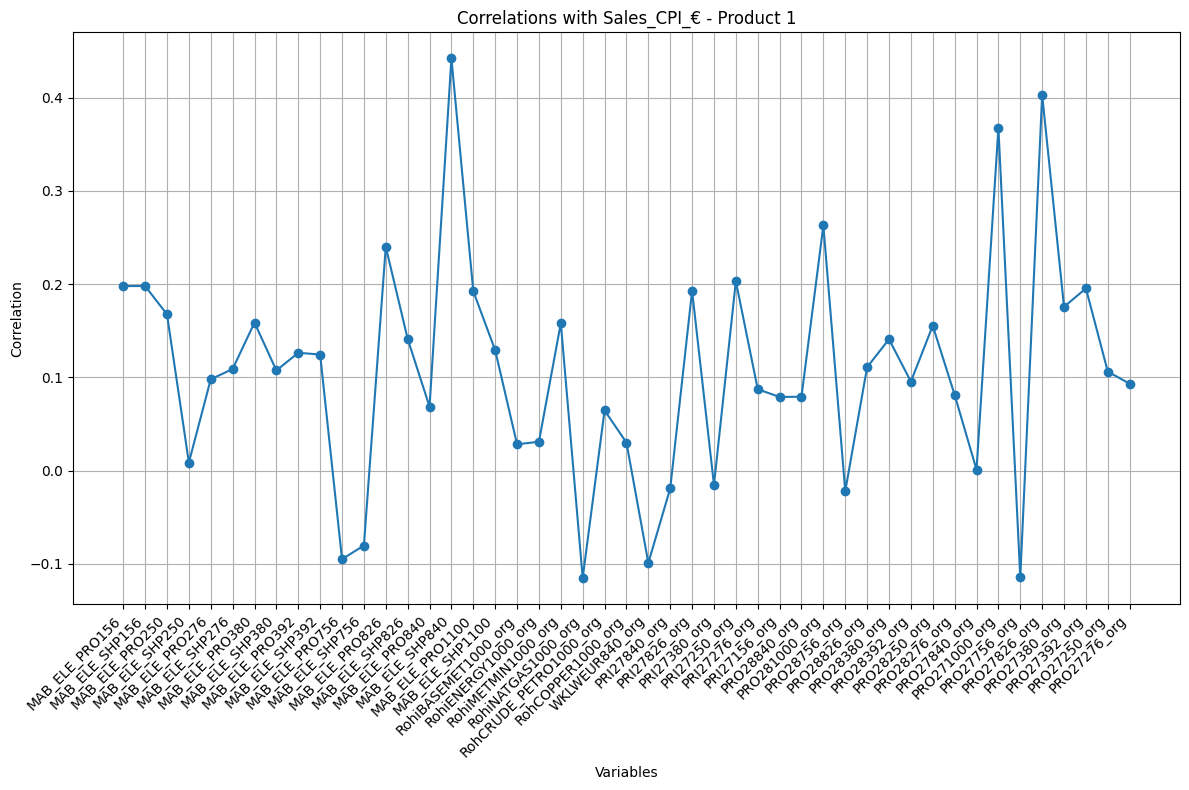

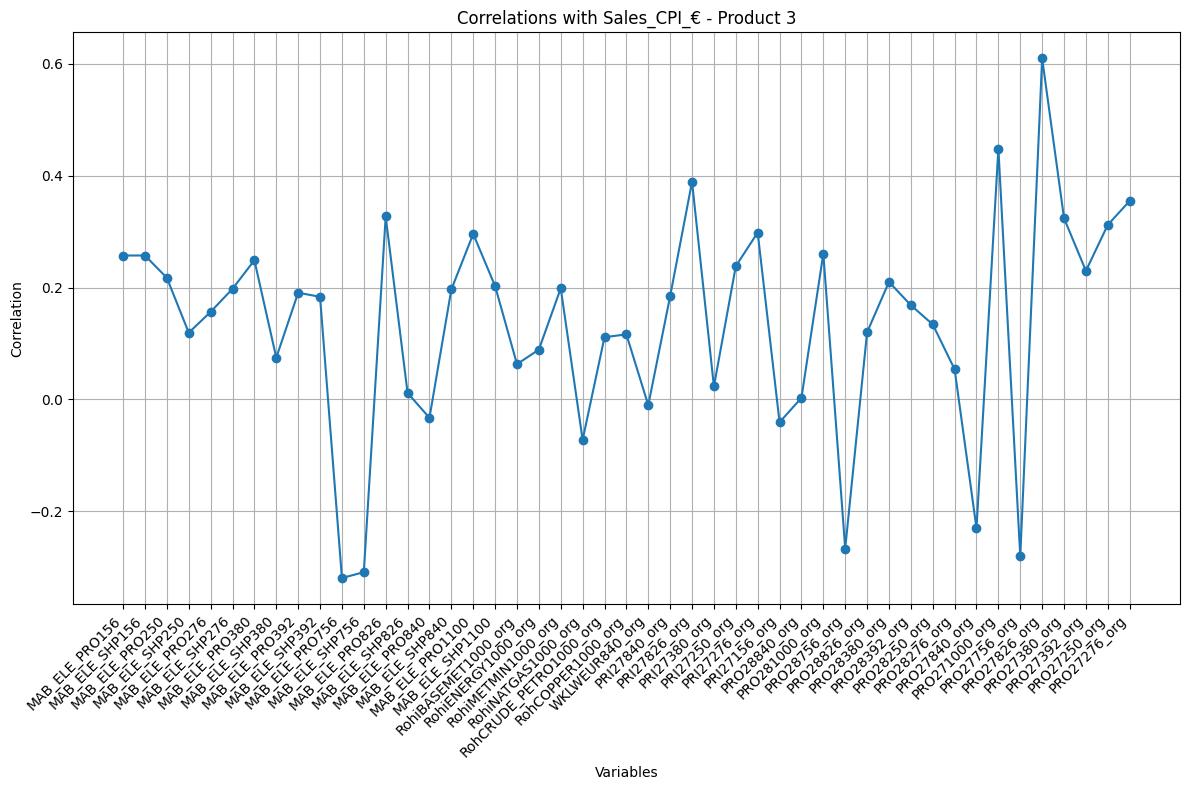

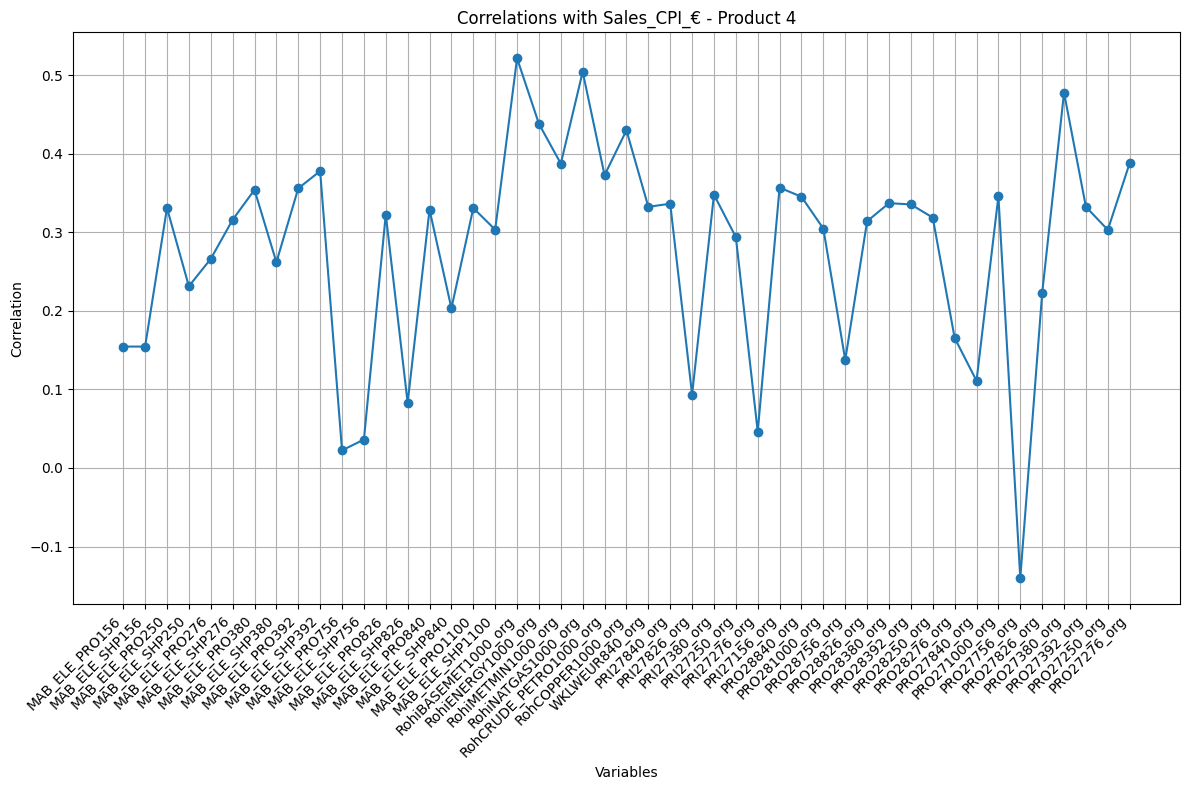

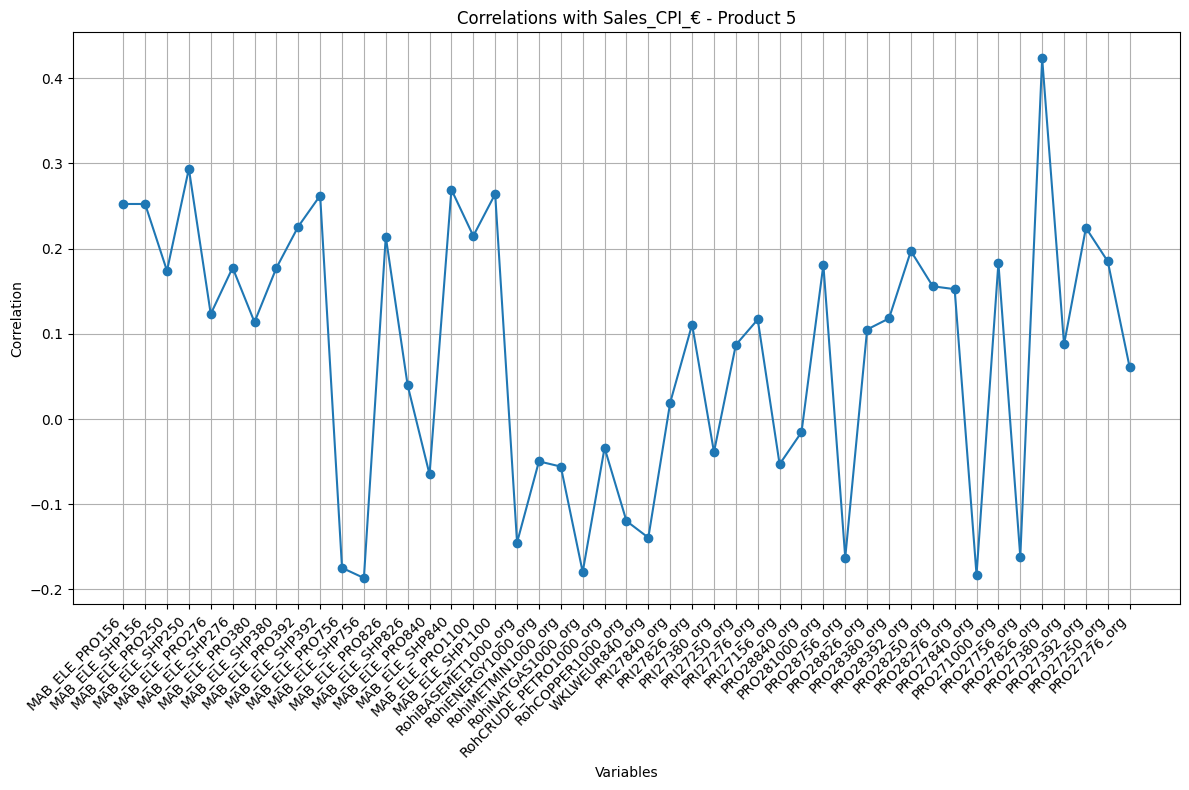

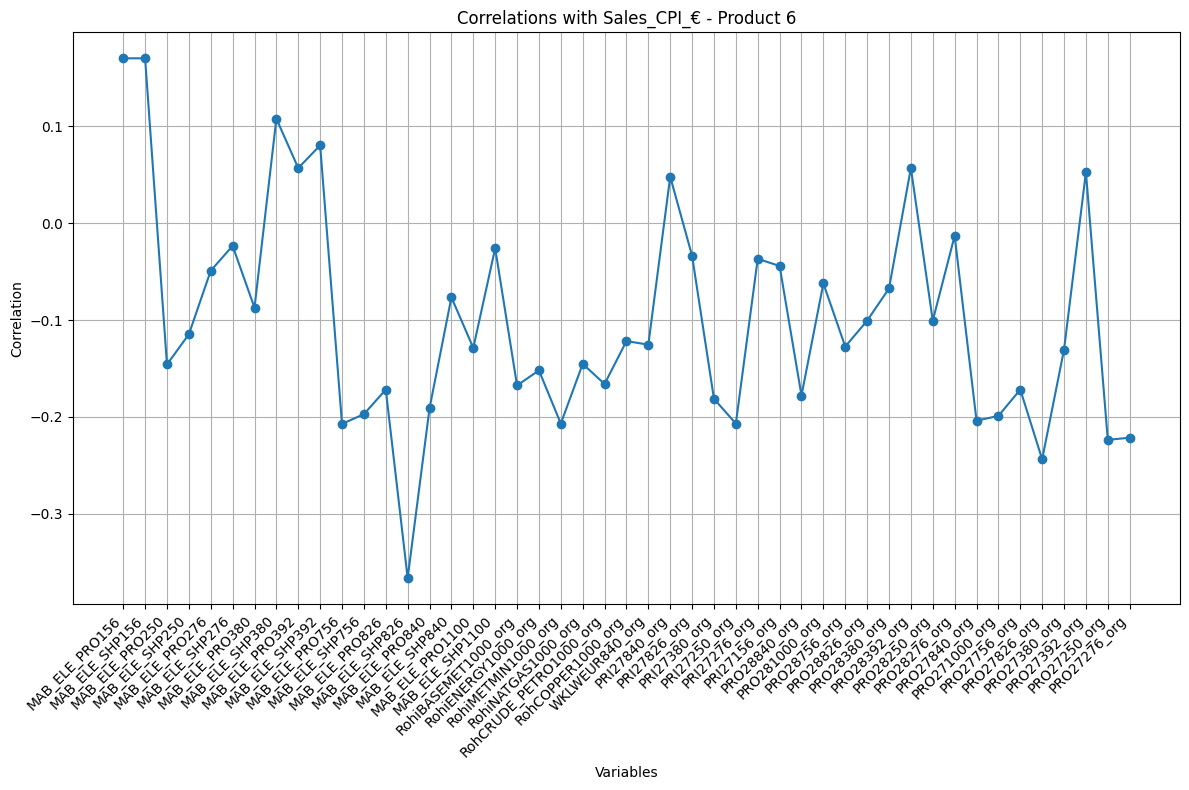

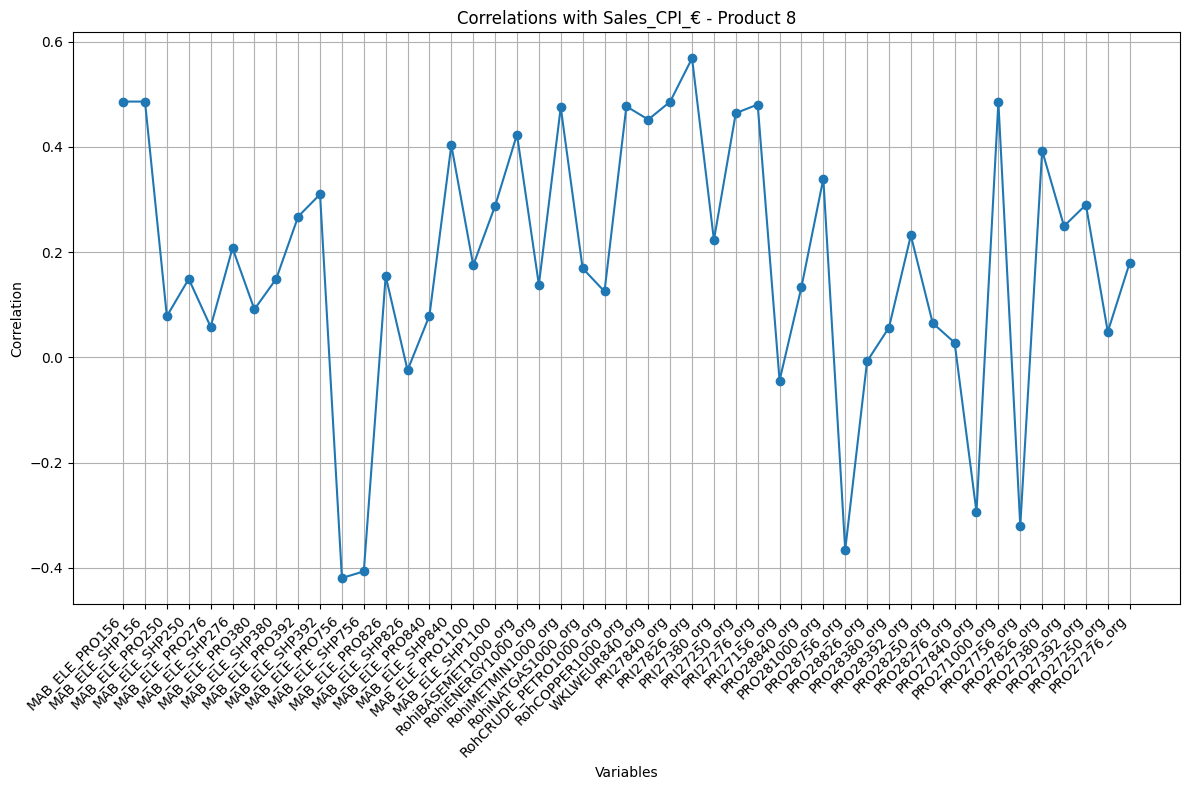

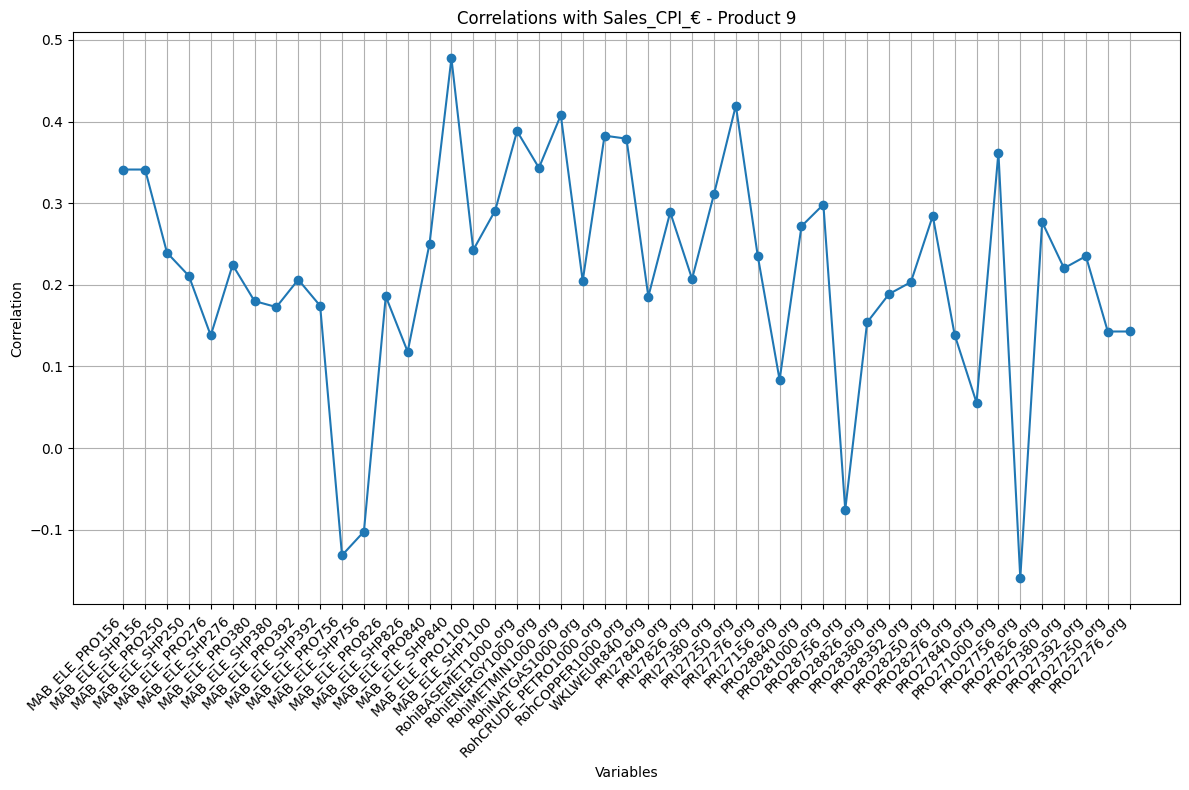

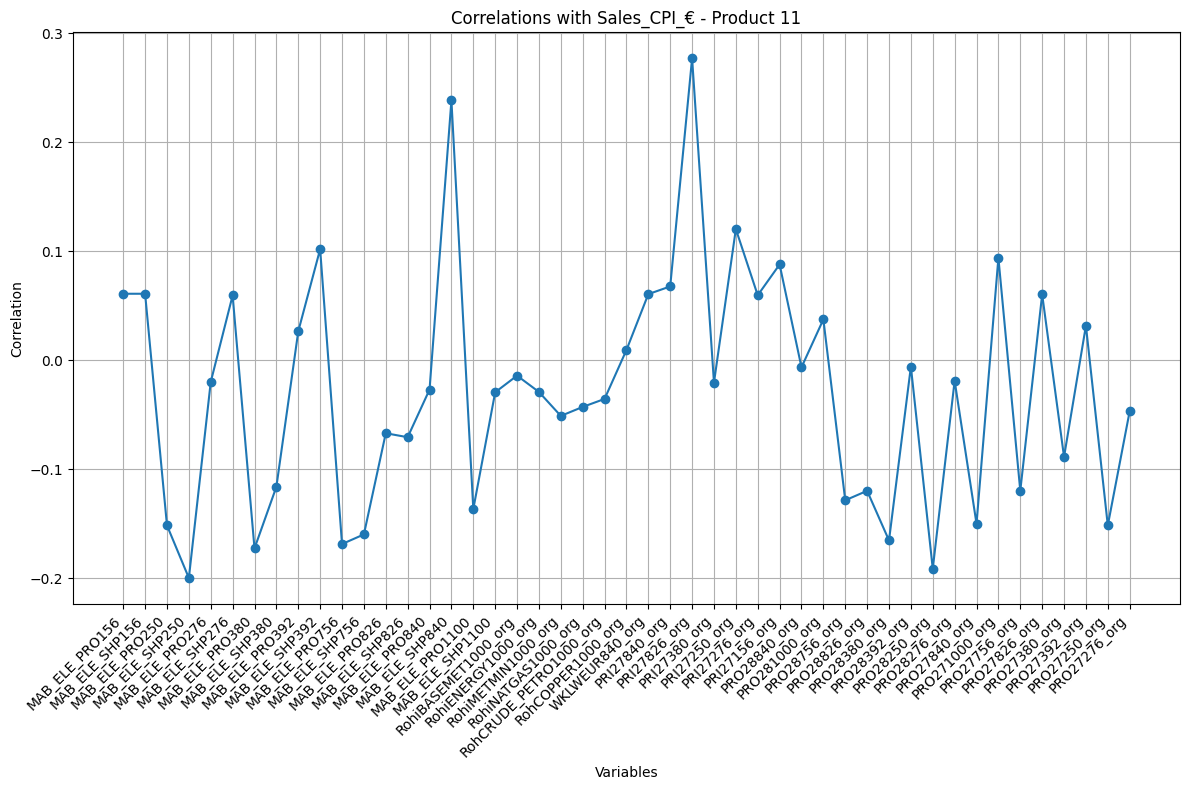

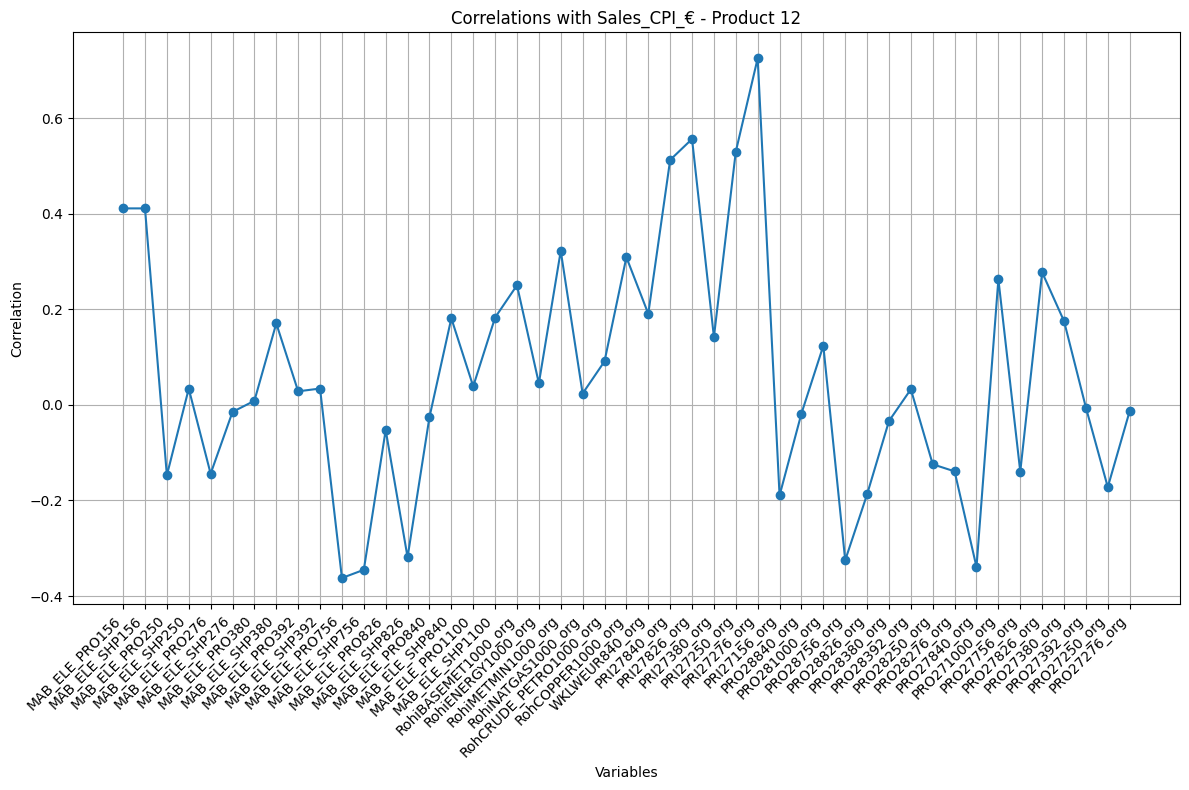

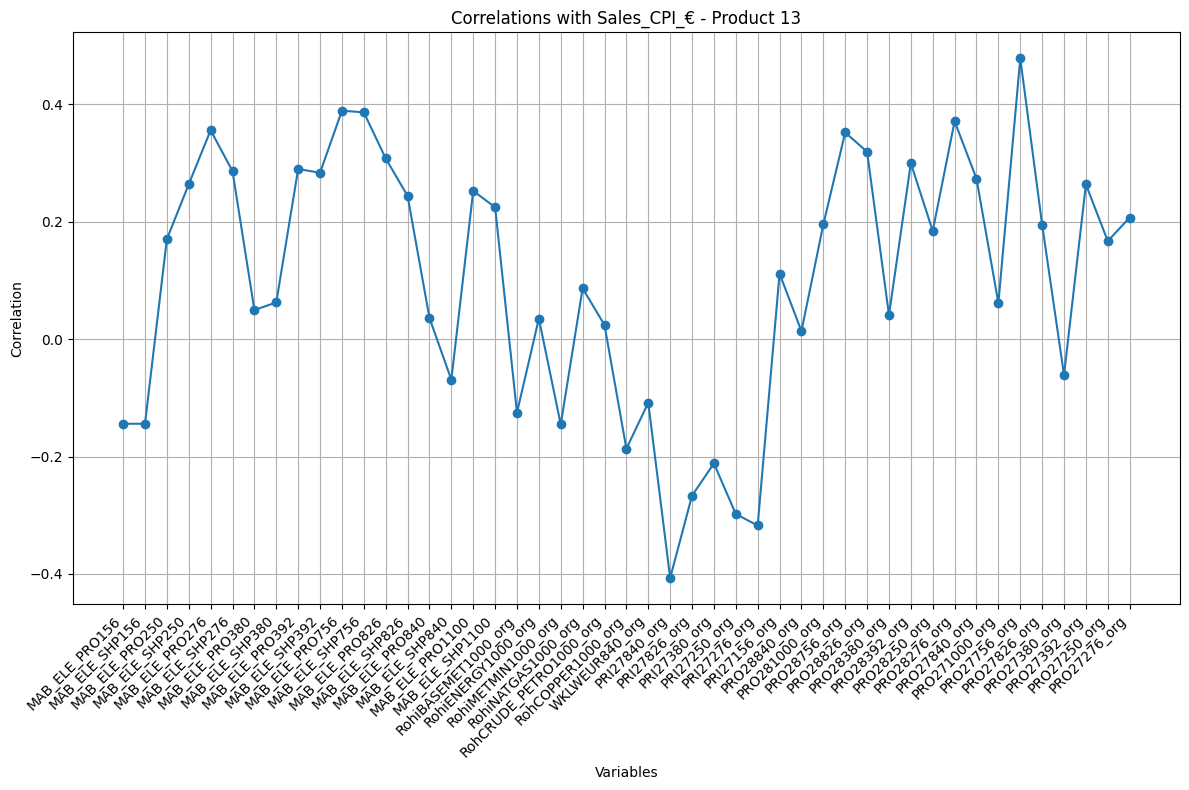

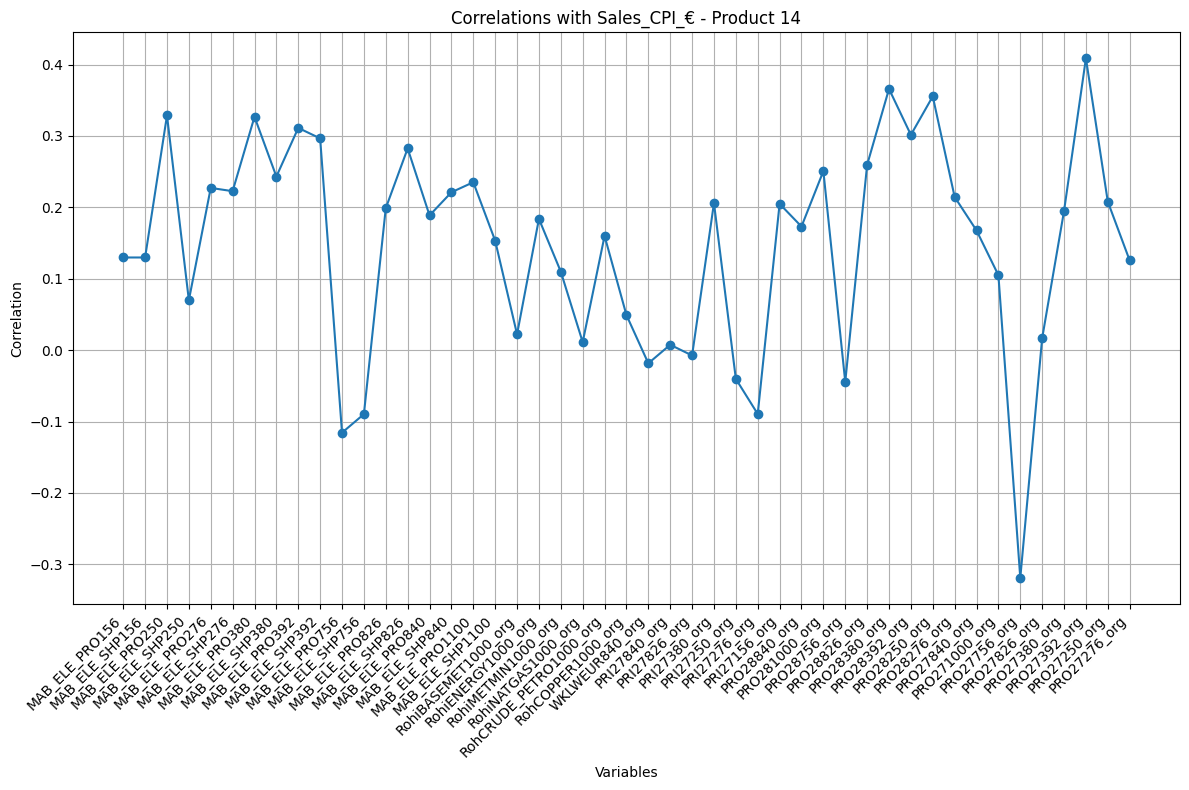

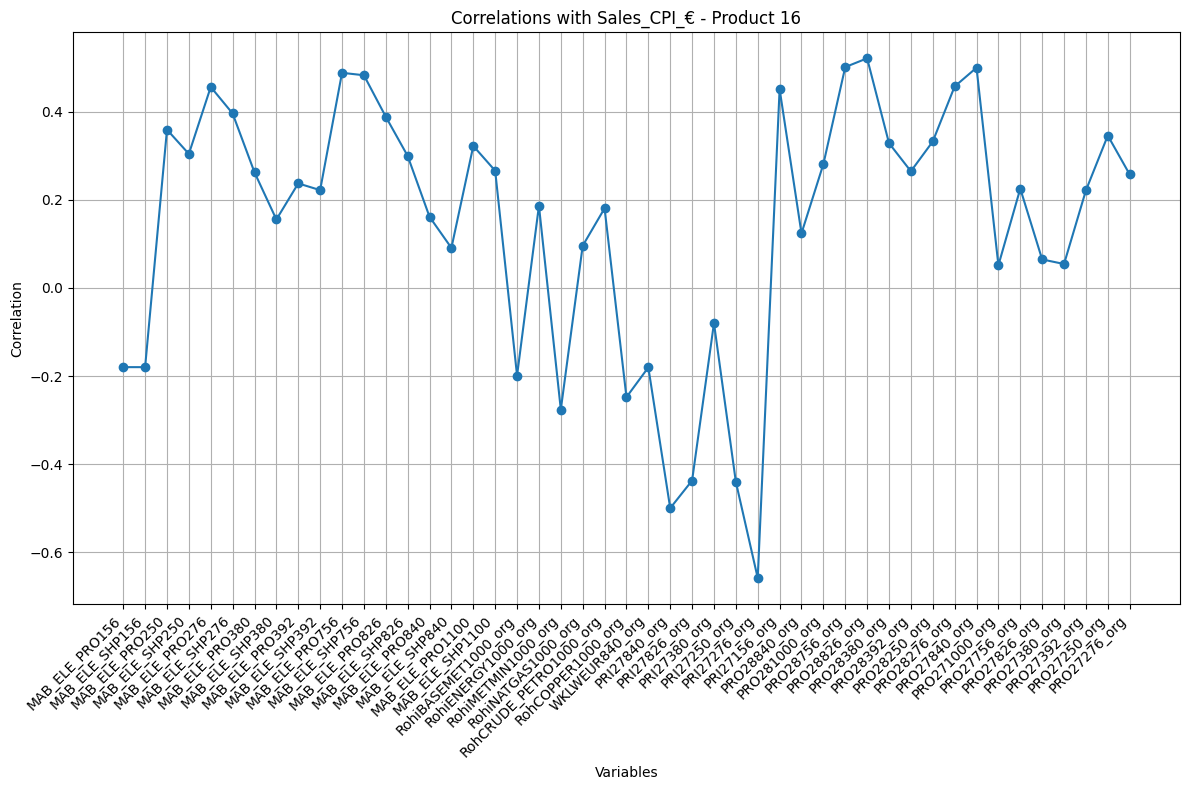

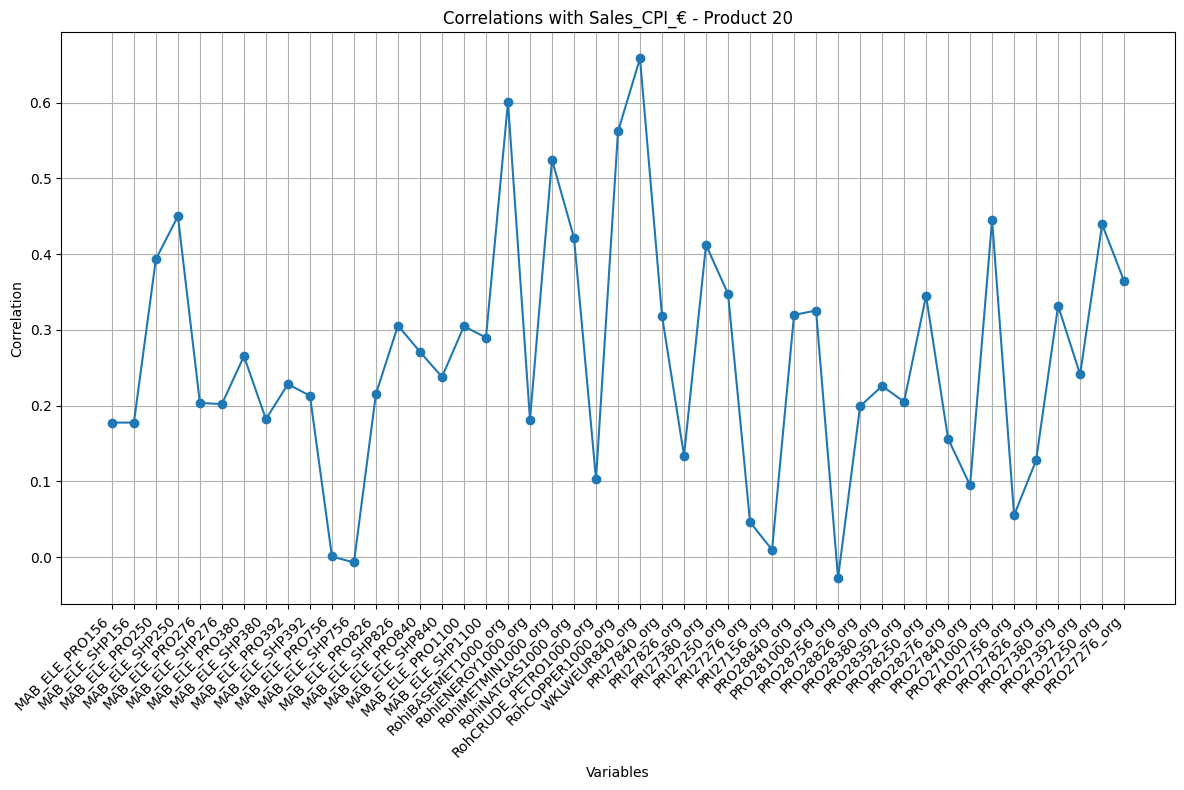

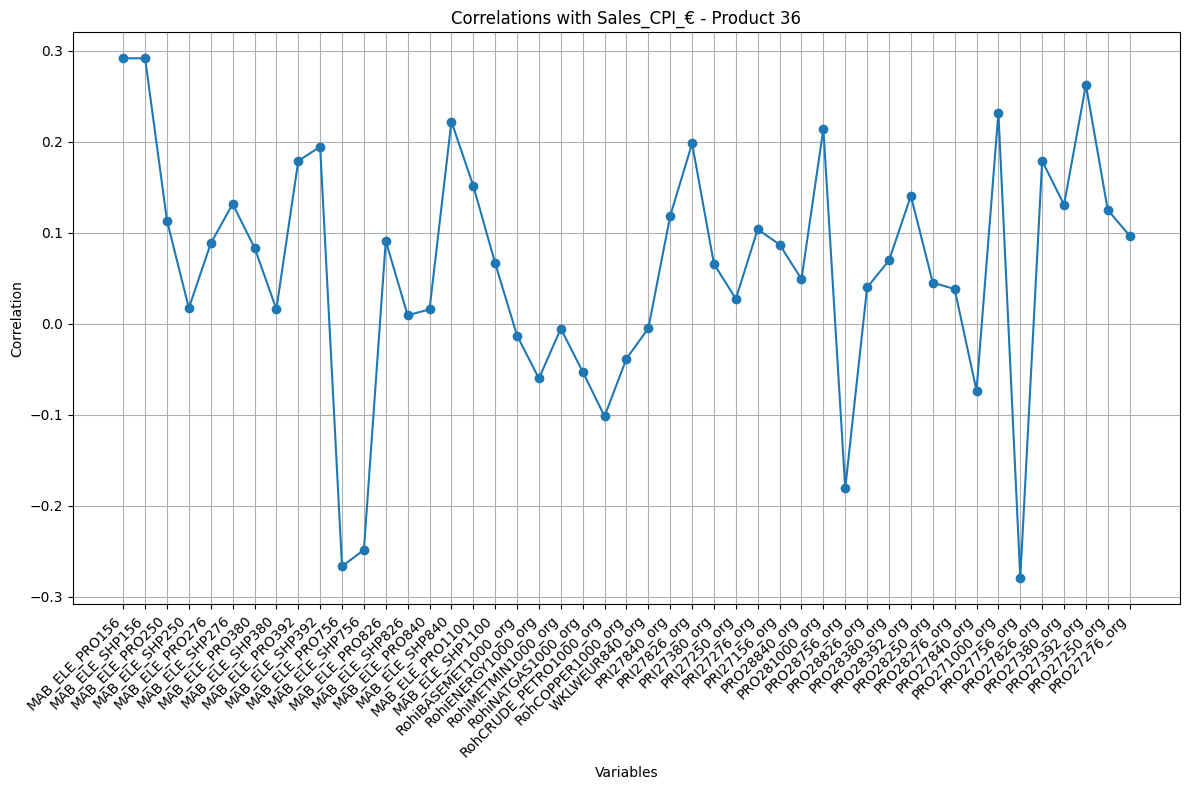

In [214]:
# Plotting correlations for each DataFrame
for number, data in train_test_data.items():
    # Access the original training data for the current product
    original_train_data = data['original']['train']
    
    # Calculate correlations
    correlations = original_train_data.corr(method='spearman')['Sales_CPI_€'].drop('Sales_CPI_€')
    
    plt.figure(figsize=(12, 8))
    plt.plot(correlations.index, correlations.values, marker='o', linestyle='-')
    
    # Adding labels and title
    plt.title(f'Correlations with Sales_CPI_€ - Product {number}')
    plt.xlabel('Variables')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    
    # Showing the plot
    plt.tight_layout()
    plt.show()


In [215]:
# Iterate through each product's original training data
for number, data in train_test_data.items():
    # Access the original training data for the current product
    original_train_data = data['original']['train']
    
    # Calculate correlations
    correlations = original_train_data.corr(method='spearman')['Sales_CPI_€'].drop('Sales_CPI_€')

    max_corr_variable = correlations.idxmax()
    max_corr_value = correlations[max_corr_variable]
    
    # Find the variable pair with minimum correlation
    min_corr_variable = correlations.idxmin()
    min_corr_value = correlations[min_corr_variable]
    
    print(f"Product {number}:")
    print(f"Maximum correlation: '{max_corr_variable}' and 'Sales_CPI_€' with correlation value {max_corr_value:.2f}")
    print(f"Minimum correlation: '{min_corr_variable}' and 'Sales_CPI_€' with correlation value {min_corr_value:.2f}")
    print()  


Product 1:
Maximum correlation: 'MAB_ELE_SHP840' and 'Sales_CPI_€' with correlation value 0.44
Minimum correlation: 'RohiNATGAS1000_org' and 'Sales_CPI_€' with correlation value -0.12

Product 3:
Maximum correlation: 'PRO27826_org' and 'Sales_CPI_€' with correlation value 0.61
Minimum correlation: 'MAB_ELE_PRO756' and 'Sales_CPI_€' with correlation value -0.32

Product 4:
Maximum correlation: 'RohiBASEMET1000_org' and 'Sales_CPI_€' with correlation value 0.52
Minimum correlation: 'PRO27756_org' and 'Sales_CPI_€' with correlation value -0.14

Product 5:
Maximum correlation: 'PRO27826_org' and 'Sales_CPI_€' with correlation value 0.42
Minimum correlation: 'MAB_ELE_SHP756' and 'Sales_CPI_€' with correlation value -0.19

Product 6:
Maximum correlation: 'MAB_ELE_PRO156' and 'Sales_CPI_€' with correlation value 0.17
Minimum correlation: 'MAB_ELE_SHP826' and 'Sales_CPI_€' with correlation value -0.37

Product 8:
Maximum correlation: 'PRI27826_org' and 'Sales_CPI_€' with correlation value 0.57

Recurring to Spearman method, there is no correlation (above 0.75 or below -0.75) between each variable and the target ('Sales_CPI_€'), for each product.

### Correlations between Indexes Features

In [216]:
def calculate_correlation_for_products(train_test_data, threshold=0.84):

    # Initialize an empty dictionary to store correlation matrices for each product
    correlation_matrices = {}

    # Initialize an empty dictionary to store correlated variables for each product
    correlated_variables = {}

    # Iterate over each product DataFrame
    for product_id, df in train_test_data.items():

        df = data['original']['train']

        # Calculate Spearman correlation matrix
        correlation_matrix = df.corr(method='spearman')

        # Store the correlation matrix in the dictionary
        correlation_matrices[product_id] = correlation_matrix

        # Find pairs of variables with correlation higher than the threshold
        correlations_above_threshold = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)
        correlated_variables[product_id] = {}

        for col in correlations_above_threshold:
            correlated_vars = correlations_above_threshold.index[correlations_above_threshold[col]].tolist()
            if correlated_vars:
                correlated_variables[product_id][col] = correlated_vars

    return correlation_matrices, correlated_variables

correlation_matrices, correlated_variables = calculate_correlation_for_products(train_test_data, threshold=0.84)

In [217]:
for product_id, correlated_vars_dict in correlated_variables.items():
    print(f"Group Product {product_id}:")
    if not correlated_vars_dict:
        print("No variables have correlations higher than the threshold.")
    else:
        processed_pairs = set()  # Set to keep track of processed pairs
        rows = []
        for variable, correlated_vars in correlated_vars_dict.items():
            for correlated_var in correlated_vars:
                # Check if the pair or its reverse has already been processed
                if (variable, correlated_var) not in processed_pairs and (correlated_var, variable) not in processed_pairs:
                    if correlated_var != 'Sales_CPI_€':  # Skip 'Sales_CPI_€' column
                        correlation_value = correlation_matrices[product_id].loc[variable, correlated_var]
                        rows.append([correlated_var, variable, correlation_value])
                        # Add the pair to the set of processed pairs
                        processed_pairs.add((variable, correlated_var))
        if rows:
            # Sort rows based on correlation value in descending order
            sorted_rows = sorted(rows, key=lambda x: x[2], reverse=True)
            print(tabulate(sorted_rows, headers=['Variable 1', 'Variable 2', 'Correlation'], tablefmt='grid', floatfmt=".2f"))
        else:
            print("No variables have correlations higher than the threshold.")
    print()  # Add a newline for better readability between products


Group Product 1:
+------------------------+---------------------+---------------+
| Variable 1             | Variable 2          |   Correlation |
+========================+=====================+===============+
| MAB_ELE_SHP756         | MAB_ELE_PRO756      |          1.00 |
+------------------------+---------------------+---------------+
| PRO28392_org           | MAB_ELE_PRO392      |          0.99 |
+------------------------+---------------------+---------------+
| PRO28380_org           | MAB_ELE_PRO380      |          0.99 |
+------------------------+---------------------+---------------+
| MAB_ELE_SHP392         | MAB_ELE_PRO392      |          0.98 |
+------------------------+---------------------+---------------+
| PRO28840_org           | MAB_ELE_PRO840      |          0.98 |
+------------------------+---------------------+---------------+
| RohCRUDE_PETRO1000_org | RohiENERGY1000_org  |          0.98 |
+------------------------+---------------------+---------------+
| PRO283

For each group product variables that have correlation higher than 0.89 are dropped since they are assumed to be redundant. 

In [218]:
# Threshold for correlation to drop variables
corr_threshold = 0.89

# Iterate over each DataFrame in train_test_data
for product_id, data_dict in train_test_data.items():
    df = data_dict['original']['train']  # Get the training DataFrame
    df_test = data_dict['original']['test']  # Get the training DataFrame
    
    # Calculate correlation matrix
    corr_matrix = df.corr(method='spearman').abs()
    
    # Create a mask to identify highly correlated features
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than threshold
    cols_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
    
    # Drop highly correlated features
    df.drop(columns=cols_to_drop, inplace=True)
    df_test.drop(columns=cols_to_drop, inplace=True)


In [219]:
# After dropping redundant variables, this is the number of variables that are left for each Group Product:
for product_id, data_dict in train_test_data.items():
    df = data_dict['original']['train']  # Get the training DataFrame
    print(f"Number of columns in train_test_data[{product_id}['original']['train']: {len(df.columns)}")


Number of columns in train_test_data[1['original']['train']: 27
Number of columns in train_test_data[3['original']['train']: 27
Number of columns in train_test_data[4['original']['train']: 27
Number of columns in train_test_data[5['original']['train']: 27
Number of columns in train_test_data[6['original']['train']: 27
Number of columns in train_test_data[8['original']['train']: 27
Number of columns in train_test_data[9['original']['train']: 27
Number of columns in train_test_data[11['original']['train']: 27
Number of columns in train_test_data[12['original']['train']: 27
Number of columns in train_test_data[13['original']['train']: 27
Number of columns in train_test_data[14['original']['train']: 27
Number of columns in train_test_data[16['original']['train']: 27
Number of columns in train_test_data[20['original']['train']: 27
Number of columns in train_test_data[36['original']['train']: 27


In [220]:
# After dropping redundant variables, this is the number of variables that are left for each Group Product:
for product_id, data_dict in train_test_data.items():
    df = data_dict['original']['test']  # Get the training DataFrame
    print(f"Number of columns in train_test_data[{product_id}['original']['train']: {len(df.columns)}")


Number of columns in train_test_data[1['original']['train']: 27
Number of columns in train_test_data[3['original']['train']: 27
Number of columns in train_test_data[4['original']['train']: 27
Number of columns in train_test_data[5['original']['train']: 27
Number of columns in train_test_data[6['original']['train']: 27
Number of columns in train_test_data[8['original']['train']: 27
Number of columns in train_test_data[9['original']['train']: 27
Number of columns in train_test_data[11['original']['train']: 27
Number of columns in train_test_data[12['original']['train']: 27
Number of columns in train_test_data[13['original']['train']: 27
Number of columns in train_test_data[14['original']['train']: 27
Number of columns in train_test_data[16['original']['train']: 27
Number of columns in train_test_data[20['original']['train']: 27
Number of columns in train_test_data[36['original']['train']: 27


### Correlations between Feature and Target - lag

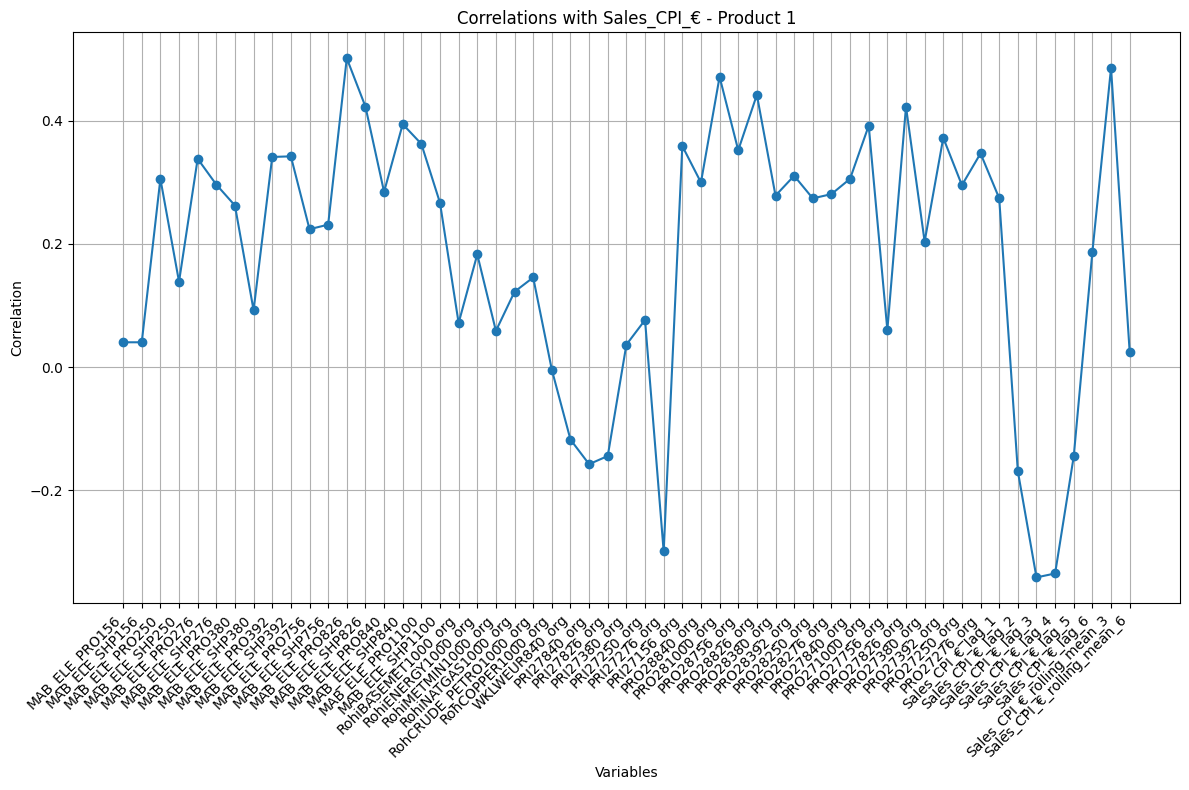

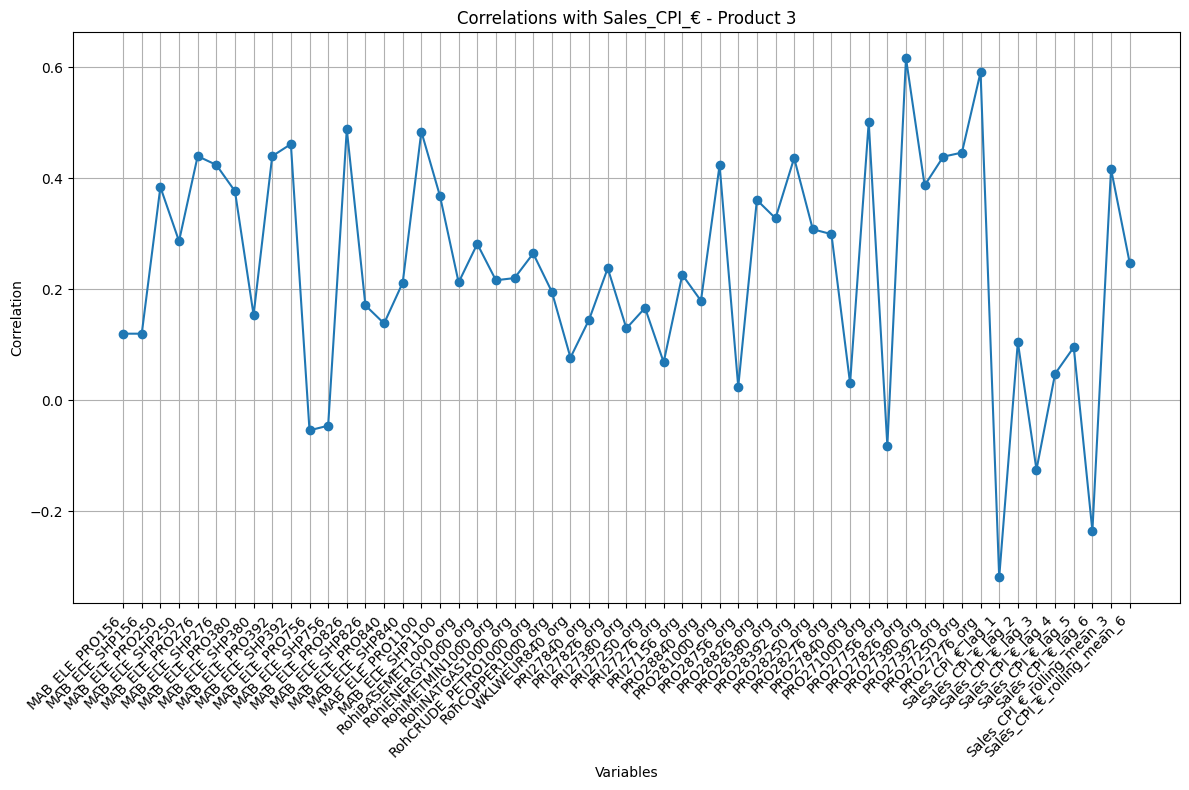

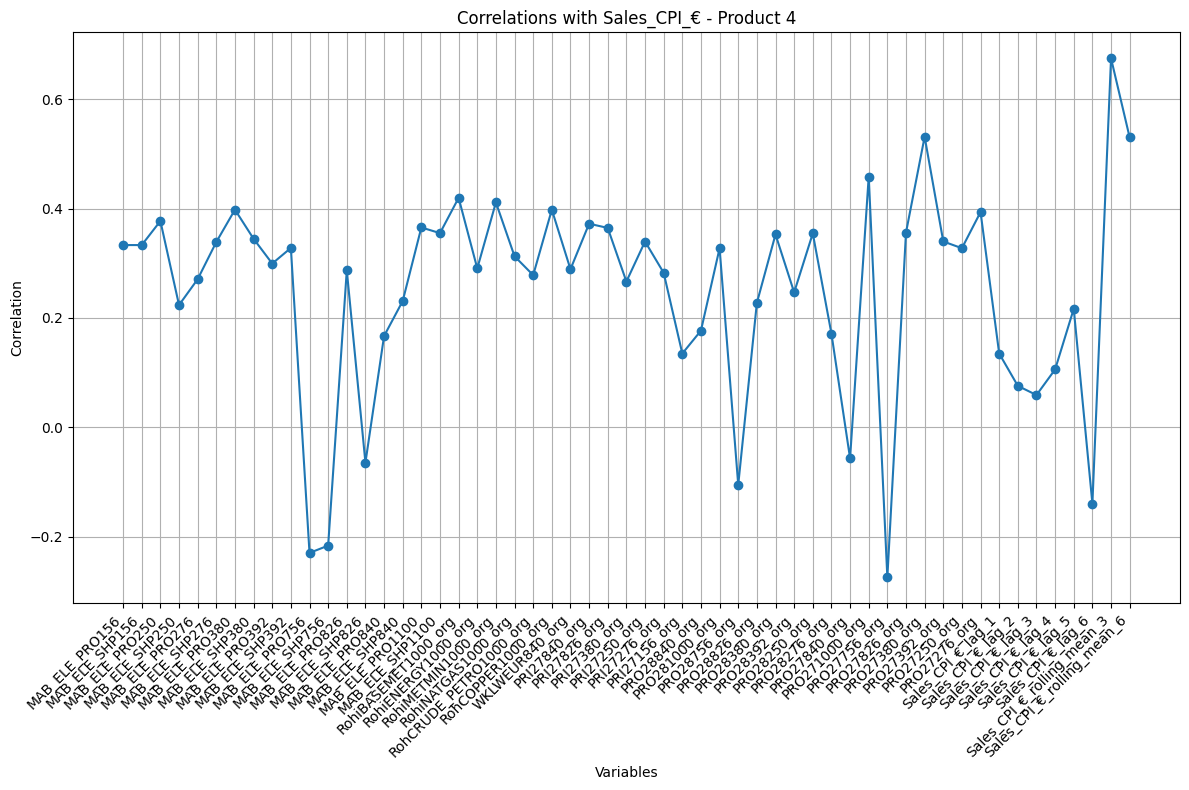

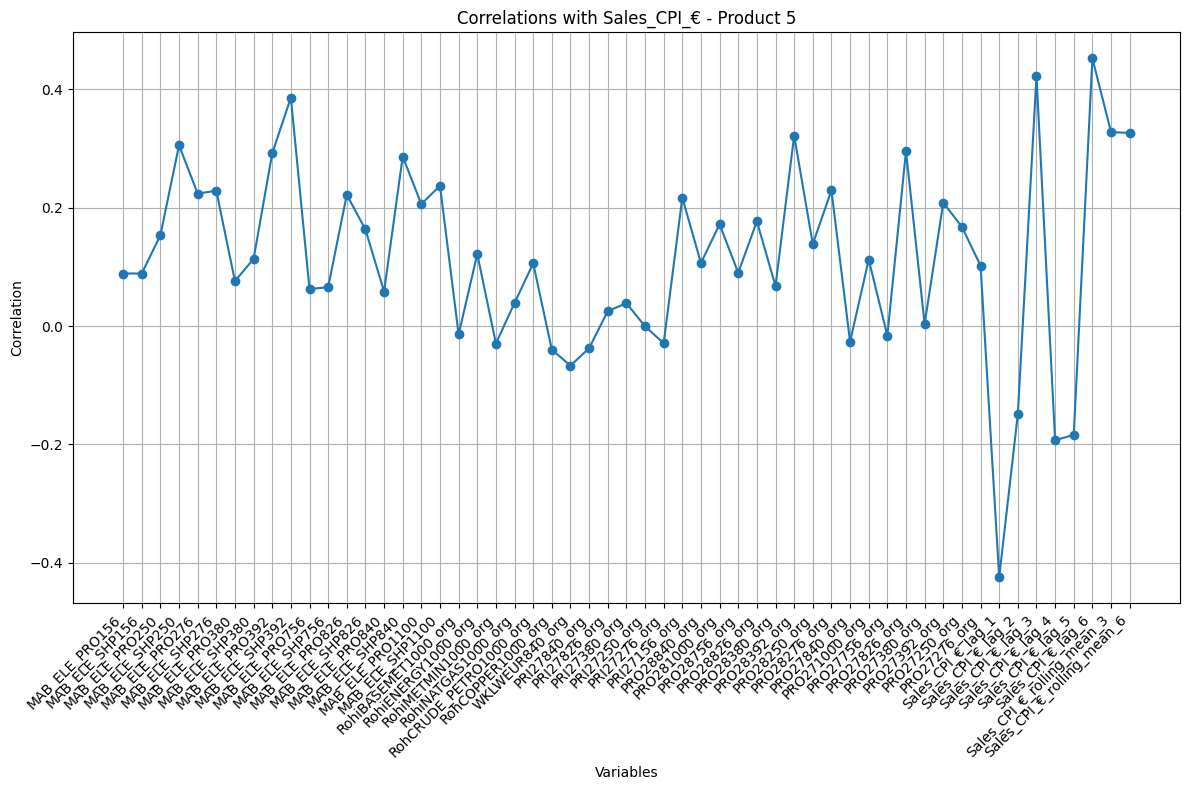

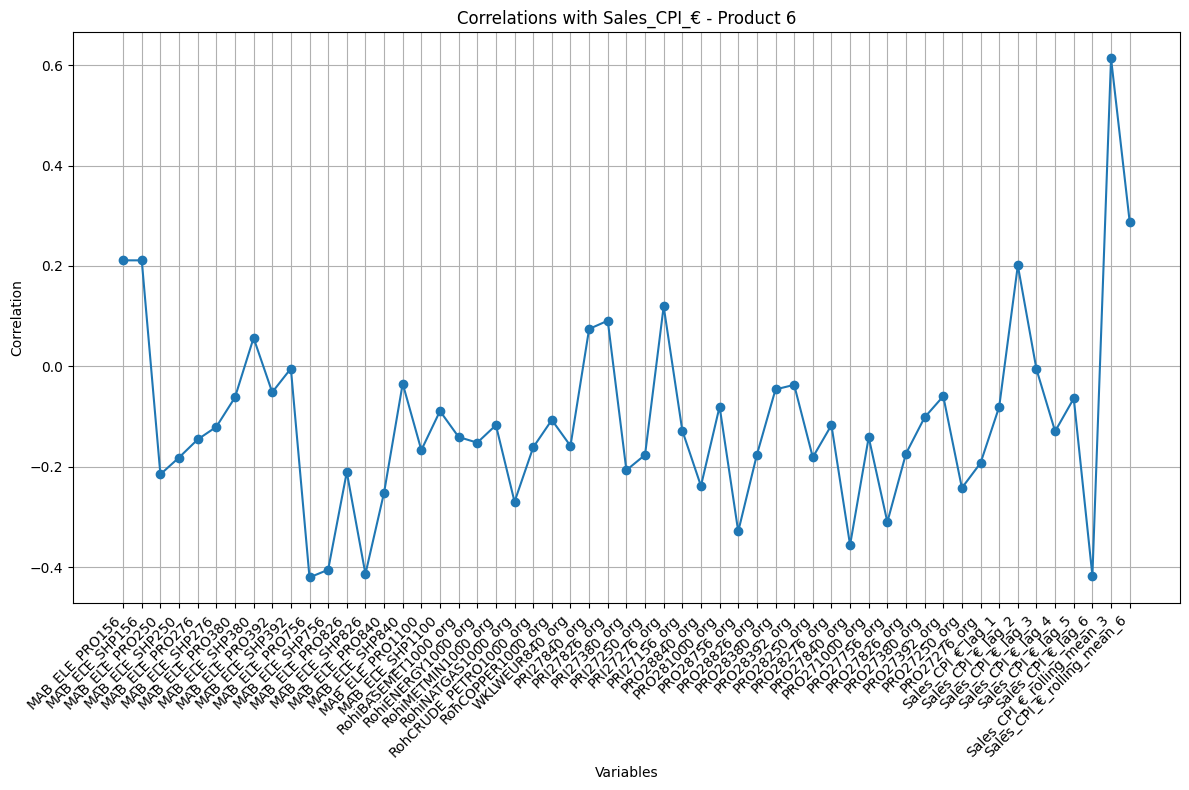

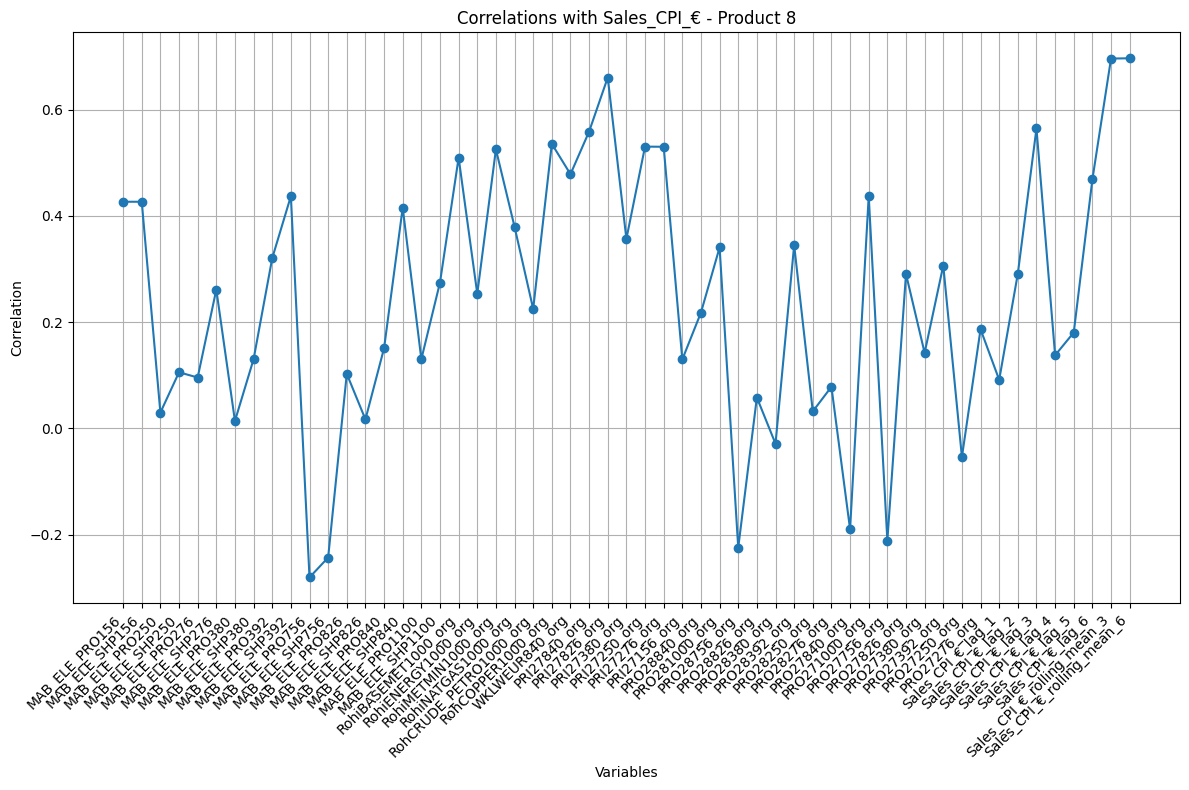

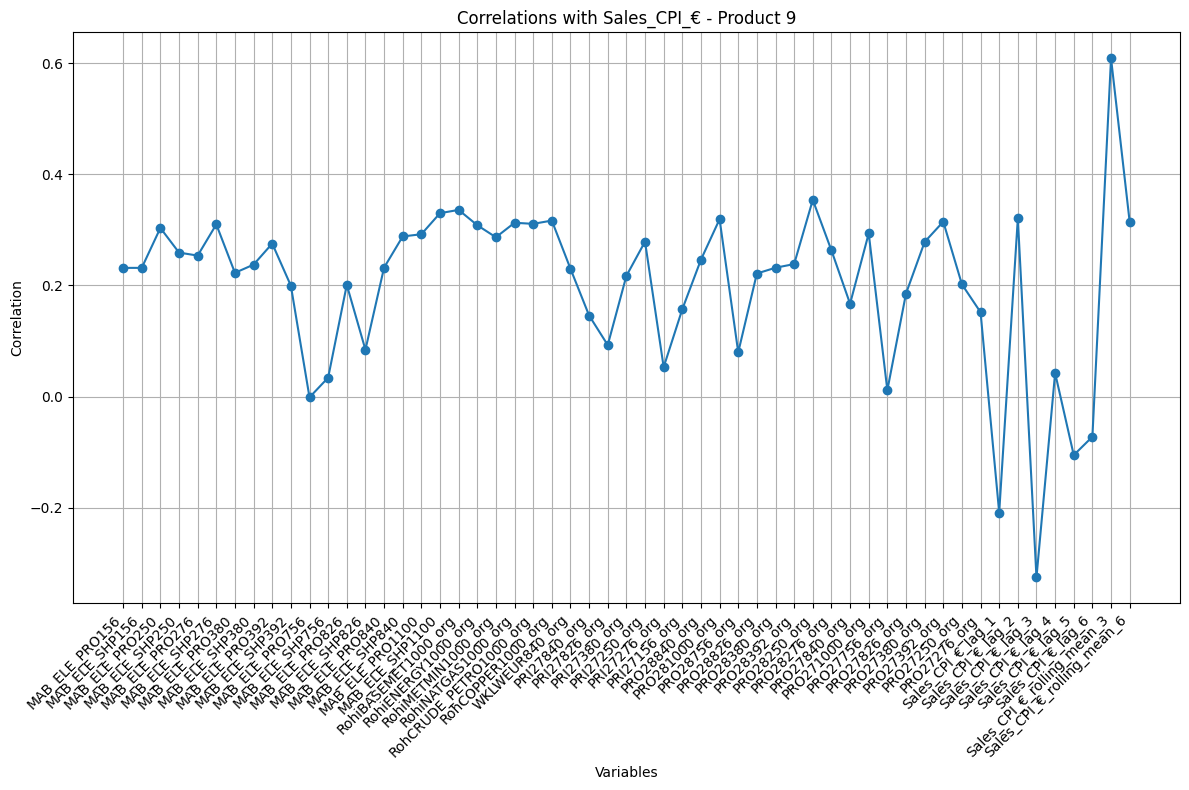

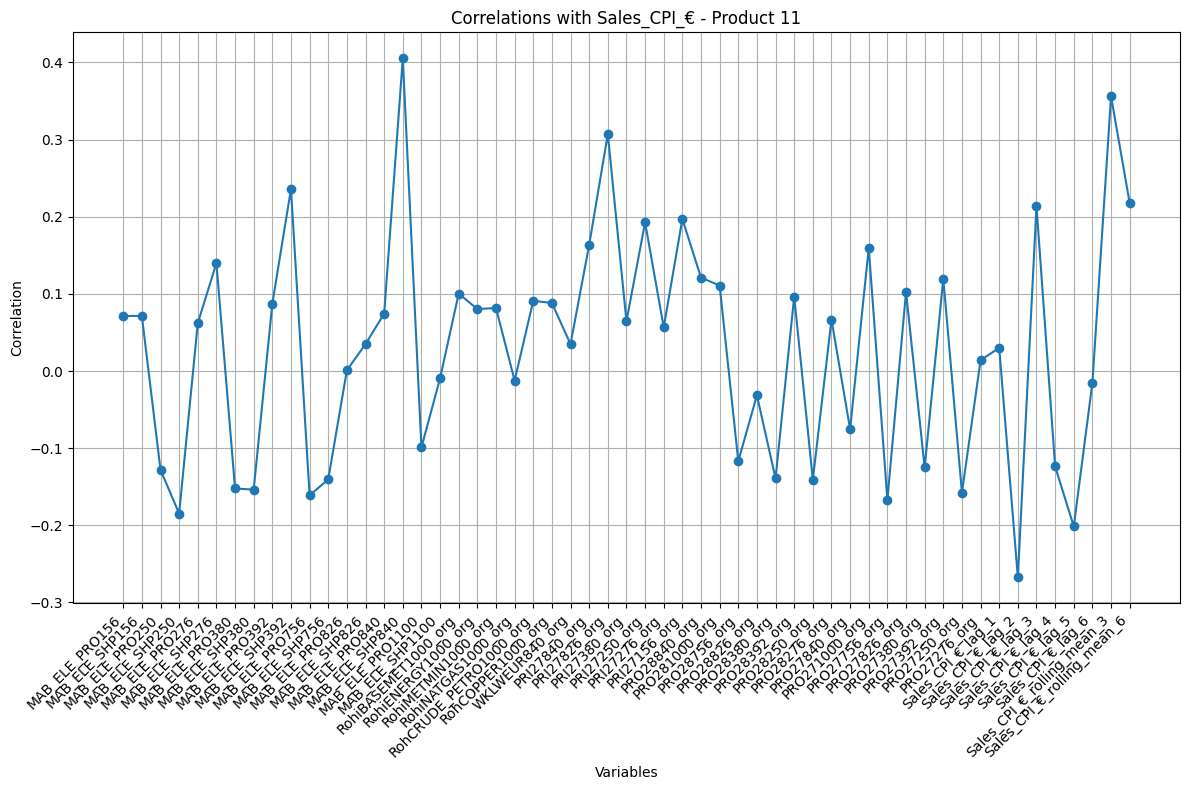

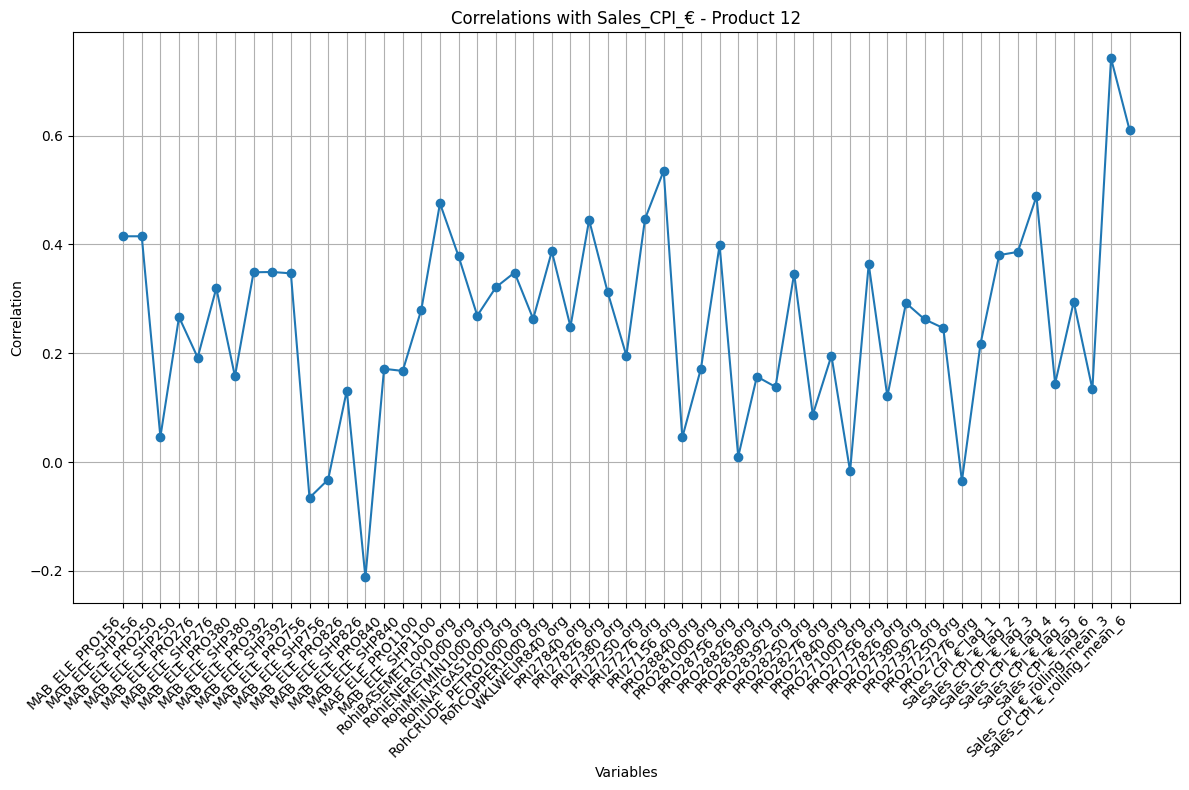

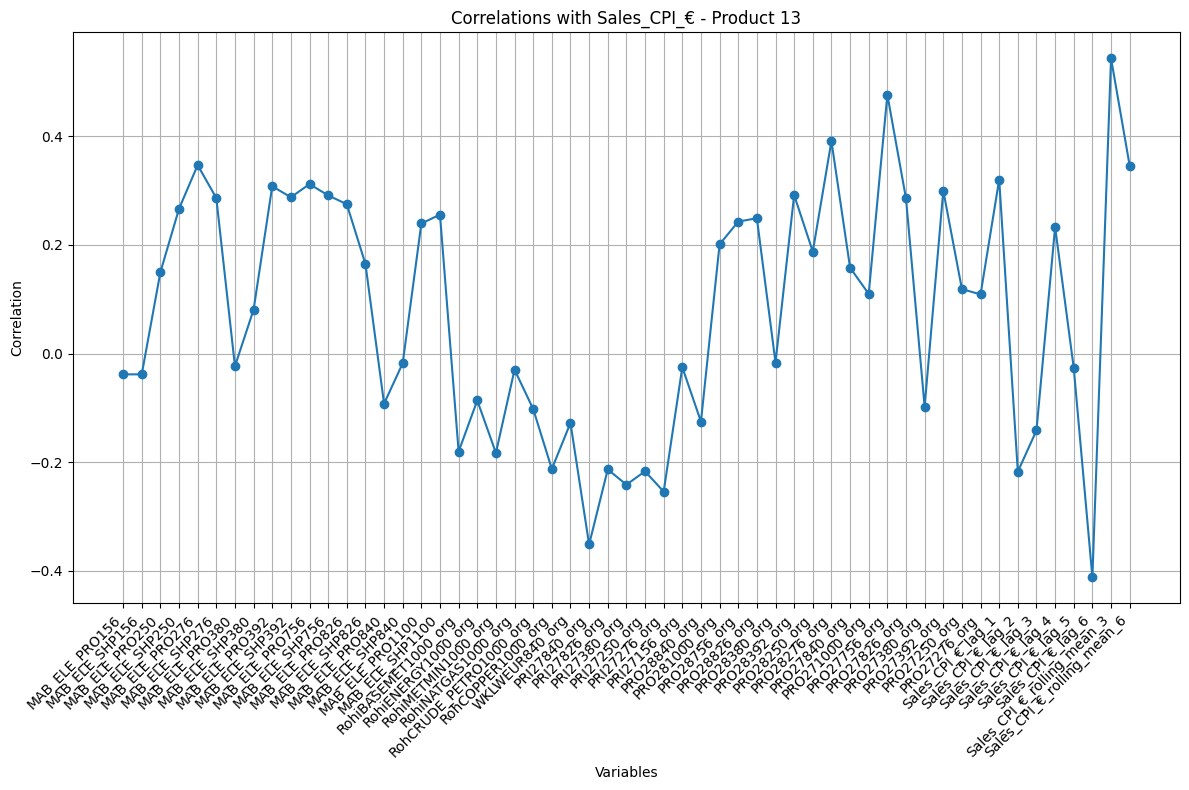

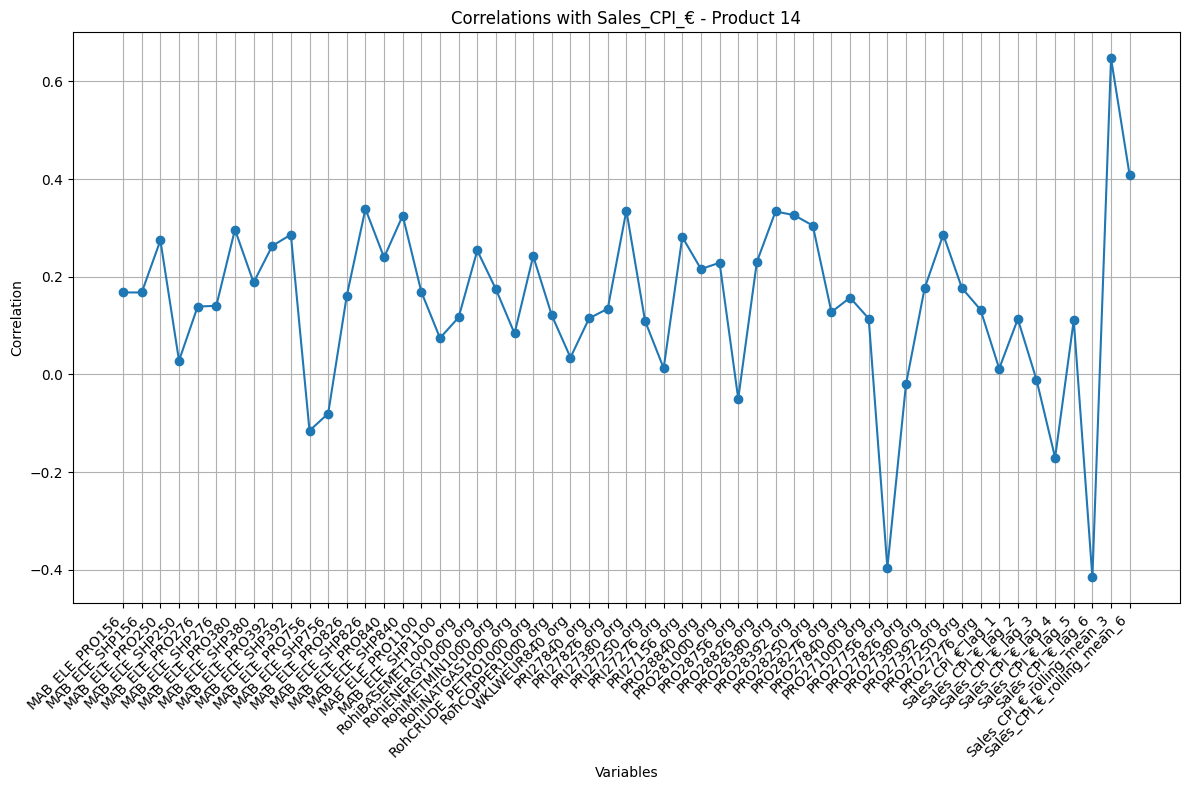

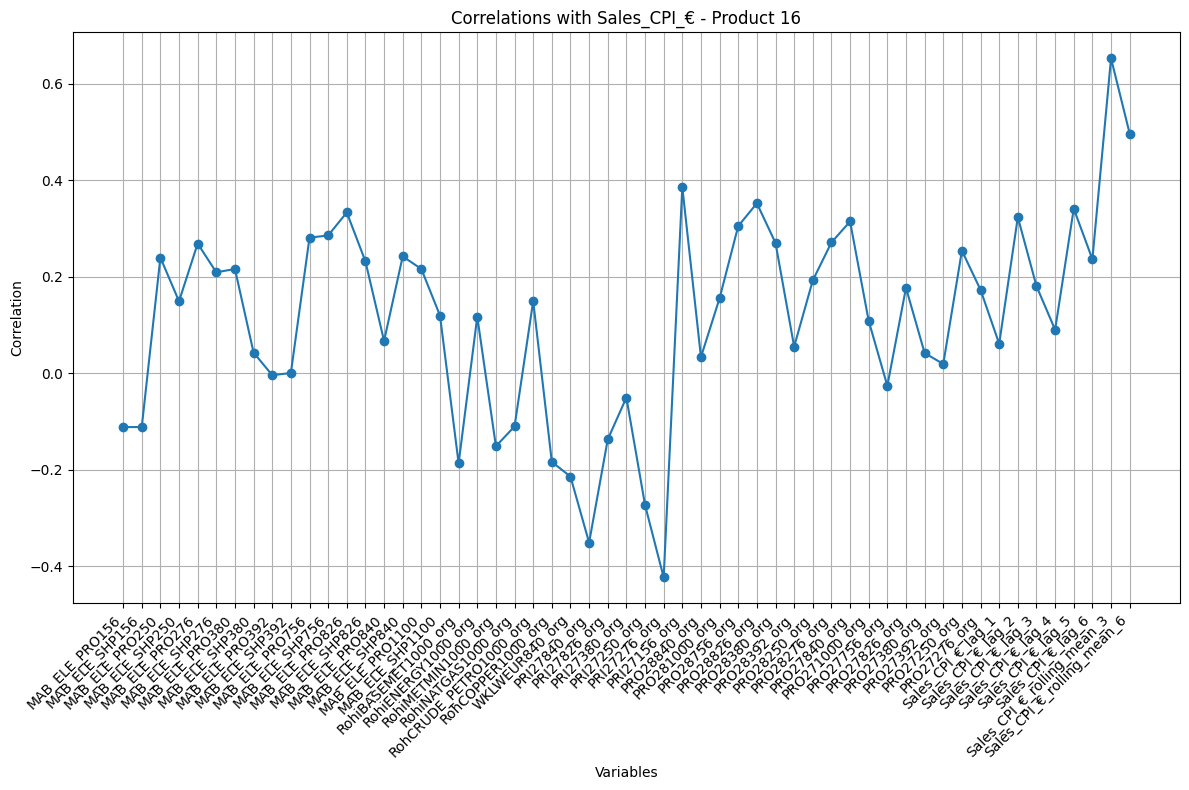

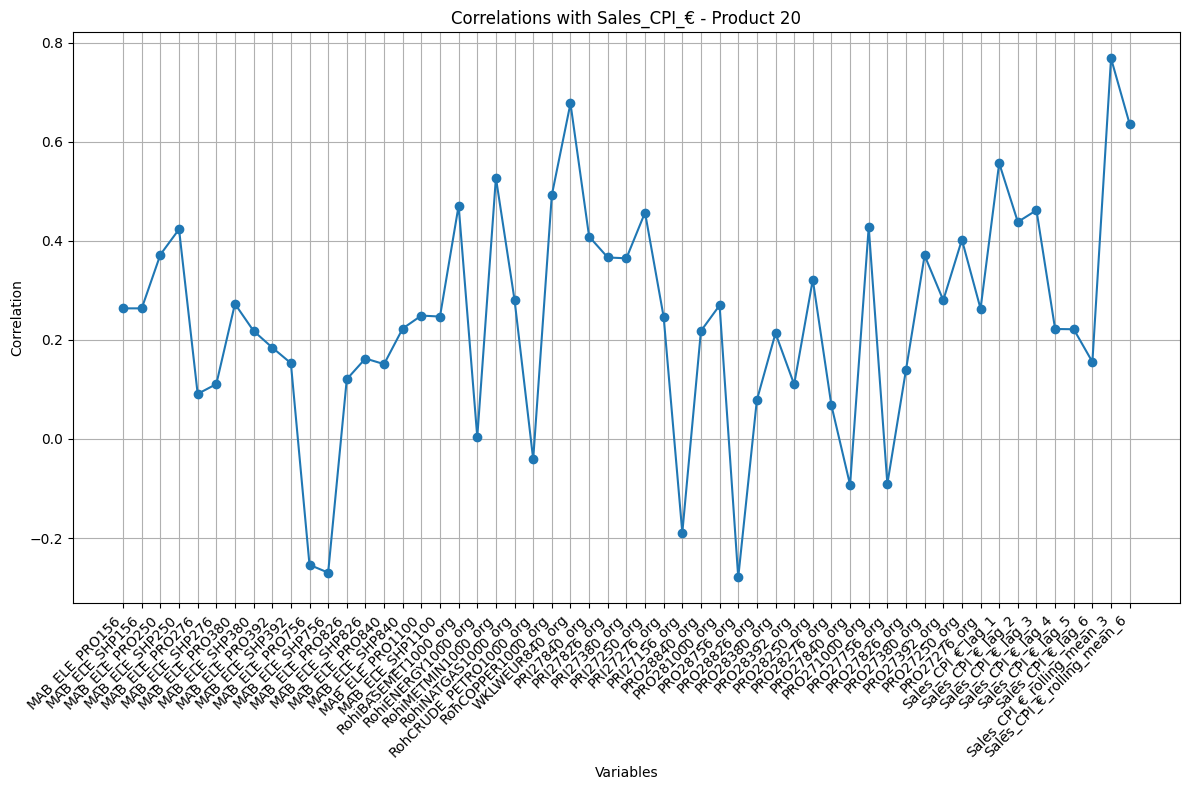

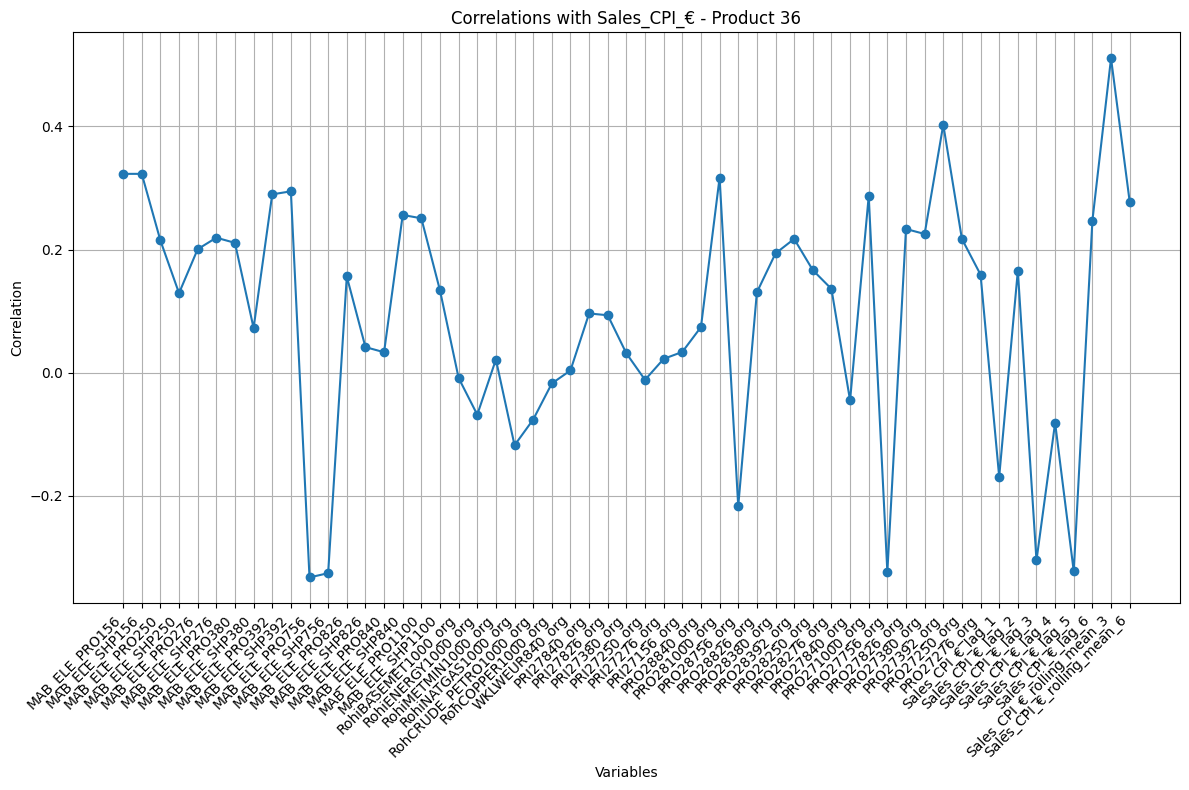

In [221]:
# Plotting correlations for each DataFrame
for number, data in train_test_data.items():
    # Access the original training data for the current product
    original_train_data = data['lag']['train']
    
    # Calculate correlations
    correlations = original_train_data.corr(method='spearman')['Sales_CPI_€'].drop('Sales_CPI_€')
    
    plt.figure(figsize=(12, 8))
    plt.plot(correlations.index, correlations.values, marker='o', linestyle='-')
    
    # Adding labels and title
    plt.title(f'Correlations with Sales_CPI_€ - Product {number}')
    plt.xlabel('Variables')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    
    # Showing the plot
    plt.tight_layout()
    plt.show()


In [222]:
# Iterate through each product's original training data
for number, data in train_test_data.items():
    # Access the original training data for the current product
    original_train_data = data['lag']['train']
    
    # Calculate correlations
    correlations = original_train_data.corr(method='spearman')['Sales_CPI_€'].drop('Sales_CPI_€')

    max_corr_variable = correlations.idxmax()
    max_corr_value = correlations[max_corr_variable]
    
    # Find the variable pair with minimum correlation
    min_corr_variable = correlations.idxmin()
    min_corr_value = correlations[min_corr_variable]
    
    print(f"Product {number}:")
    print(f"Maximum correlation: '{max_corr_variable}' and 'Sales_CPI_€' with correlation value {max_corr_value:.2f}")
    print(f"Minimum correlation: '{min_corr_variable}' and 'Sales_CPI_€' with correlation value {min_corr_value:.2f}")
    print()  


Product 1:
Maximum correlation: 'MAB_ELE_PRO826' and 'Sales_CPI_€' with correlation value 0.50
Minimum correlation: 'Sales_CPI_€_lag_3' and 'Sales_CPI_€' with correlation value -0.34

Product 3:
Maximum correlation: 'PRO27826_org' and 'Sales_CPI_€' with correlation value 0.62
Minimum correlation: 'Sales_CPI_€_lag_1' and 'Sales_CPI_€' with correlation value -0.32

Product 4:
Maximum correlation: 'Sales_CPI_€_rolling_mean_3' and 'Sales_CPI_€' with correlation value 0.67
Minimum correlation: 'PRO27756_org' and 'Sales_CPI_€' with correlation value -0.27

Product 5:
Maximum correlation: 'Sales_CPI_€_lag_6' and 'Sales_CPI_€' with correlation value 0.45
Minimum correlation: 'Sales_CPI_€_lag_1' and 'Sales_CPI_€' with correlation value -0.42

Product 6:
Maximum correlation: 'Sales_CPI_€_rolling_mean_3' and 'Sales_CPI_€' with correlation value 0.61
Minimum correlation: 'MAB_ELE_PRO756' and 'Sales_CPI_€' with correlation value -0.42

Product 8:
Maximum correlation: 'Sales_CPI_€_rolling_mean_6' an

Recurring to Spearman method, there is only a correlation above 0.75 between the products and target: <br> 
Product 4 - `Sales_CPI_€_rolling_mean_3`

### Correlations between Indexes Features

In [223]:
def calculate_correlation_for_products(train_test_data, threshold=0.84):

    # Initialize an empty dictionary to store correlation matrices for each product
    correlation_matrices = {}

    # Initialize an empty dictionary to store correlated variables for each product
    correlated_variables = {}

    # Iterate over each product DataFrame
    for product_id, df in train_test_data.items():

        df = data['lag']['train']

        # Calculate Spearman correlation matrix
        correlation_matrix = df.corr(method='spearman')

        # Store the correlation matrix in the dictionary
        correlation_matrices[product_id] = correlation_matrix

        # Find pairs of variables with correlation higher than the threshold
        correlations_above_threshold = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)
        correlated_variables[product_id] = {}

        for col in correlations_above_threshold:
            correlated_vars = correlations_above_threshold.index[correlations_above_threshold[col]].tolist()
            if correlated_vars:
                correlated_variables[product_id][col] = correlated_vars

    return correlation_matrices, correlated_variables

correlation_matrices, correlated_variables = calculate_correlation_for_products(train_test_data, threshold=0.84)

In [224]:
for product_id, correlated_vars_dict in correlated_variables.items():
    print(f"Group Product {product_id}:")
    if not correlated_vars_dict:
        print("No variables have correlations higher than the threshold.")
    else:
        processed_pairs = set()  # Set to keep track of processed pairs
        rows = []
        for variable, correlated_vars in correlated_vars_dict.items():
            for correlated_var in correlated_vars:
                # Check if the pair or its reverse has already been processed
                if (variable, correlated_var) not in processed_pairs and (correlated_var, variable) not in processed_pairs:
                    if correlated_var != 'Sales_CPI_€':  # Skip 'Sales_CPI_€' column
                        correlation_value = correlation_matrices[product_id].loc[variable, correlated_var]
                        rows.append([correlated_var, variable, correlation_value])
                        # Add the pair to the set of processed pairs
                        processed_pairs.add((variable, correlated_var))
        if rows:
            # Sort rows based on correlation value in descending order
            sorted_rows = sorted(rows, key=lambda x: x[2], reverse=True)
            print(tabulate(sorted_rows, headers=['Variable 1', 'Variable 2', 'Correlation'], tablefmt='grid', floatfmt=".2f"))
        else:
            print("No variables have correlations higher than the threshold.")
    print()  # Add a newline for better readability between products


Group Product 1:
+------------------------+---------------------+---------------+
| Variable 1             | Variable 2          |   Correlation |
+========================+=====================+===============+
| MAB_ELE_SHP756         | MAB_ELE_PRO756      |          0.99 |
+------------------------+---------------------+---------------+
| RohCRUDE_PETRO1000_org | RohiENERGY1000_org  |          0.99 |
+------------------------+---------------------+---------------+
| RohCOPPER1000_org      | RohiMETMIN1000_org  |          0.99 |
+------------------------+---------------------+---------------+
| PRO28380_org           | MAB_ELE_PRO380      |          0.99 |
+------------------------+---------------------+---------------+
| PRO28840_org           | MAB_ELE_PRO840      |          0.98 |
+------------------------+---------------------+---------------+
| RohCOPPER1000_org      | RohiBASEMET1000_org |          0.98 |
+------------------------+---------------------+---------------+
| RohiME

For each group product variables that have correlation higher than 0.89 are dropped since they are assumed to be redundant. 

In [225]:
# Threshold for correlation to drop variables
corr_threshold = 0.89

# Iterate over each DataFrame in train_test_data
for product_id, data_dict in train_test_data.items():
    df = data_dict['lag']['train']  # Get the training DataFrame
    df_test = data_dict['lag']['test']
    
    # Calculate correlation matrix
    corr_matrix = df.corr(method='spearman').abs()
    
    # Create a mask to identify highly correlated features
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than threshold
    cols_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
    
    # Drop highly correlated features
    df.drop(columns=cols_to_drop, inplace=True)
    df_test.drop(columns=cols_to_drop, inplace=True)


In [226]:
# After dropping redundant variables, this is the number of variables that are left for each Group Product:
for product_id, data_dict in train_test_data.items():
    df = data_dict['lag']['train']  # Get the training DataFrame
    print(f"Number of columns in train_test_data[{product_id}['lag']['train']: {len(df.columns)}")


Number of columns in train_test_data[1['lag']['train']: 35
Number of columns in train_test_data[3['lag']['train']: 35
Number of columns in train_test_data[4['lag']['train']: 35
Number of columns in train_test_data[5['lag']['train']: 35
Number of columns in train_test_data[6['lag']['train']: 35
Number of columns in train_test_data[8['lag']['train']: 34
Number of columns in train_test_data[9['lag']['train']: 35
Number of columns in train_test_data[11['lag']['train']: 35
Number of columns in train_test_data[12['lag']['train']: 35
Number of columns in train_test_data[13['lag']['train']: 35
Number of columns in train_test_data[14['lag']['train']: 35
Number of columns in train_test_data[16['lag']['train']: 35
Number of columns in train_test_data[20['lag']['train']: 34
Number of columns in train_test_data[36['lag']['train']: 35


In [227]:
# After dropping redundant variables, this is the number of variables that are left for each Group Product:
for product_id, data_dict in train_test_data.items():
    df = data_dict['lag']['test']  # Get the training DataFrame
    print(f"Number of columns in train_test_data[{product_id}['lag']['test']: {len(df.columns)}")


Number of columns in train_test_data[1['lag']['test']: 35
Number of columns in train_test_data[3['lag']['test']: 35
Number of columns in train_test_data[4['lag']['test']: 35
Number of columns in train_test_data[5['lag']['test']: 35
Number of columns in train_test_data[6['lag']['test']: 35
Number of columns in train_test_data[8['lag']['test']: 34
Number of columns in train_test_data[9['lag']['test']: 35
Number of columns in train_test_data[11['lag']['test']: 35
Number of columns in train_test_data[12['lag']['test']: 35
Number of columns in train_test_data[13['lag']['test']: 35
Number of columns in train_test_data[14['lag']['test']: 35
Number of columns in train_test_data[16['lag']['test']: 35
Number of columns in train_test_data[20['lag']['test']: 34
Number of columns in train_test_data[36['lag']['test']: 35


## Feature Selection using Random Forest, Gradient Boosting and XGBoost - original

Here, we will use a combination of results from multiple models to decide on top features - **Ensemble Feature Selection**.
This is a robust technique since it identifies features that are consistently important accross models. Moreover, it mitigates the risk of choosing features that are only relevant due to the specific biases of single model.


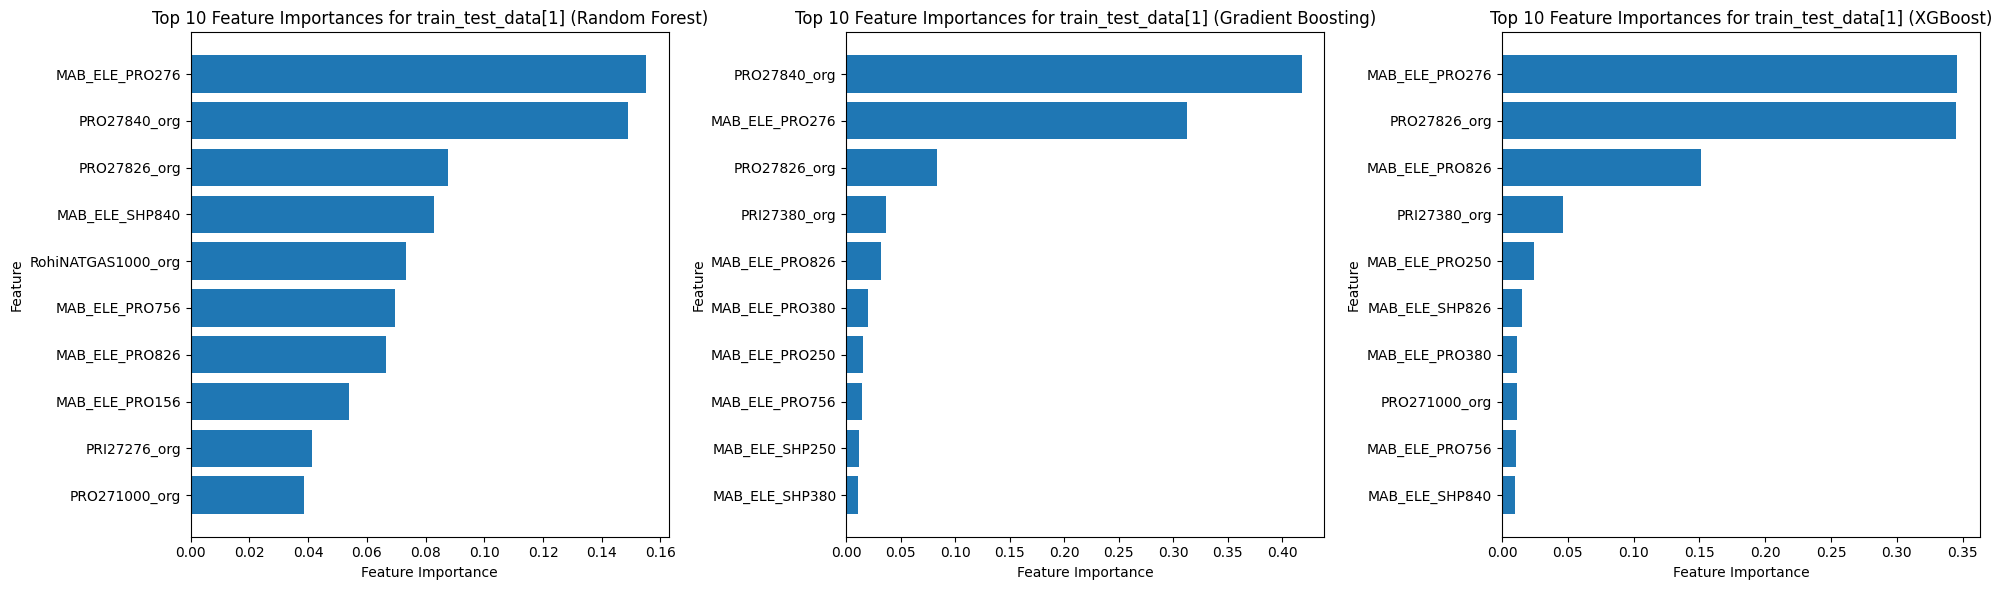

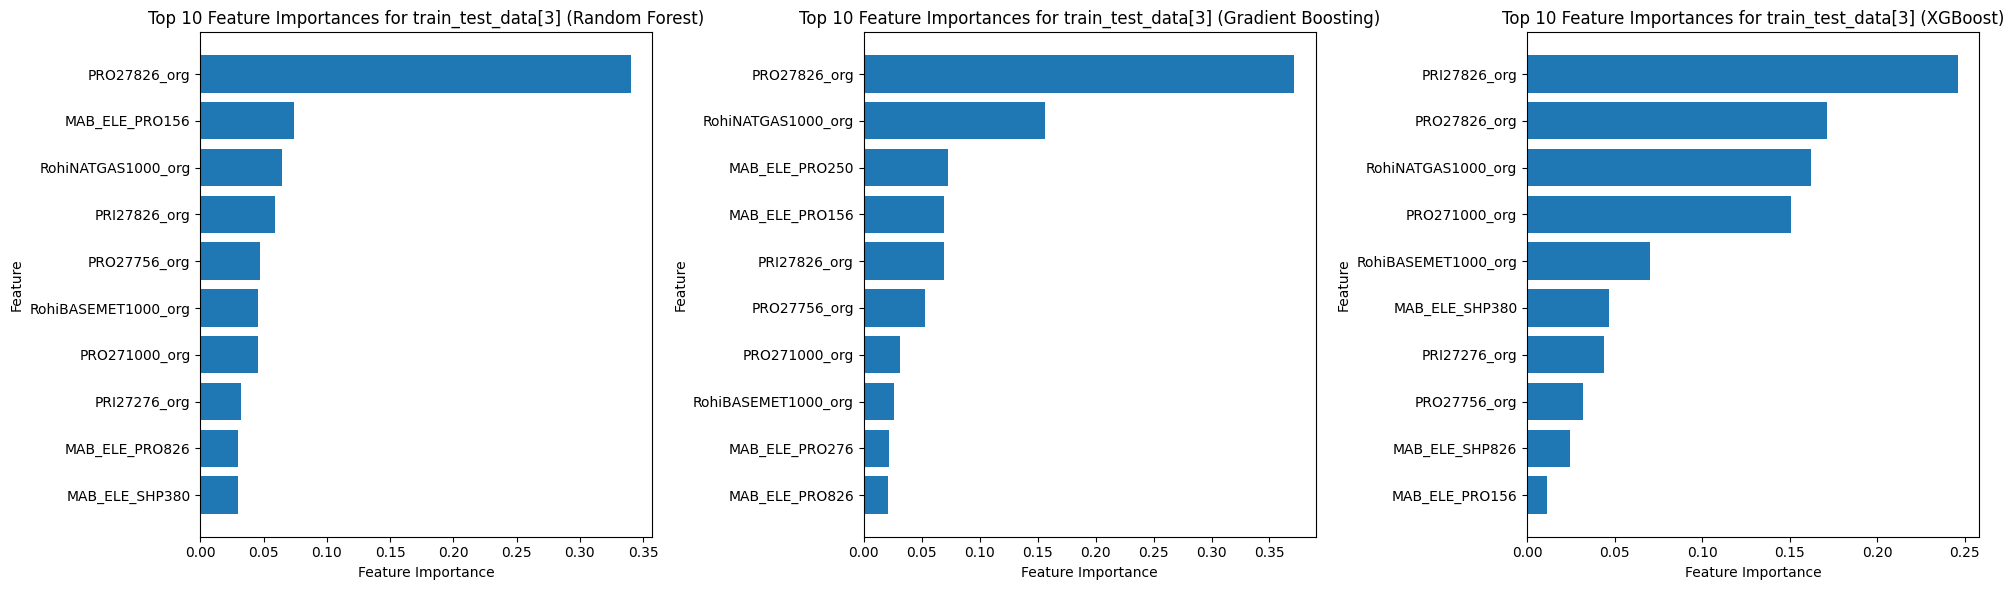

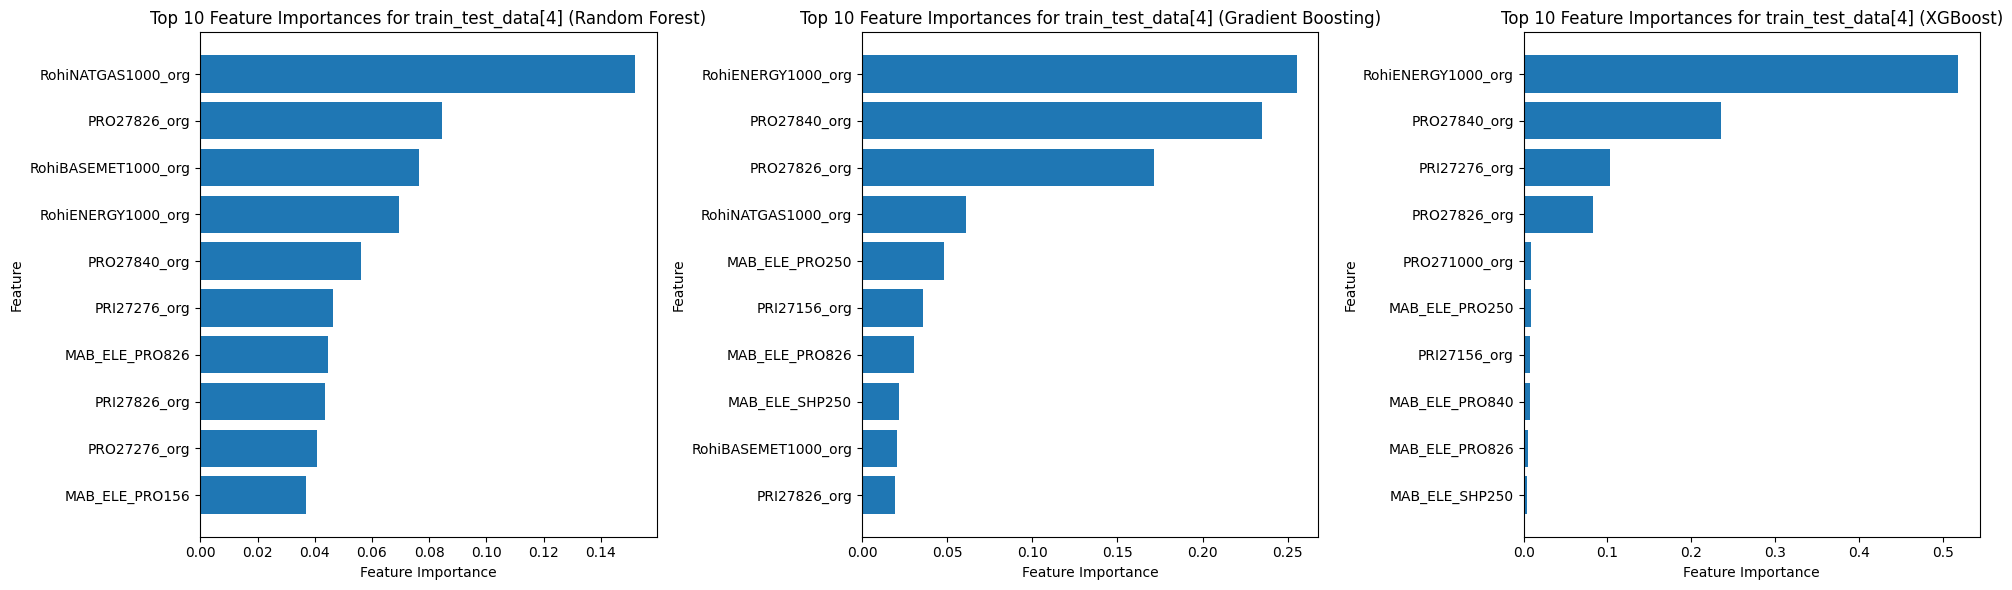

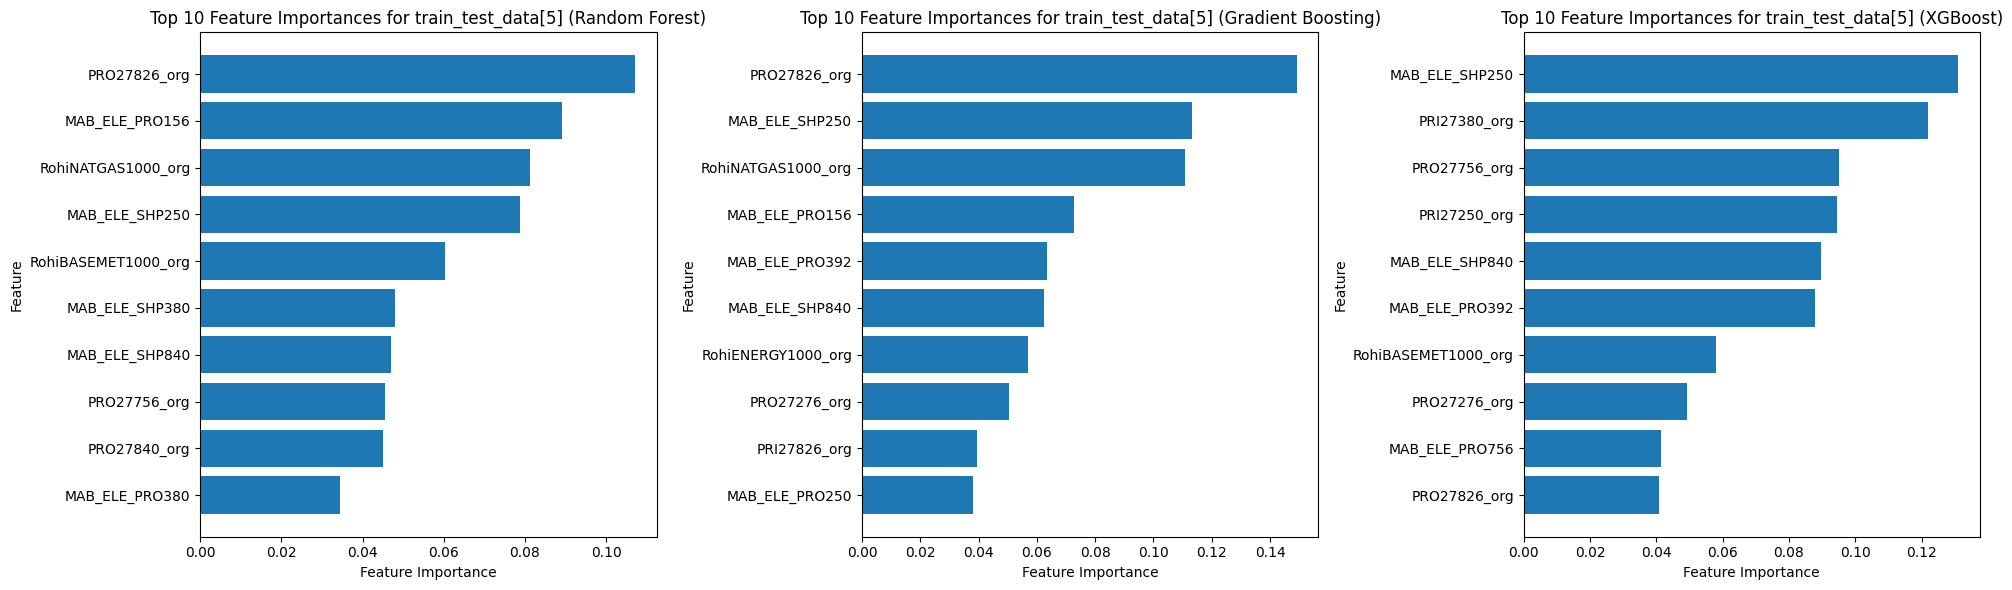

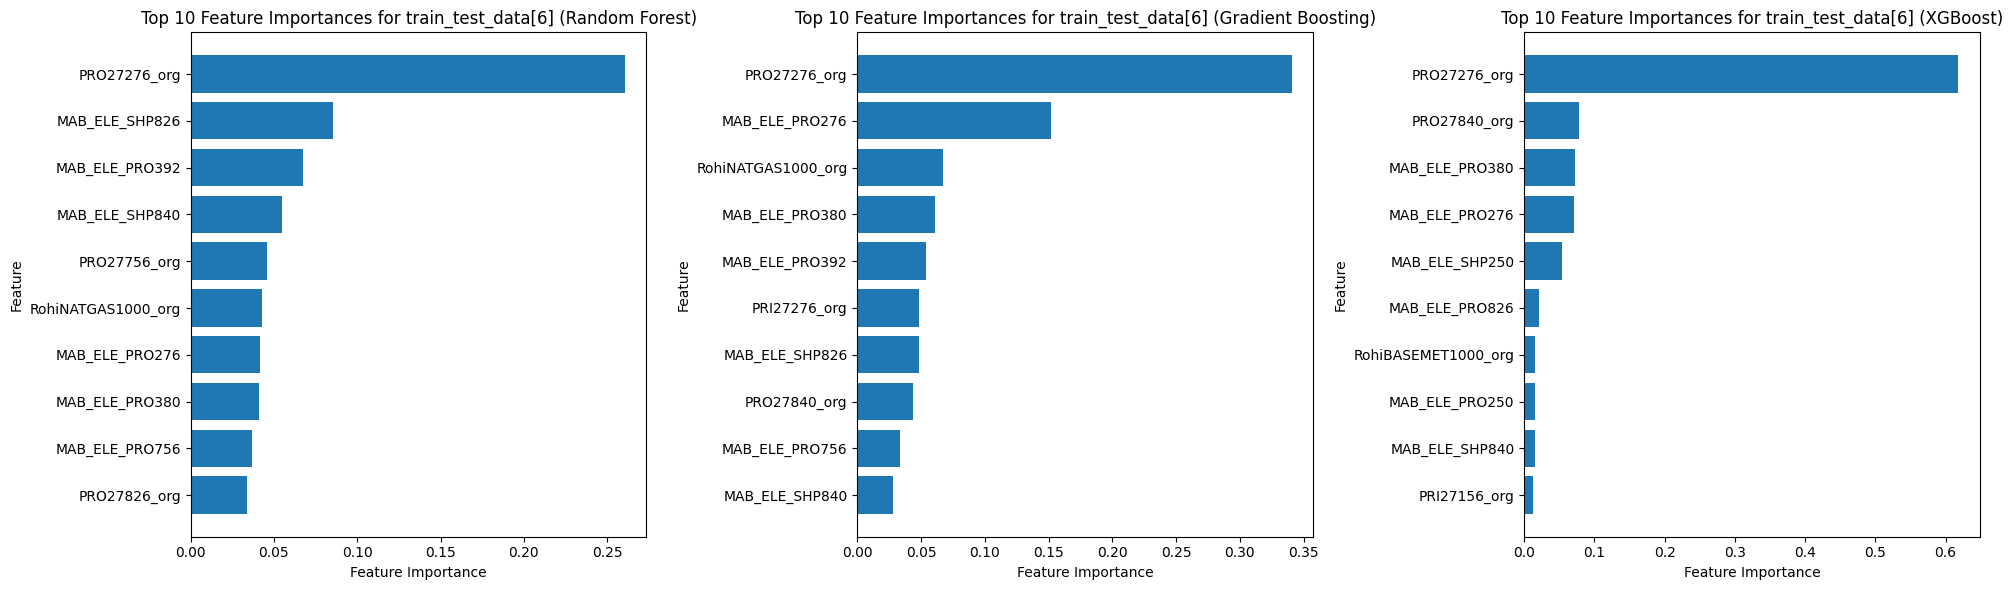

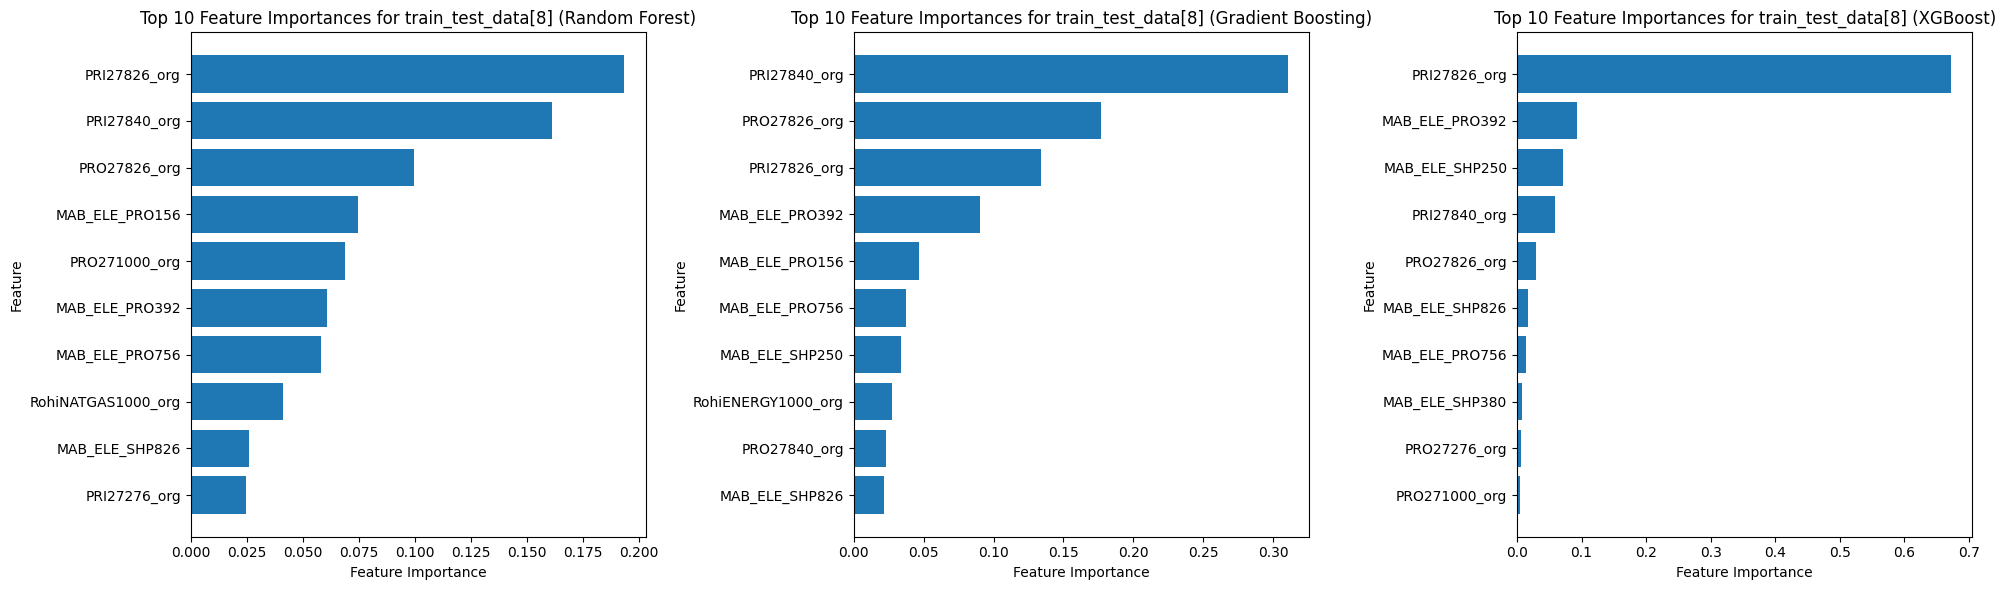

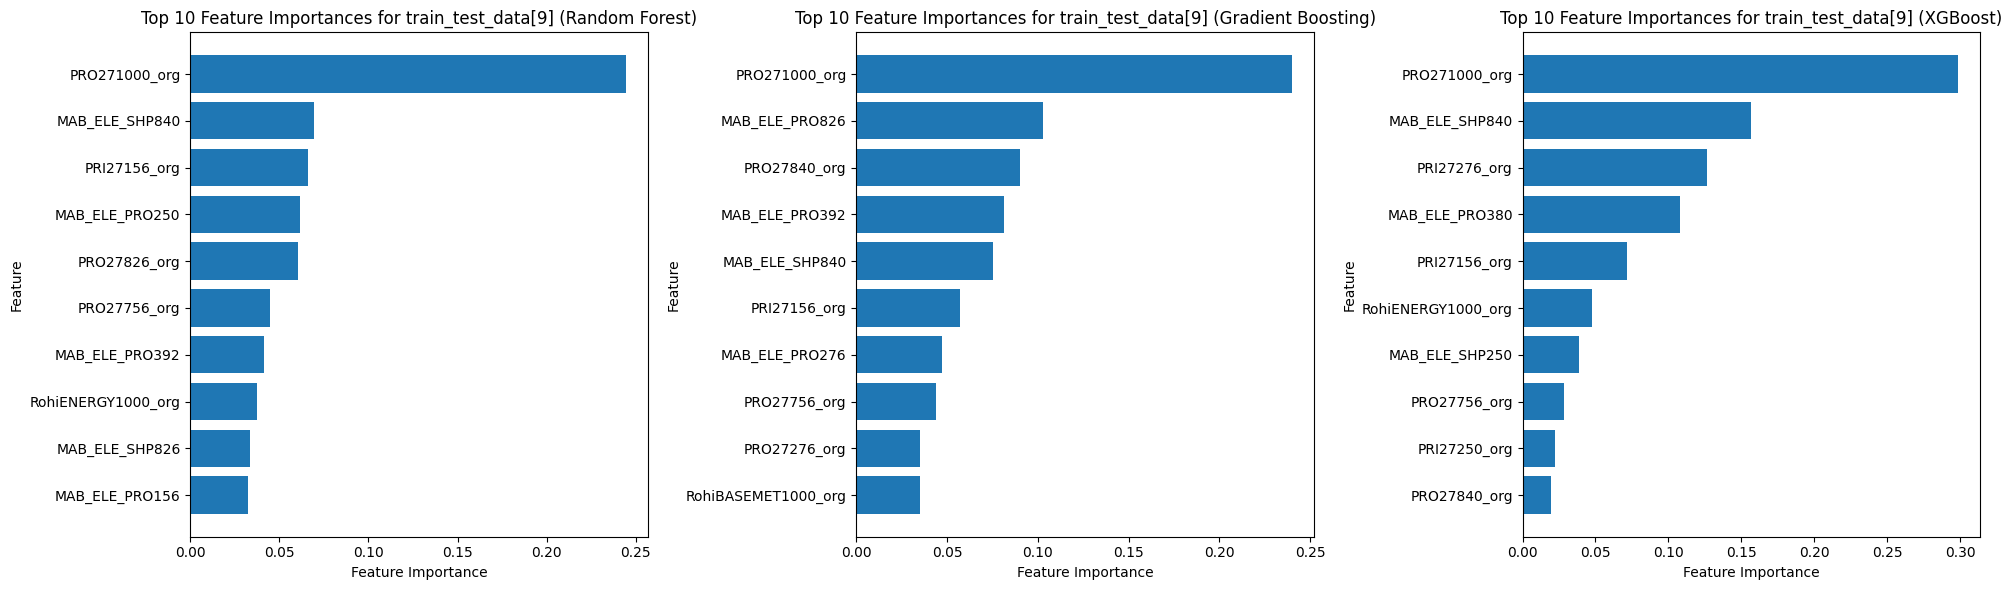

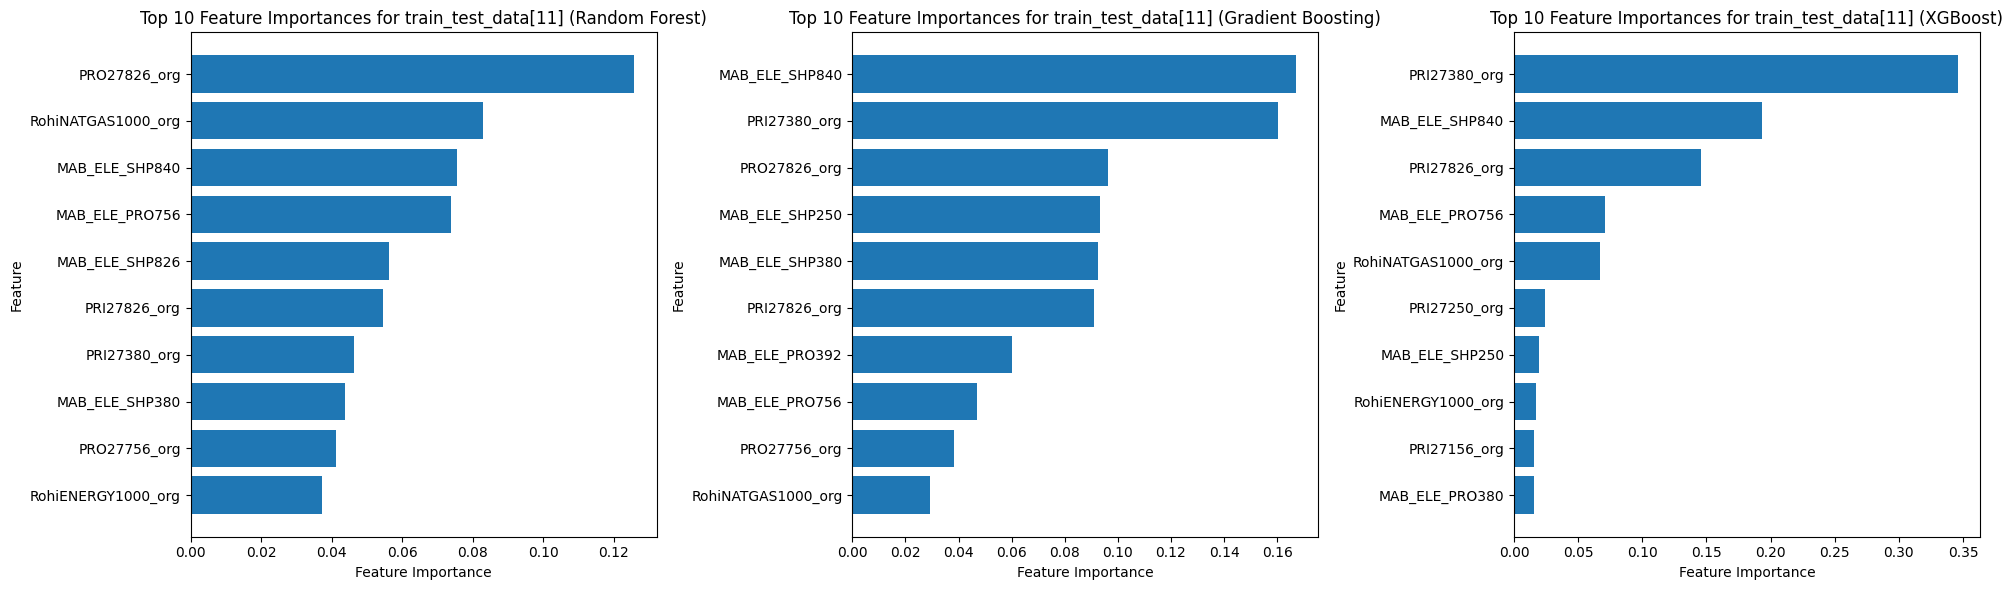

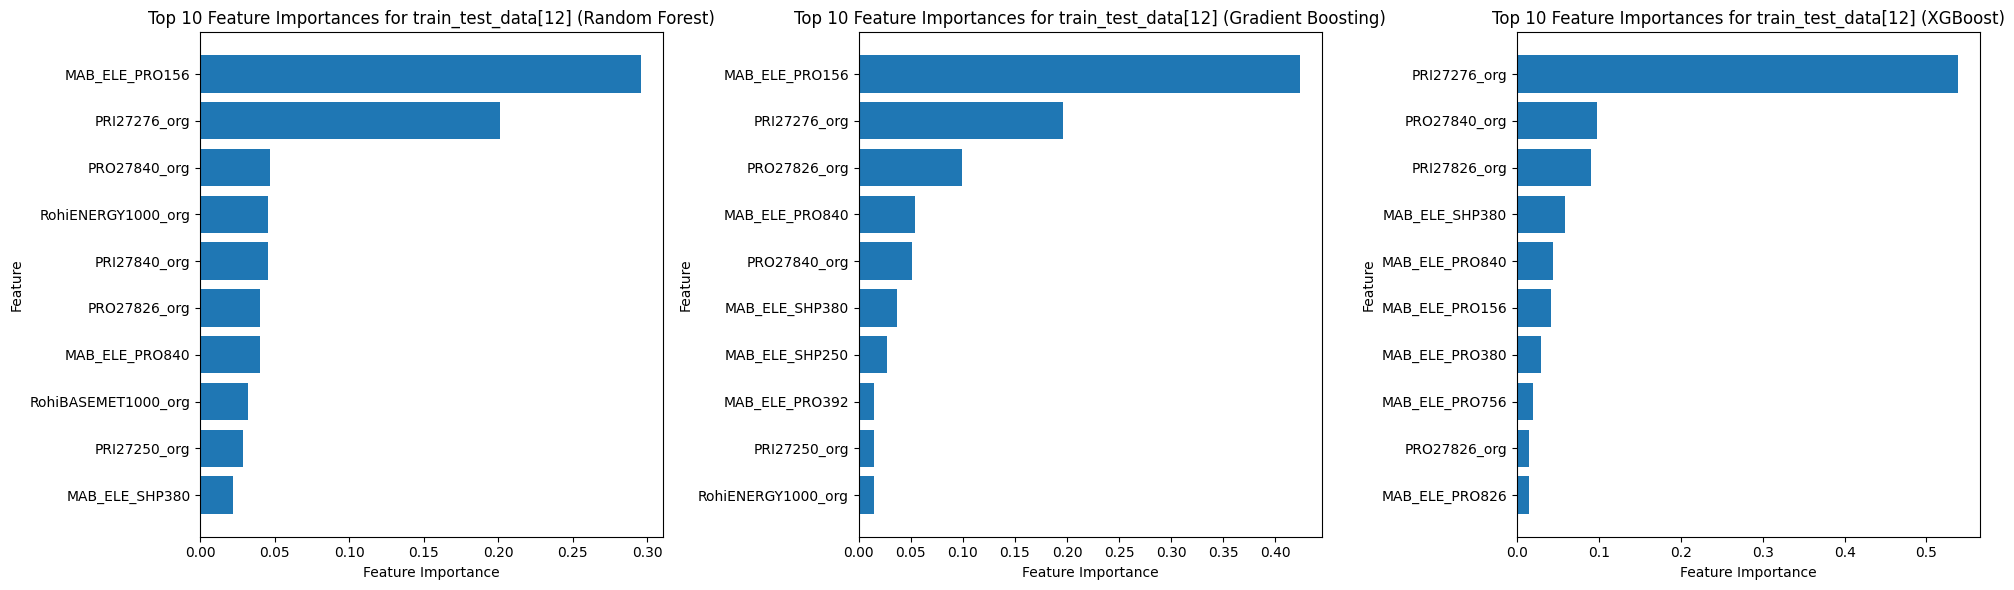

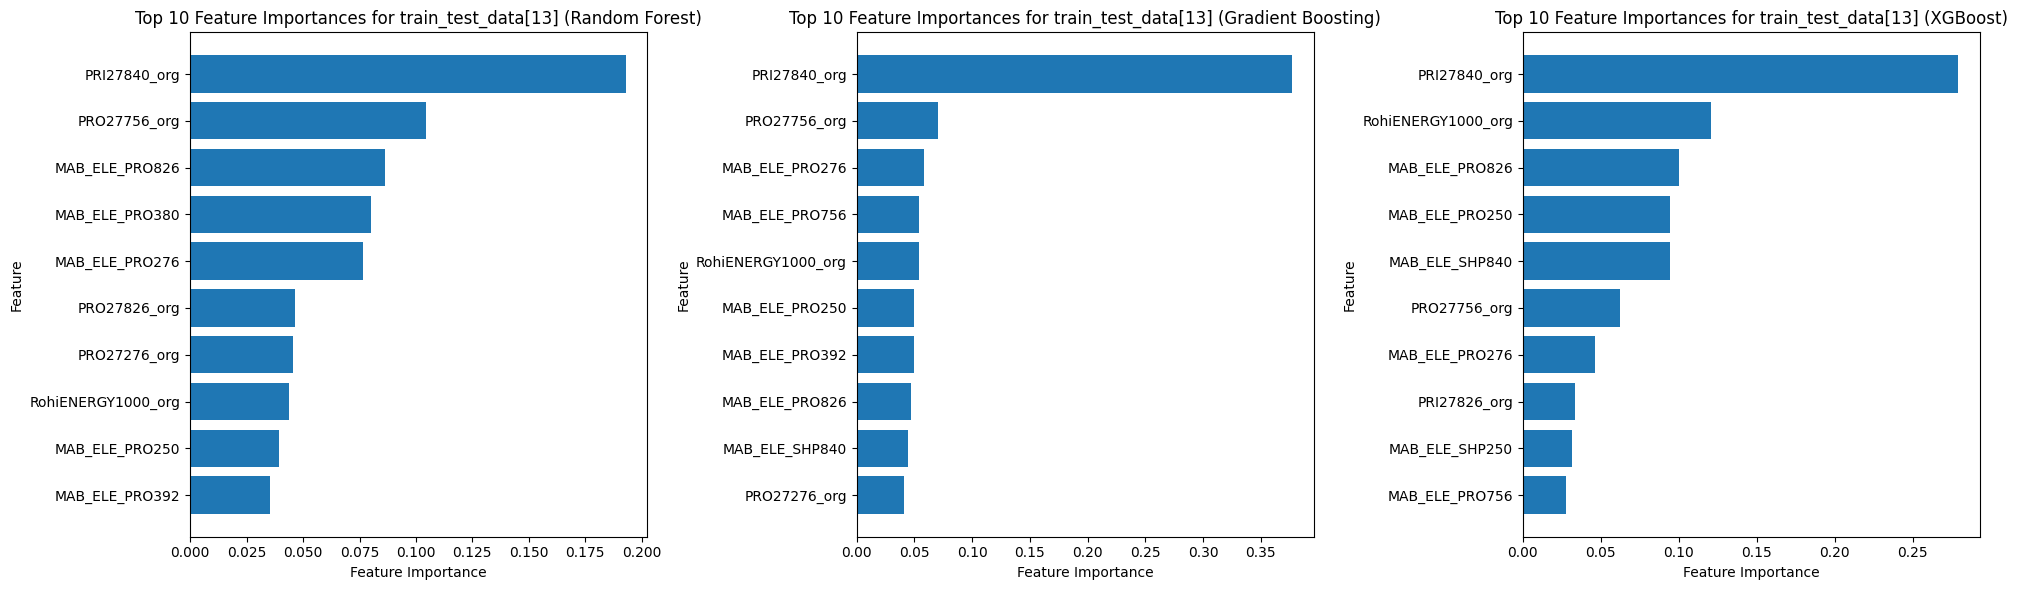

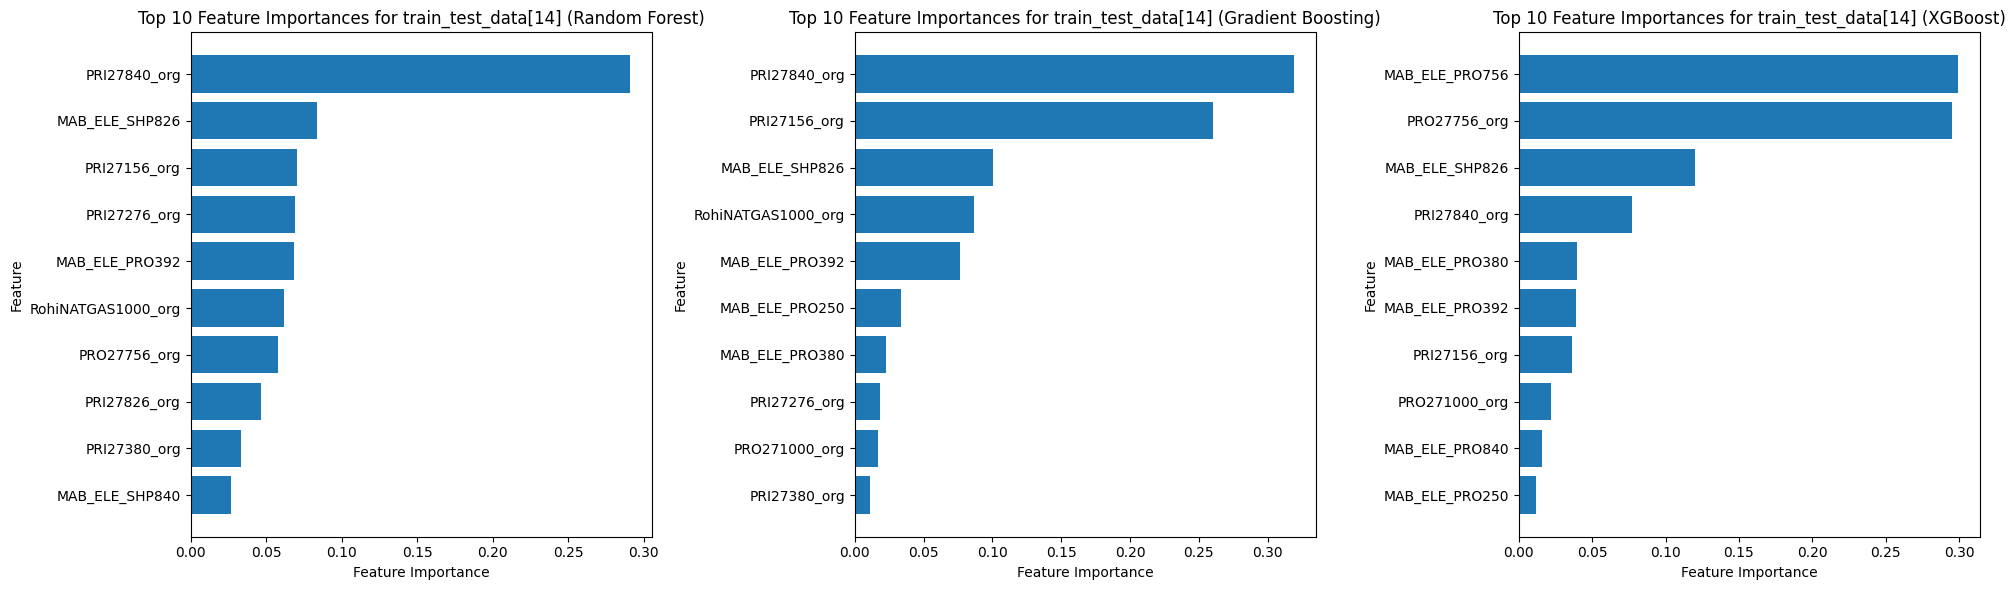

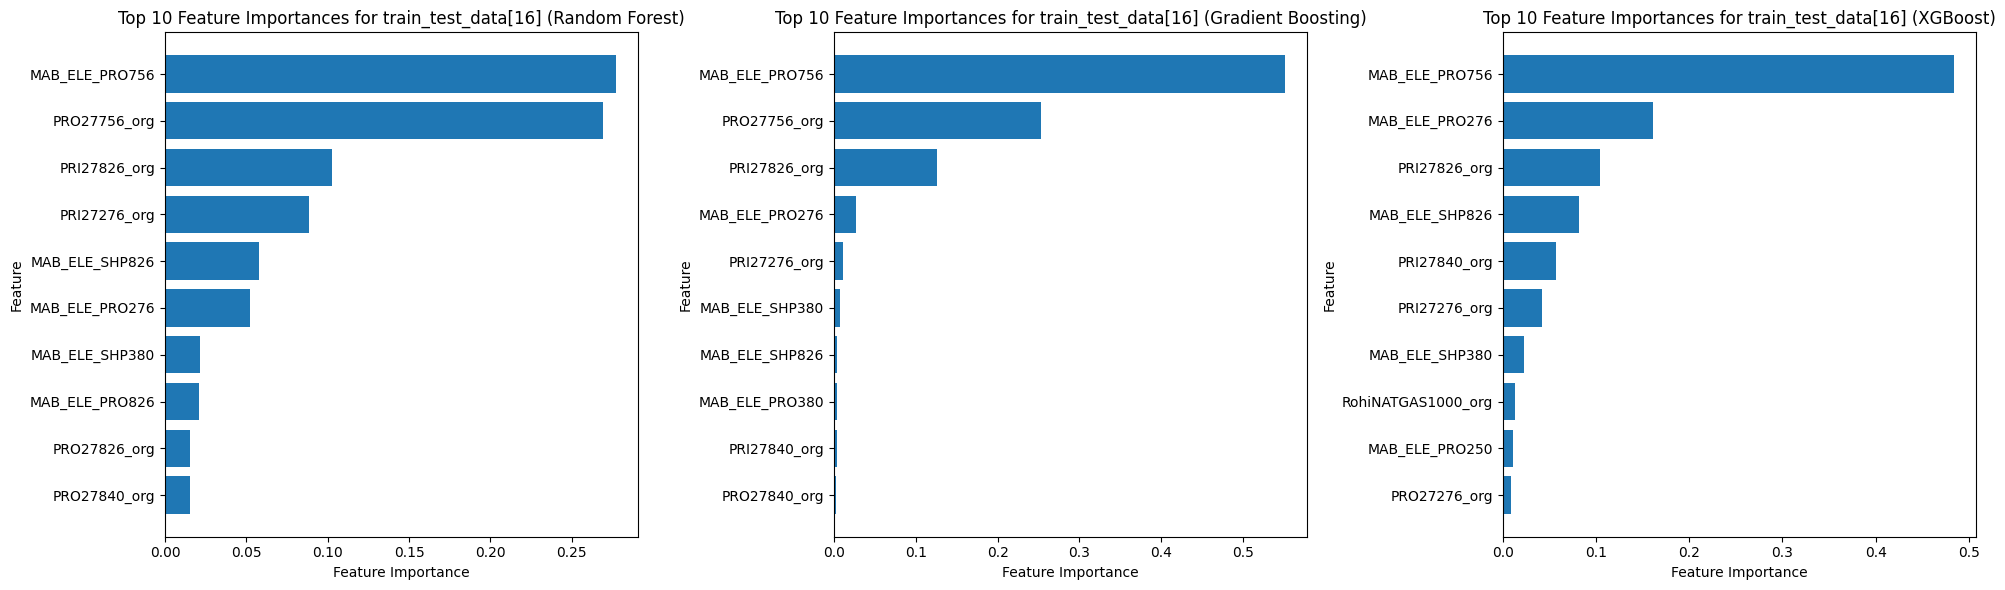

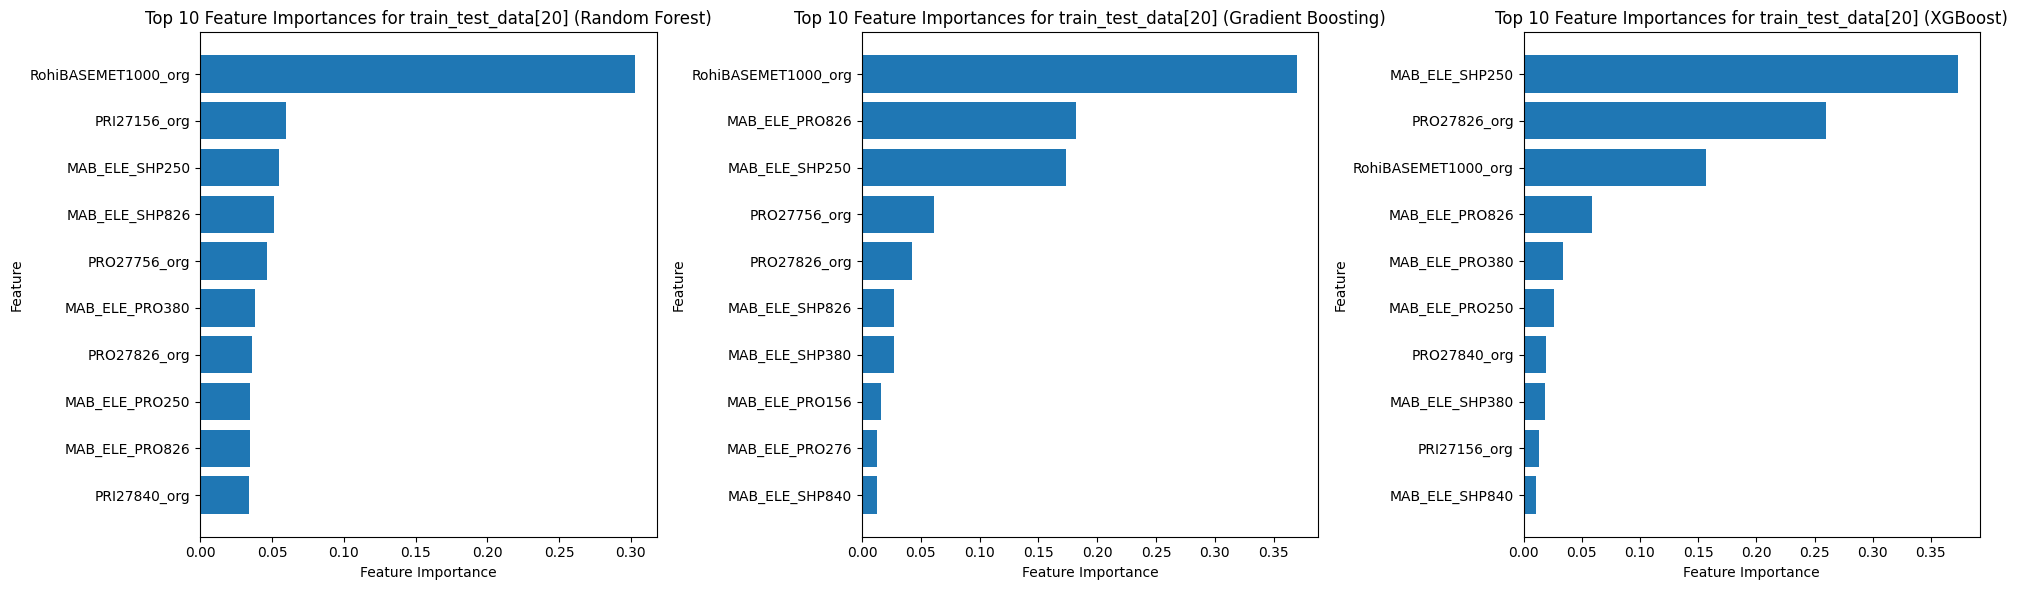

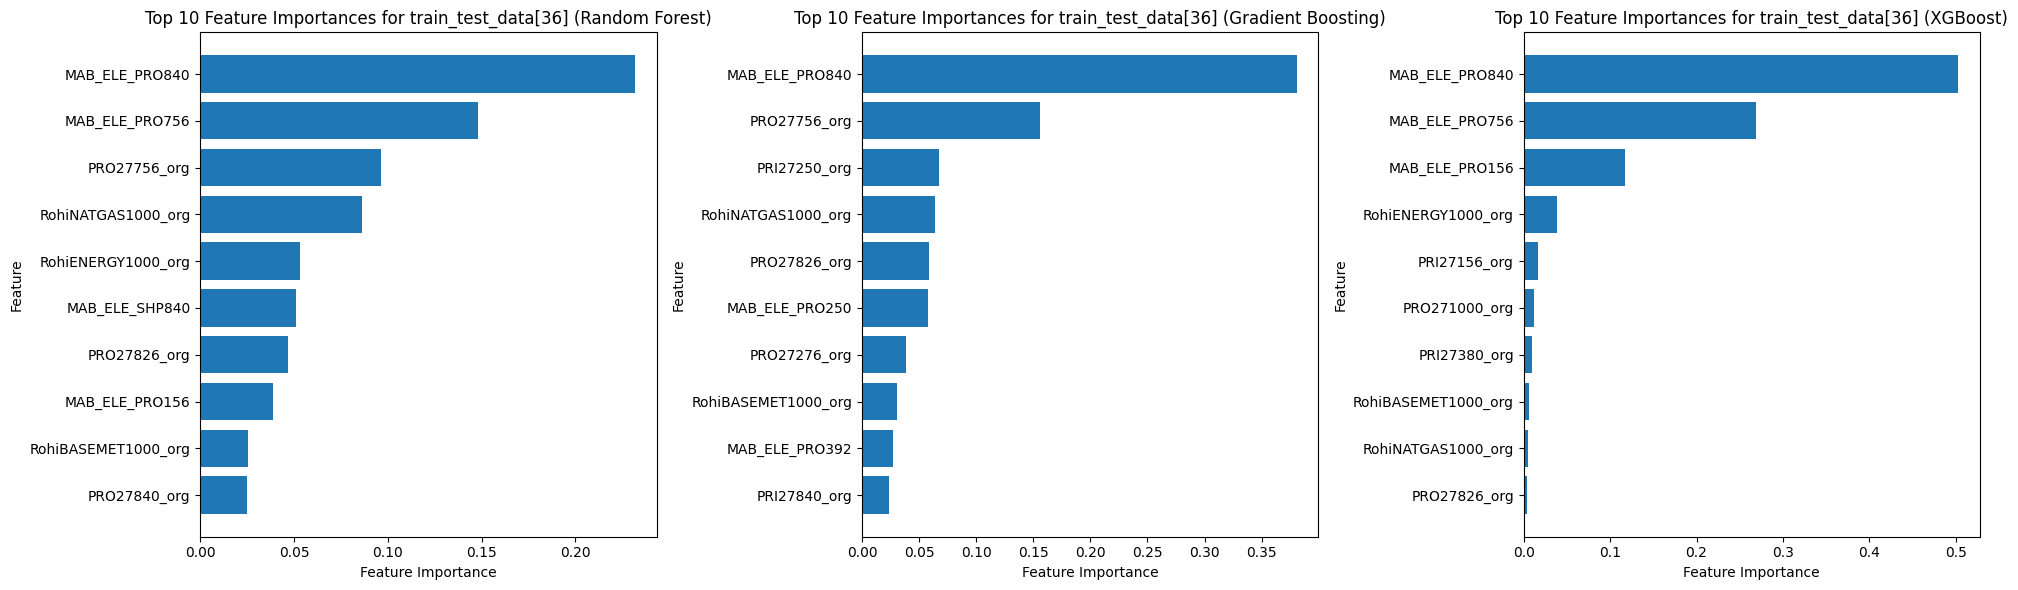

In [228]:
# Initialize Random Forest, Gradient Boosting, and XGBoost models
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Iterate over each DataFrame in train_test_data
for key, data in train_test_data.items():
    # Get the training data for the original features
    X_train = data['original']['train'].drop(columns=['Sales_CPI_€'])
    y_train = data['original']['train']['Sales_CPI_€']
    
    # Fit the models
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Get feature importances
    rf_importances = rf.feature_importances_
    gb_importances = gb.feature_importances_
    xgb_importances = xgb.feature_importances_
    
    # Sort and get indices of top 10 features for each model
    top_rf_indices = np.argsort(rf_importances)[::-1][:10]
    top_gb_indices = np.argsort(gb_importances)[::-1][:10]
    top_xgb_indices = np.argsort(xgb_importances)[::-1][:10]
    
    # Plot feature importances side by side for Random Forest, Gradient Boosting, and XGBoost
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Random Forest plot
    axes[0].barh(X_train.columns[top_rf_indices][::-1], rf_importances[top_rf_indices][::-1])
    axes[0].set_xlabel('Feature Importance')
    axes[0].set_ylabel('Feature')
    axes[0].set_title(f'Top 10 Feature Importances for train_test_data[{key}] (Random Forest)')
    
    # Gradient Boosting plot
    axes[1].barh(X_train.columns[top_gb_indices][::-1], gb_importances[top_gb_indices][::-1])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_ylabel('Feature')
    axes[1].set_title(f'Top 10 Feature Importances for train_test_data[{key}] (Gradient Boosting)')
    
    # XGBoost plot
    axes[2].barh(X_train.columns[top_xgb_indices][::-1], xgb_importances[top_xgb_indices][::-1])
    axes[2].set_xlabel('Feature Importance')
    axes[2].set_ylabel('Feature')
    axes[2].set_title(f'Top 10 Feature Importances for train_test_data[{key}] (XGBoost)')
    
    plt.tight_layout()
    plt.show()


Taking into account the 3 models above for the feature importance, it was decided that it should only be kept the top 5 common features for each merged_dfs[x] based on their occurrences among the top features obtained from Random Forest, Gradient Boosting, and XGBoost models.

In [229]:
# Initialize an empty dictionary to store the occurrences of each feature for each product
product_feature_occurrences = {}

# Iterate over each DataFrame in train_test_data
for key, data in train_test_data.items():
    # Get the training data for the original and lag features
    X_train = data['original']['train'].drop(columns=['Sales_CPI_€'])
    y_train = data['original']['train']['Sales_CPI_€']
    
    # Fit the models
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Get feature importances
    rf_importances = rf.feature_importances_
    gb_importances = gb.feature_importances_
    xgb_importances = xgb.feature_importances_
    
    # Sort and get indices of top 10 features for each model
    top_rf_indices = np.argsort(rf_importances)[::-1][:10]
    top_gb_indices = np.argsort(gb_importances)[::-1][:10]
    top_xgb_indices = np.argsort(xgb_importances)[::-1][:10]
    
    # Combine top features from all models
    all_top_indices = np.concatenate([top_rf_indices, top_gb_indices, top_xgb_indices])
    
    # Count occurrences of each feature for the current product
    for idx in all_top_indices:
        feature_name = X_train.columns[idx]
        if key not in product_feature_occurrences:
            product_feature_occurrences[key] = {}
        product_feature_occurrences[key][feature_name] = product_feature_occurrences[key].get(feature_name, 0) + 1

# Initialize an empty dictionary to store the top common features for each product
top_common_features_per_product = {}

# Iterate over each product's feature occurrences
for product, feature_occurrences in product_feature_occurrences.items():
    # Sort features by their occurrences
    sorted_features = sorted(feature_occurrences.items(), key=lambda x: x[1], reverse=True)
    
    # Keep only the top 5 common features for the current product
    top_common_features_per_product[product] = [feat[0] for feat in sorted_features[:5]]

# Print the top common features for each product
for product, top_common_features in top_common_features_per_product.items():
    print(f"Top 5 common features for product {product}:")
    for feature in top_common_features:
        print(feature)
    print()


Top 5 common features for product 1:
MAB_ELE_PRO276
PRO27826_org
MAB_ELE_PRO756
MAB_ELE_PRO826
PRO27840_org

Top 5 common features for product 3:
PRO27826_org
MAB_ELE_PRO156
RohiNATGAS1000_org
PRI27826_org
PRO27756_org

Top 5 common features for product 4:
PRO27826_org
RohiENERGY1000_org
PRO27840_org
MAB_ELE_PRO826
RohiNATGAS1000_org

Top 5 common features for product 5:
PRO27826_org
MAB_ELE_SHP250
MAB_ELE_SHP840
MAB_ELE_PRO156
RohiNATGAS1000_org

Top 5 common features for product 6:
PRO27276_org
MAB_ELE_SHP840
MAB_ELE_PRO276
MAB_ELE_PRO380
MAB_ELE_SHP826

Top 5 common features for product 8:
PRI27826_org
PRI27840_org
PRO27826_org
MAB_ELE_PRO392
MAB_ELE_PRO756

Top 5 common features for product 9:
PRO271000_org
MAB_ELE_SHP840
PRI27156_org
PRO27756_org
MAB_ELE_PRO392

Top 5 common features for product 11:
RohiNATGAS1000_org
MAB_ELE_SHP840
MAB_ELE_PRO756
PRI27826_org
PRI27380_org

Top 5 common features for product 12:
MAB_ELE_PRO156
PRI27276_org
PRO27840_org
PRO27826_org
MAB_ELE_PRO840



Some of the Group Products only have 4 features in common among the top 10 features obtained from Random Forest, Gradient Boosting, and XGBoost models.

In [230]:
# Update each merged_df with only the common top features and 'Sales_CPI_€'
for number, data in train_test_data.items():
    # Extract common top features for the current merged_df
    common_top_features = top_common_features_per_product.get(number, [])
    
    # Add 'Sales_CPI_€' to the list of common top features
    common_top_features.append('Sales_CPI_€')

    # Update test set columns to keep only those present in the train set
    train_cols = data['original']['train'][common_top_features].columns
    test_cols = data['original']['test'].columns
    common_cols = train_cols.intersection(test_cols)
    train_test_data[number]['original']['train'] = data['original']['train'][common_cols]
    train_test_data[number]['original']['test'] = data['original']['test'][common_cols]


In [231]:
train_test_data[1]['original']['train'].head()

MAB_ELE_PRO276  PRO27826_org  MAB_ELE_PRO756  MAB_ELE_PRO826  \
Date                                                                       
2018-10-01      124.227879    118.670791      109.077781      113.659322   
2018-11-01      127.404132    120.467019      112.241491      115.088417   
2018-12-01      120.518565    105.378705      115.405201      101.556108   
2019-01-01      104.776326    107.174933      109.621788      101.799754   
2019-02-01      109.597012    110.647640      103.838375      103.495768   

            PRO27840_org   Sales_CPI_€  
Date                                    
2018-10-01    112.853256  3.577403e+07  
2018-11-01    113.145294  5.063649e+06  
2018-12-01    111.823624  3.732127e+07  
2019-01-01    109.499725  2.709040e+07  
2019-02-01    110.835655  3.413209e+07

In [232]:
train_test_data[1]['original']['test'].head()

MAB_ELE_PRO276  PRO27826_org  MAB_ELE_PRO756  MAB_ELE_PRO826  \
Date                                                                       
2021-08-01      100.880844    116.395569       96.965037       99.283383   
2021-09-01      115.043611    130.525896      100.643938      115.833771   
2021-10-01      108.420507    117.832552      102.663969       99.135838   
2021-11-01      115.951560    127.053188      104.683999      109.856972   
2021-12-01      118.103281    121.065762      106.704029      101.273544   

            PRO27840_org   Sales_CPI_€  
Date                                    
2021-08-01    109.376541  3.758170e+07  
2021-09-01    109.221512  3.765748e+07  
2021-10-01    113.523598  4.639578e+07  
2021-11-01    113.067886  3.572583e+07  
2021-12-01    109.624107  3.554572e+07

Save locally each df from merged_dfs

In [233]:
# Create directories to save the DataFrames for train and test
train_output_dir = 'products_original_train'
test_output_dir = 'products_original_test'
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Iterate through train_test_data and save DataFrames for each train and test set
for number, data in train_test_data.items():
    # Define the filenames based on the key
    train_filename = os.path.join(train_output_dir, f'Product_{number}_train.csv')
    test_filename = os.path.join(test_output_dir, f'Product_{number}_test.csv')
    
    # Save the training and test DataFrames to CSV files
    data['original']['train'].to_csv(train_filename, index=True)
    data['original']['test'].to_csv(test_filename, index=True)
    
    print(f'Saved Product_{number}_train.csv and Product_{number}_test.csv')

Saved Product_1_train.csv and Product_1_test.csv
Saved Product_3_train.csv and Product_3_test.csv
Saved Product_4_train.csv and Product_4_test.csv
Saved Product_5_train.csv and Product_5_test.csv
Saved Product_6_train.csv and Product_6_test.csv
Saved Product_8_train.csv and Product_8_test.csv
Saved Product_9_train.csv and Product_9_test.csv
Saved Product_11_train.csv and Product_11_test.csv
Saved Product_12_train.csv and Product_12_test.csv
Saved Product_13_train.csv and Product_13_test.csv
Saved Product_14_train.csv and Product_14_test.csv
Saved Product_16_train.csv and Product_16_test.csv
Saved Product_20_train.csv and Product_20_test.csv
Saved Product_36_train.csv and Product_36_test.csv


### Feature Selection using Random Forest, Gradient Boosting and XGBoost - with Lag features 

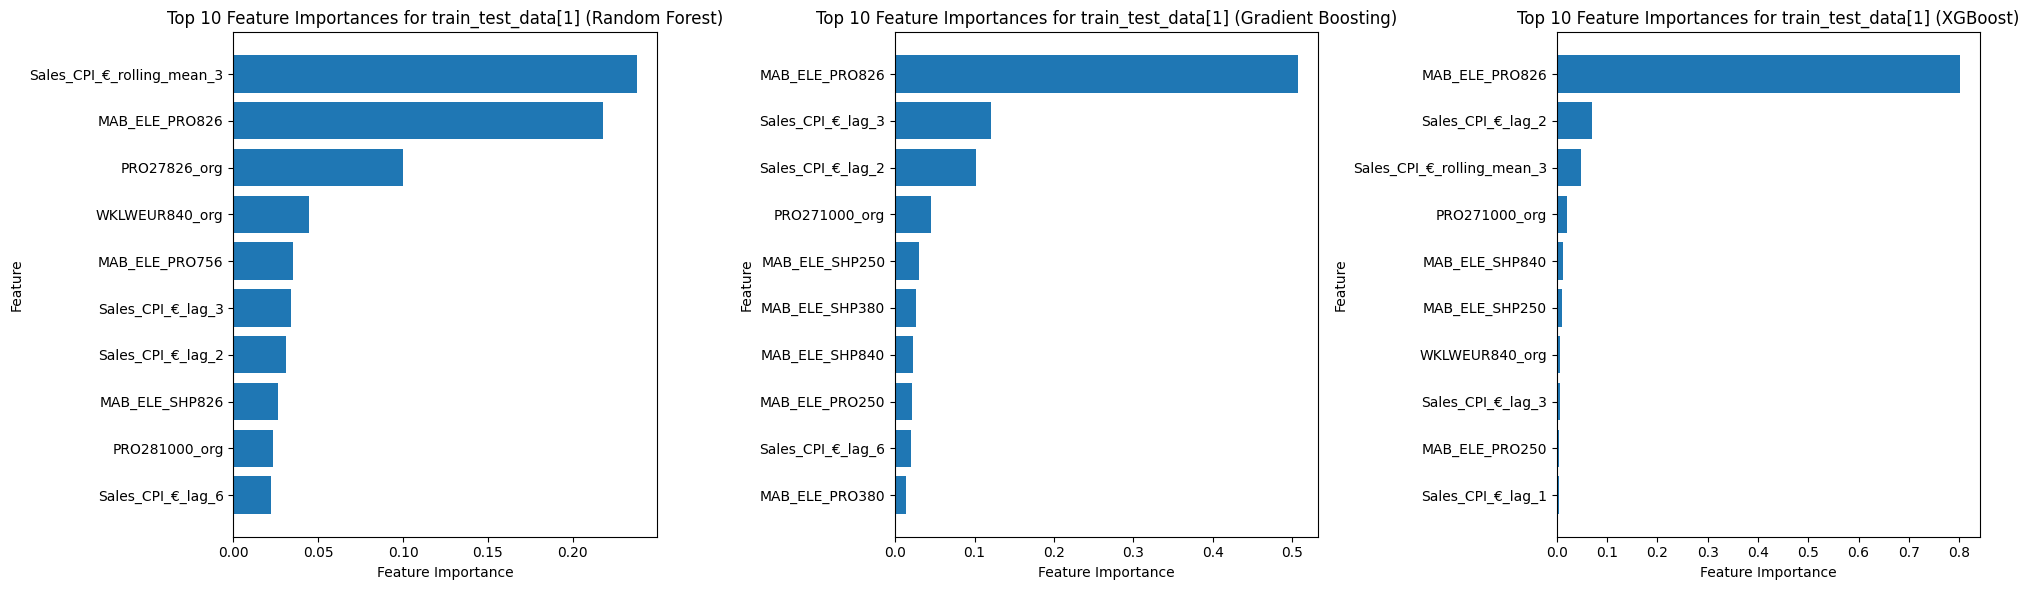

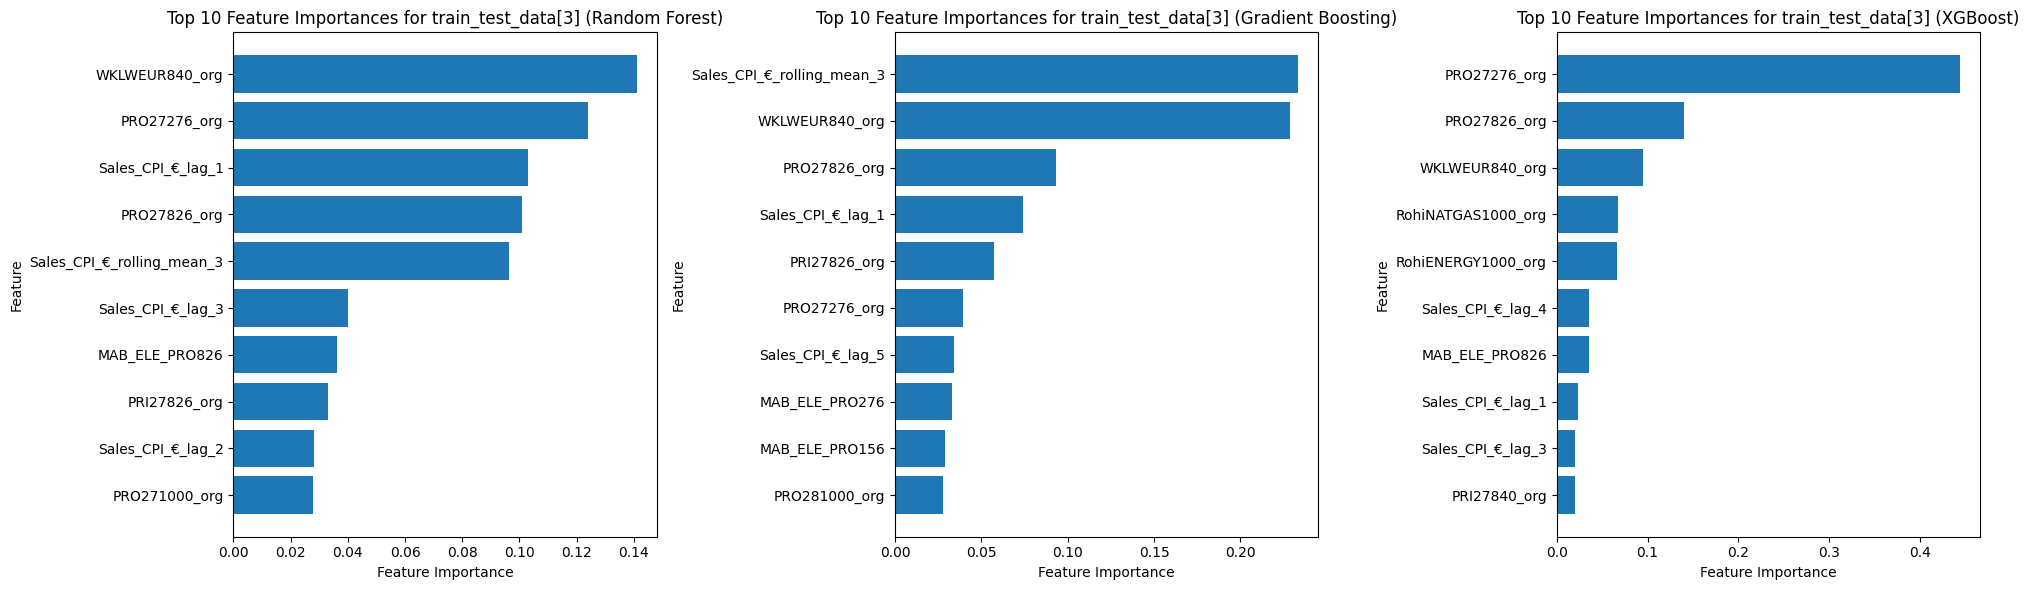

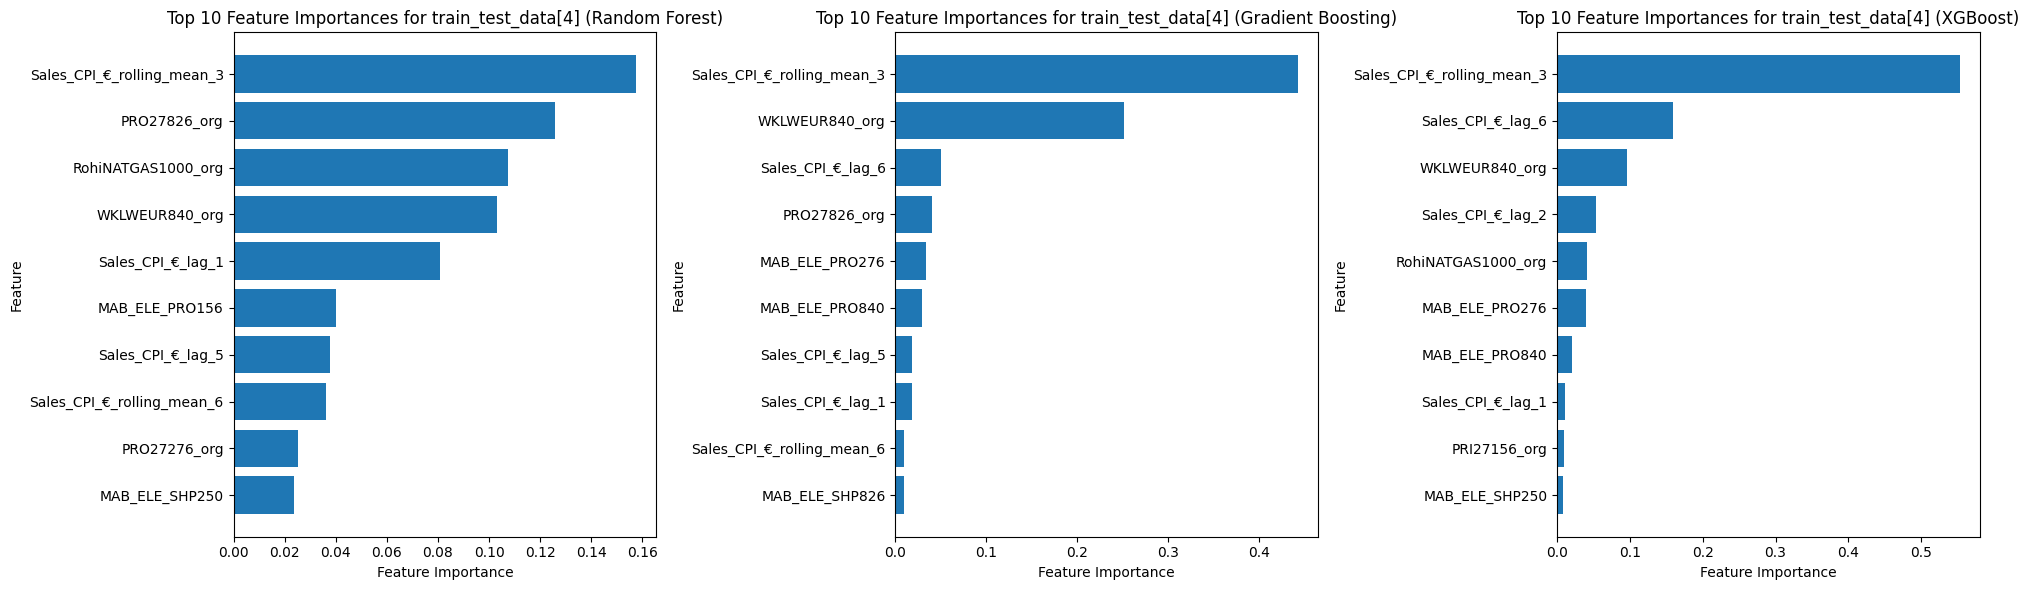

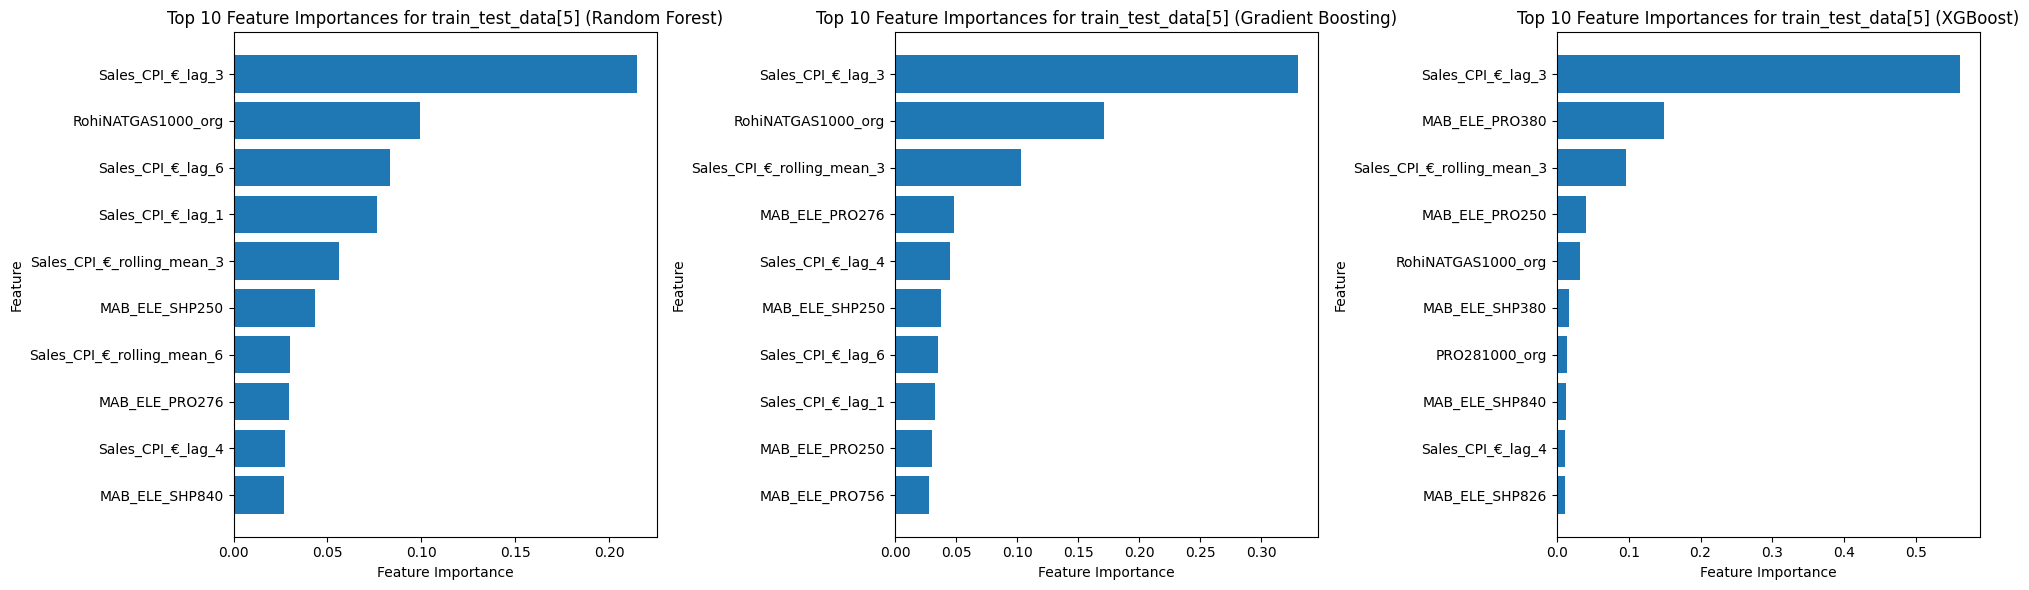

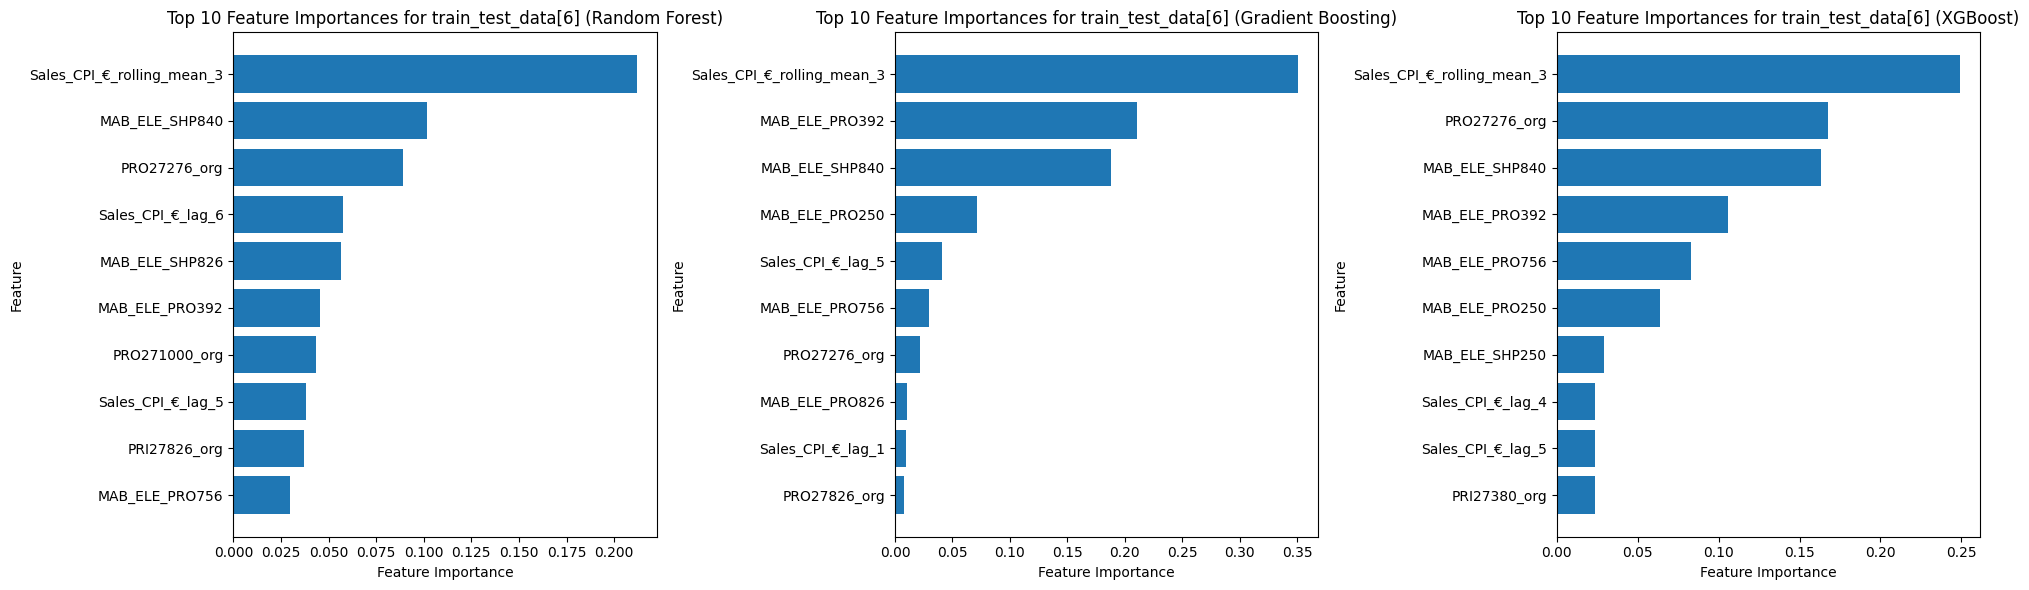

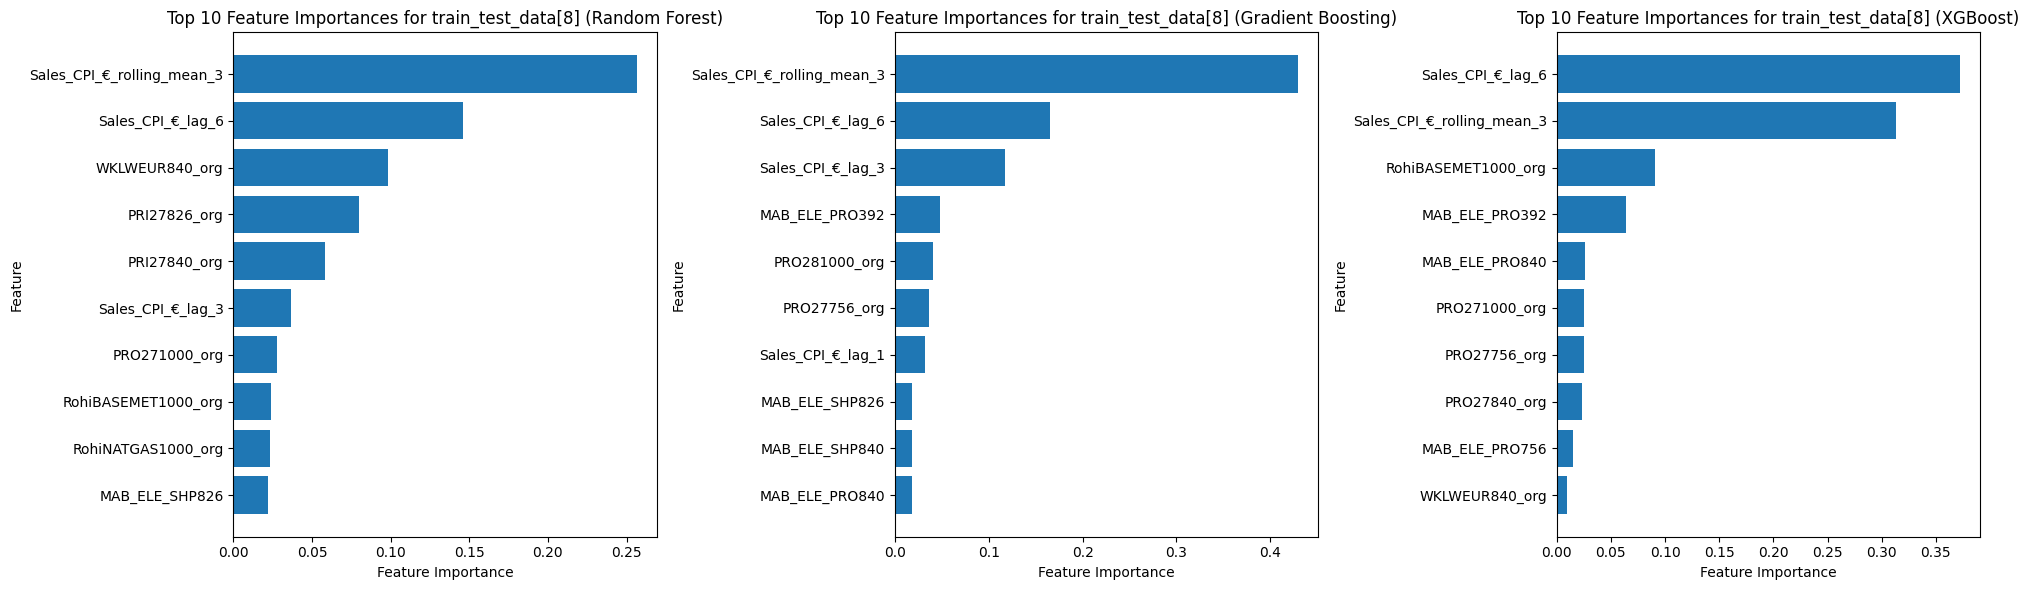

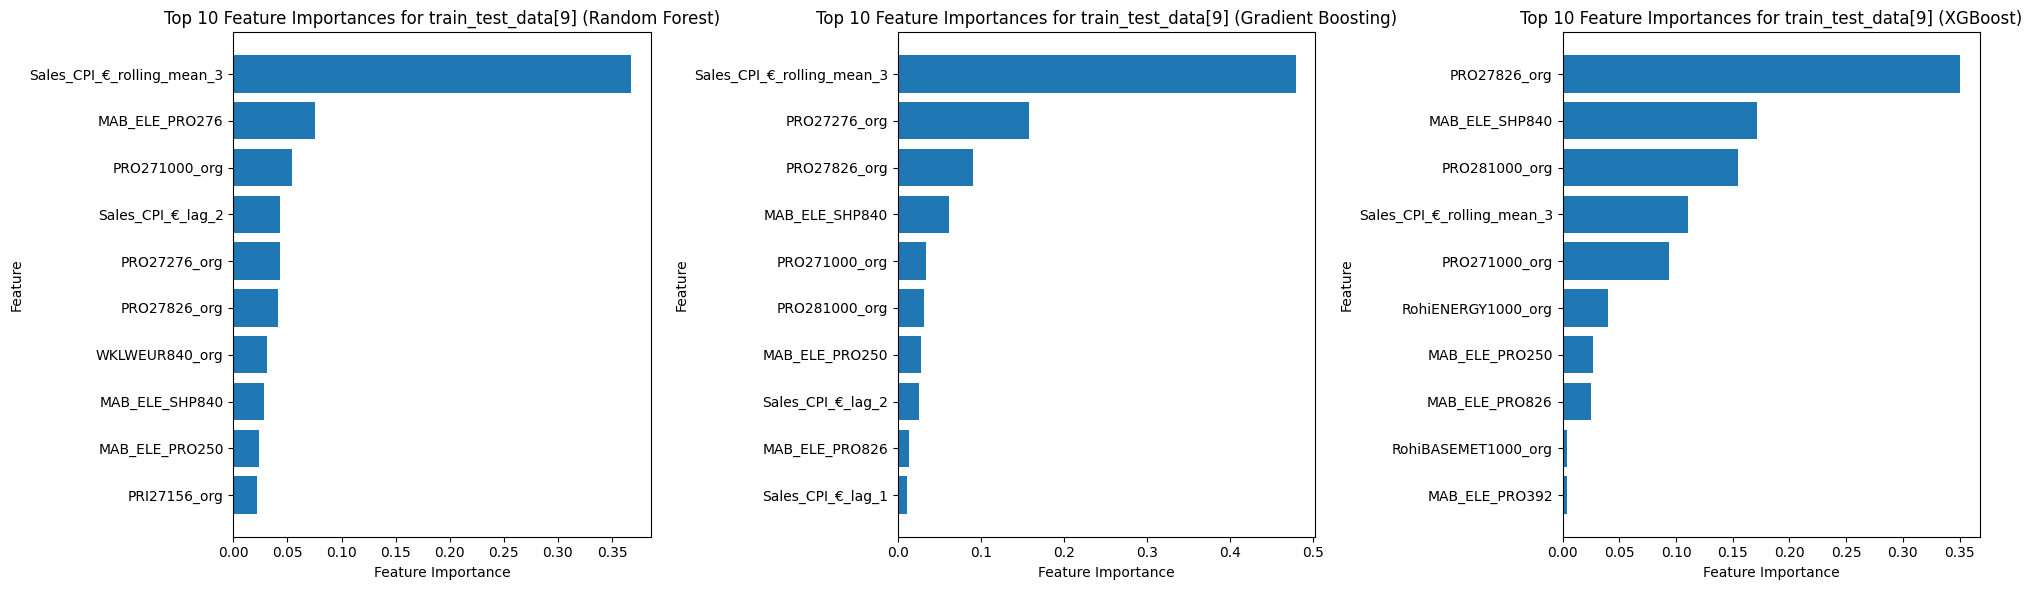

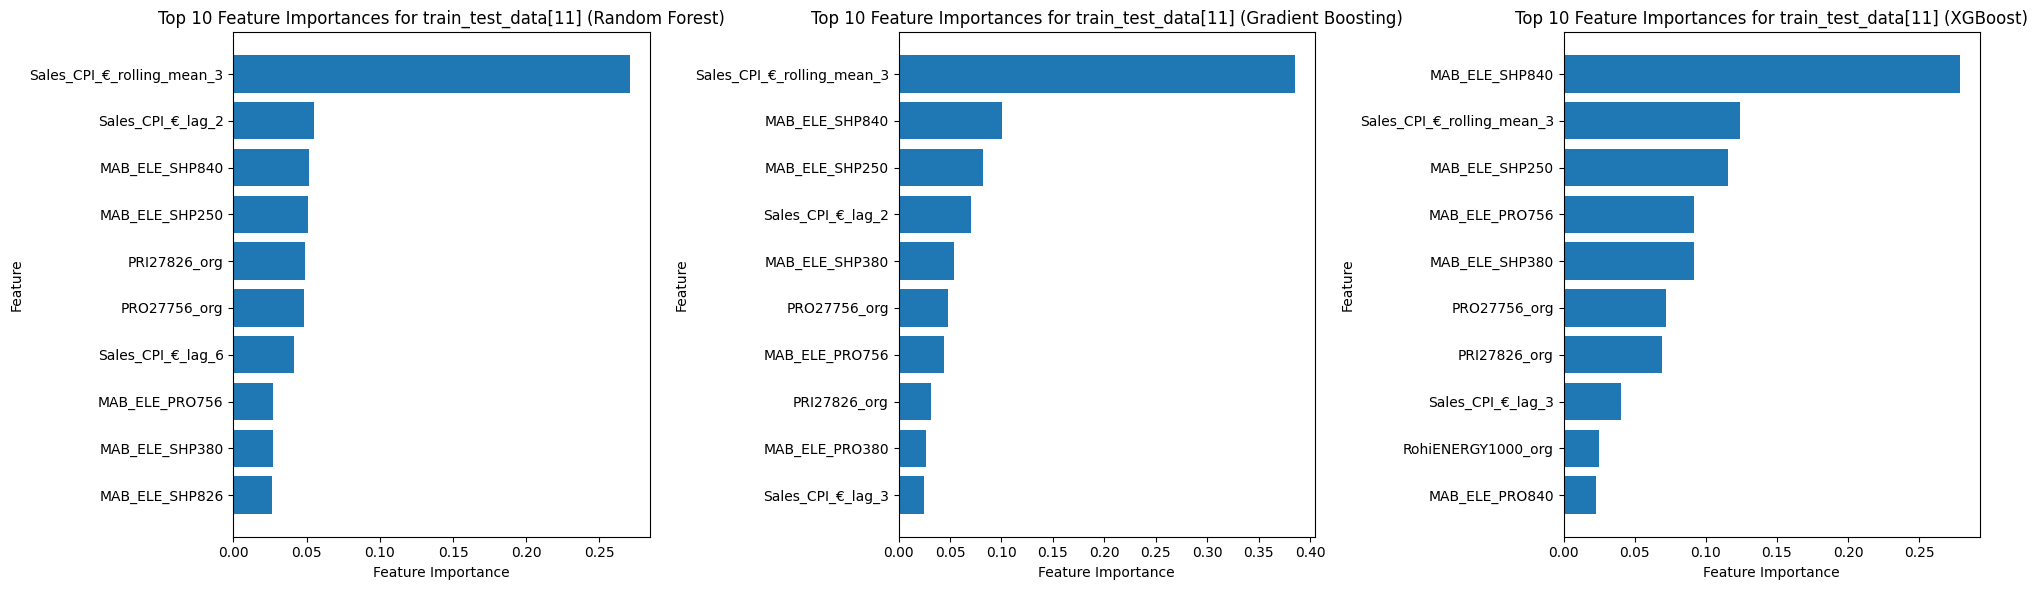

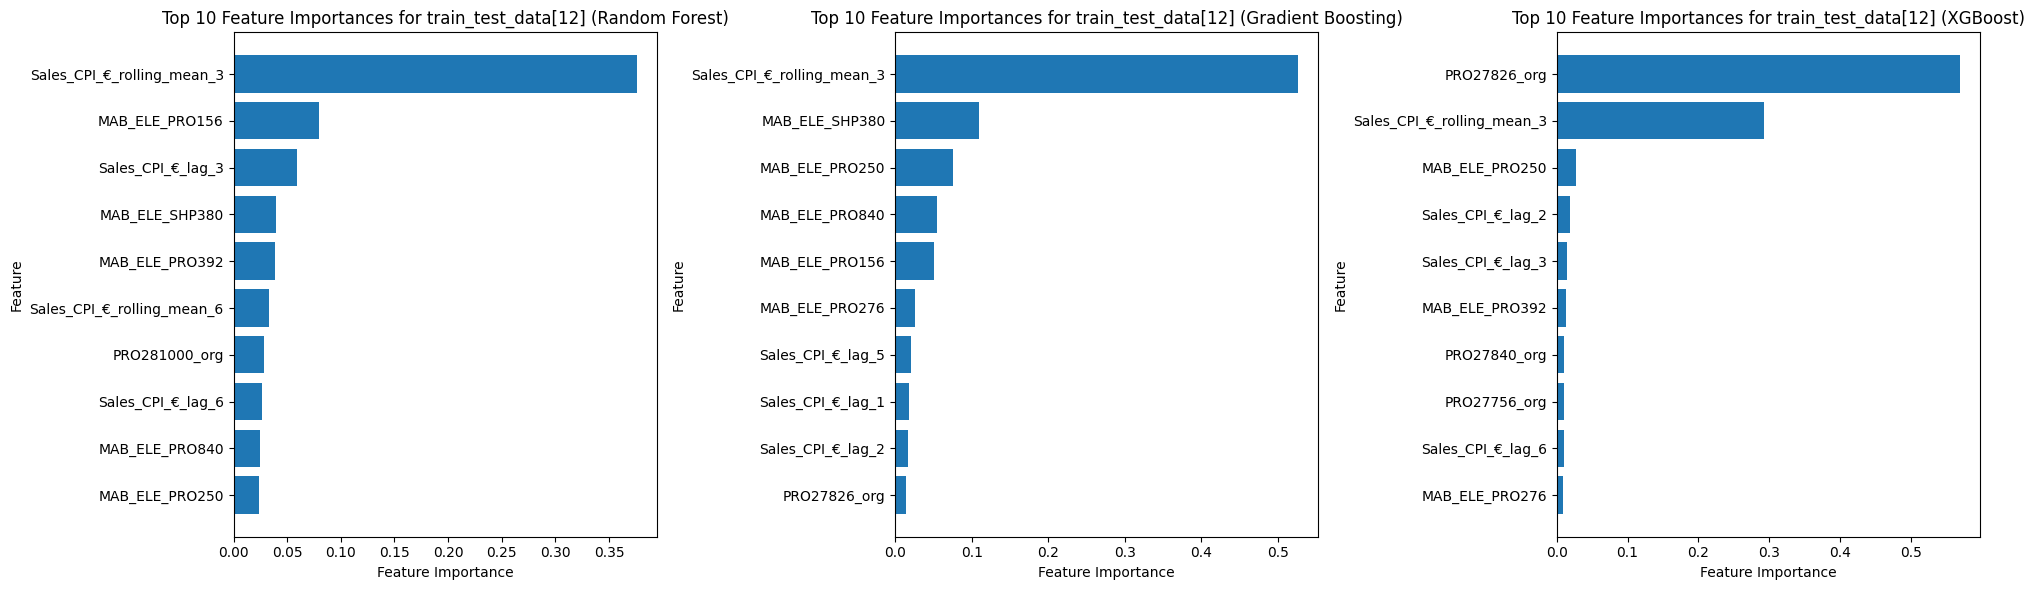

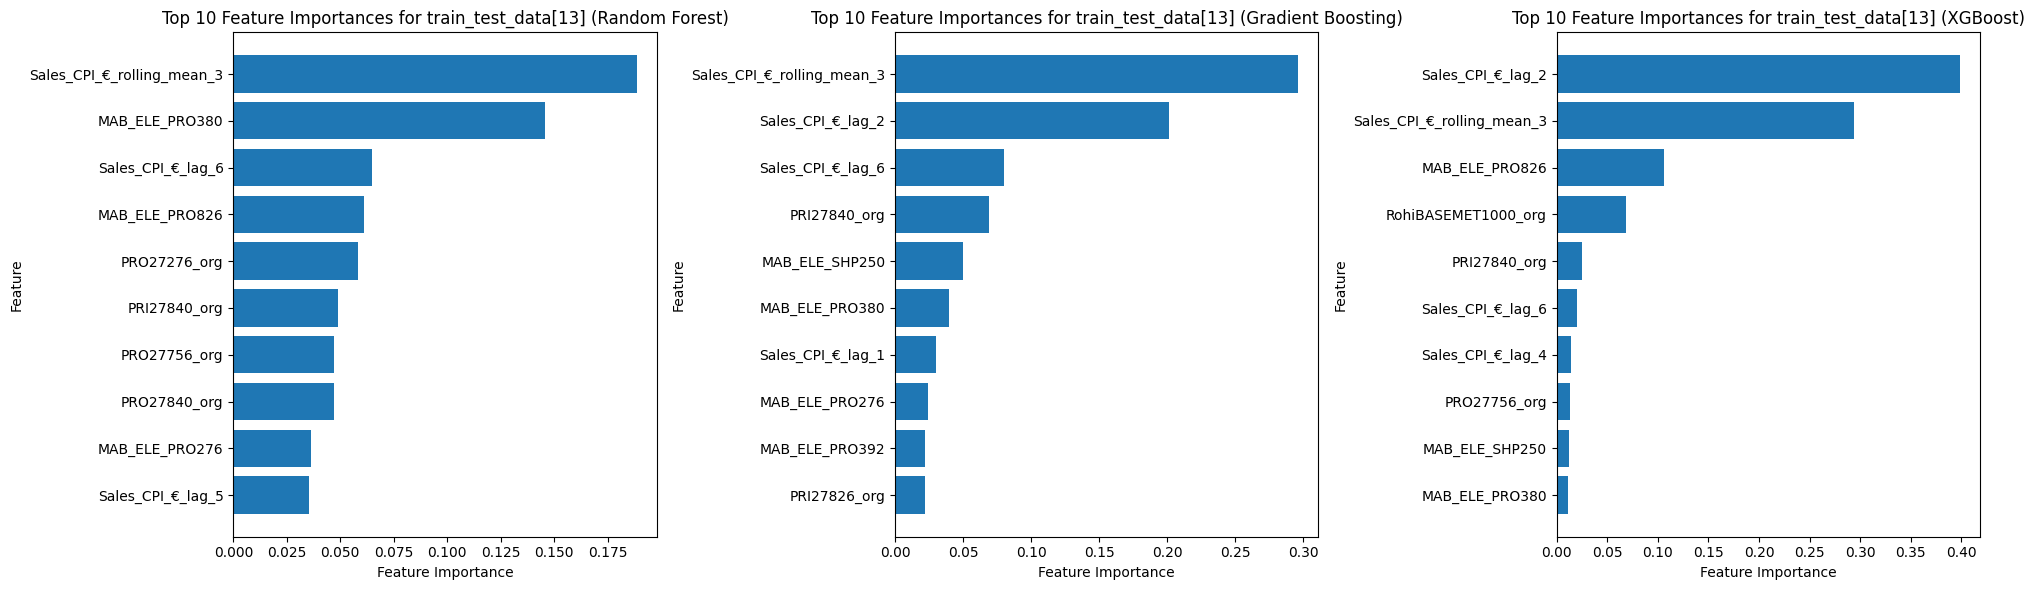

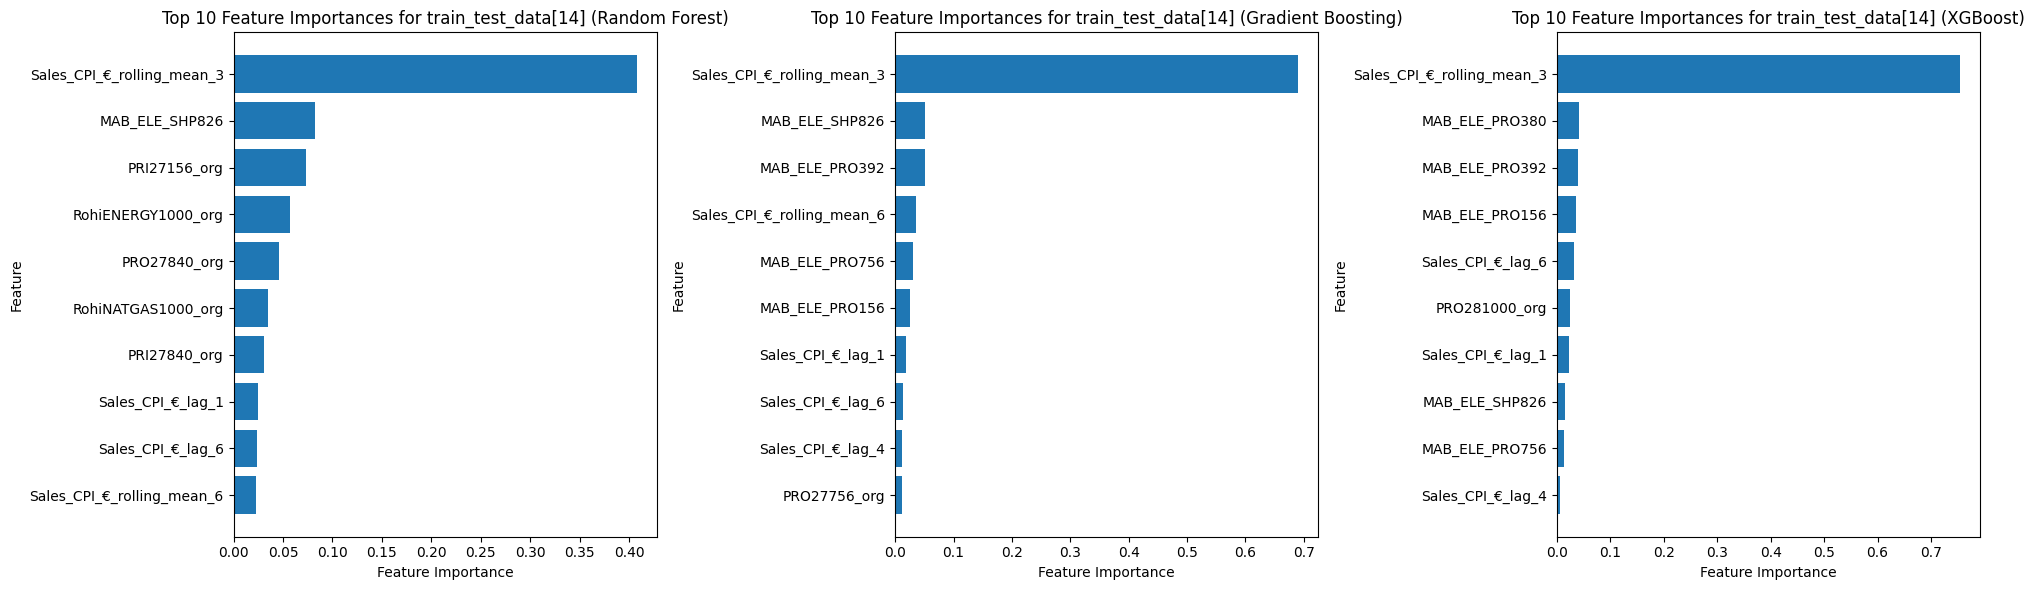

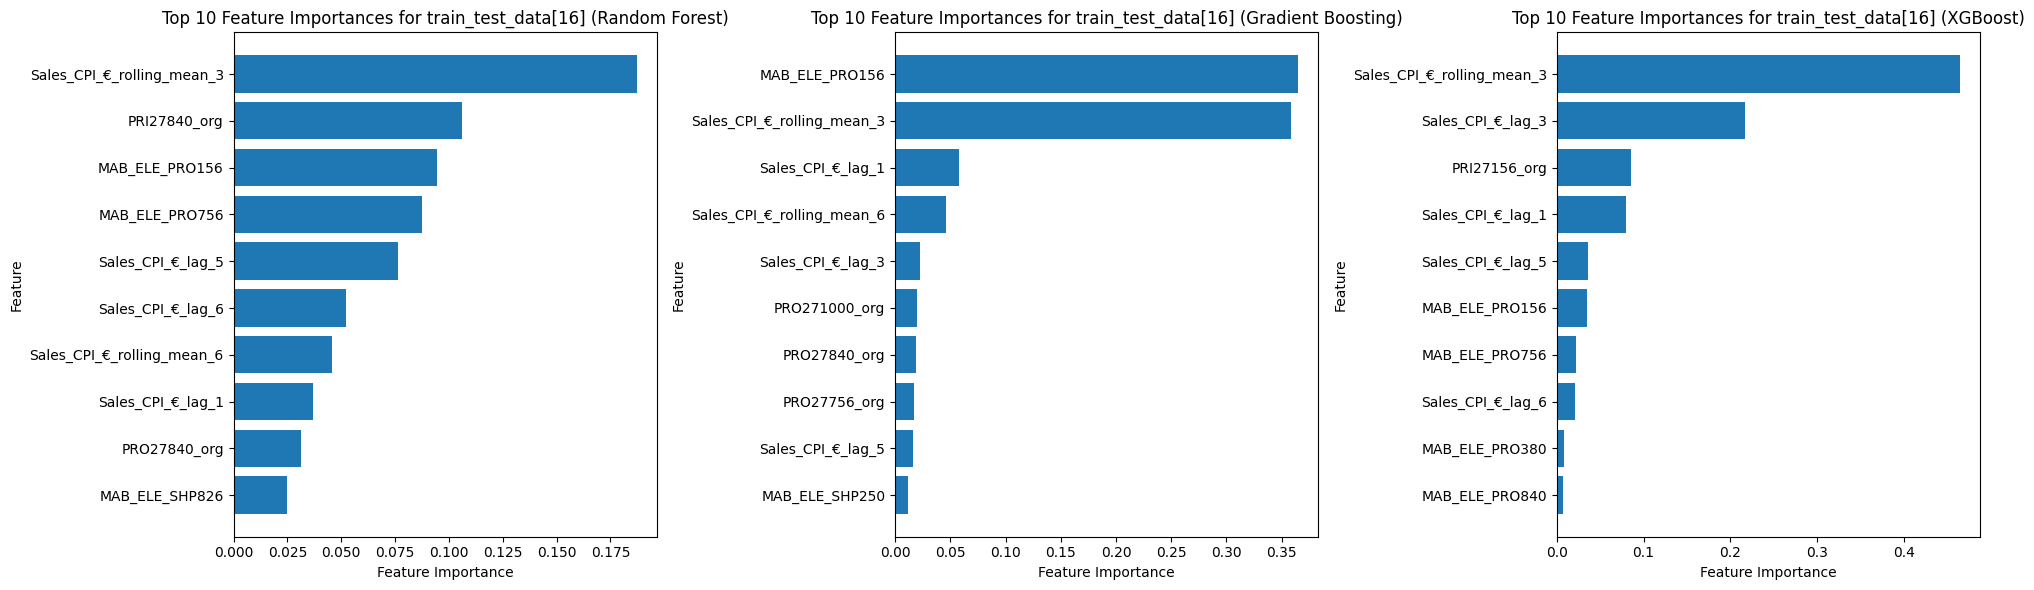

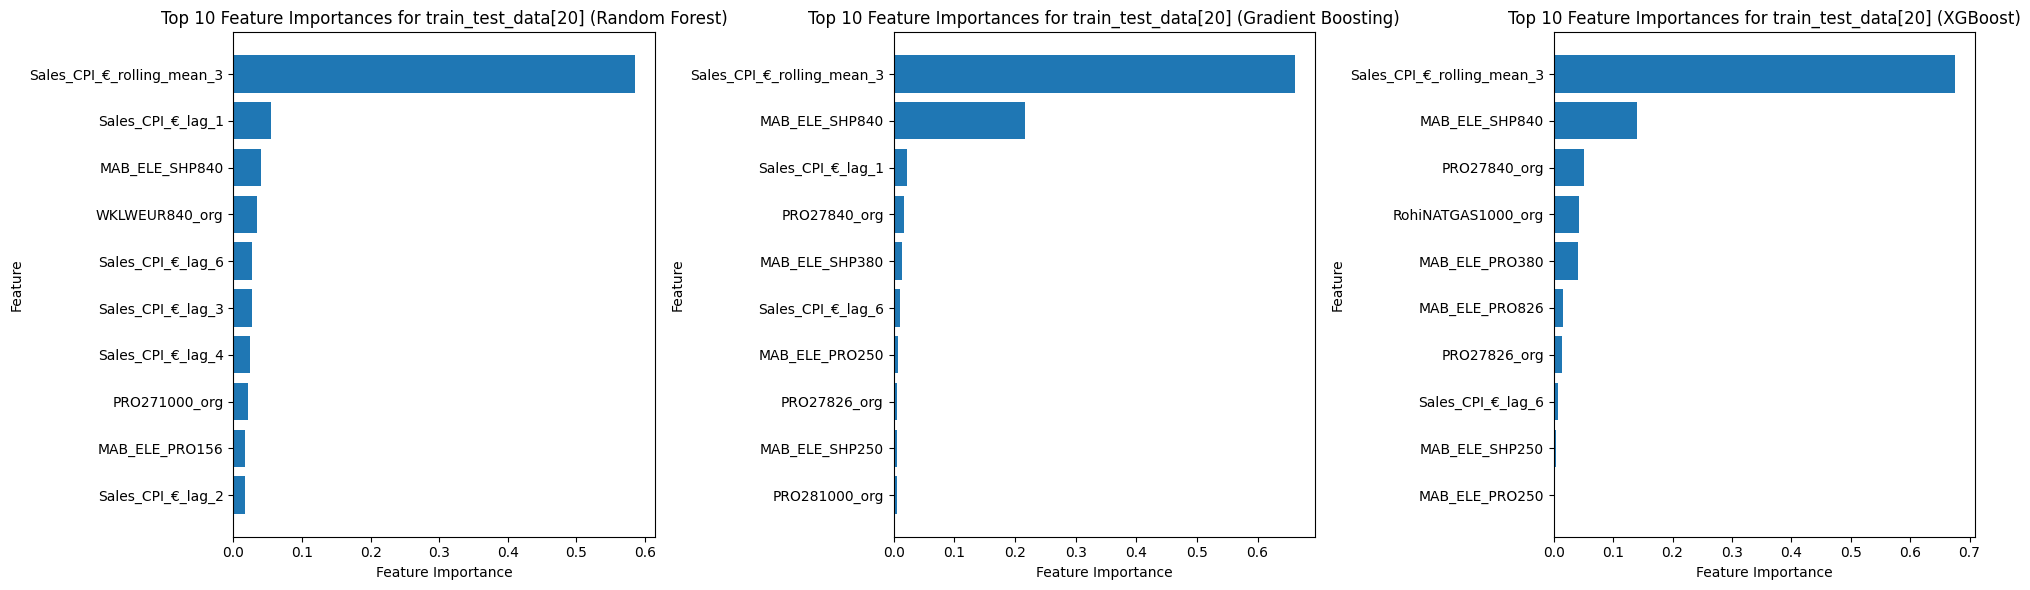

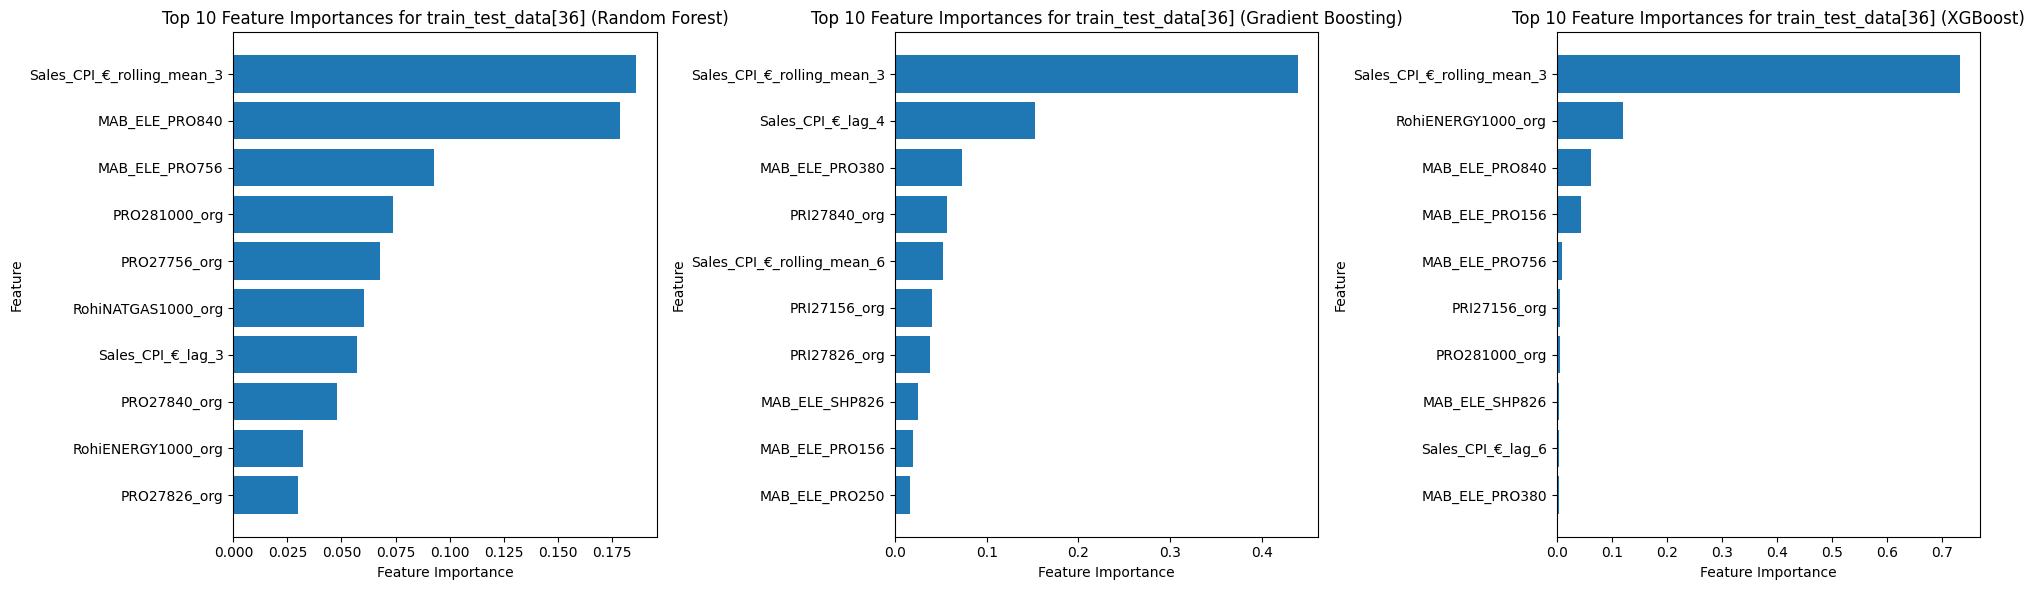

In [234]:
# Initialize Random Forest, Gradient Boosting, and XGBoost models
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Iterate over each DataFrame in train_test_data
for key, data in train_test_data.items():
    # Get the training data for lag features
    X_train = data['lag']['train'].drop(columns=['Sales_CPI_€'])
    y_train = data['lag']['train']['Sales_CPI_€']
    
    # Fit the models
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Get feature importances
    rf_importances = rf.feature_importances_
    gb_importances = gb.feature_importances_
    xgb_importances = xgb.feature_importances_
    
    # Sort and get indices of top 10 features for each model
    top_rf_indices = np.argsort(rf_importances)[::-1][:10]
    top_gb_indices = np.argsort(gb_importances)[::-1][:10]
    top_xgb_indices = np.argsort(xgb_importances)[::-1][:10]
    
    # Plot feature importances side by side for Random Forest, Gradient Boosting, and XGBoost
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Random Forest plot
    axes[0].barh(X_train.columns[top_rf_indices][::-1], rf_importances[top_rf_indices][::-1])
    axes[0].set_xlabel('Feature Importance')
    axes[0].set_ylabel('Feature')
    axes[0].set_title(f'Top 10 Feature Importances for train_test_data[{key}] (Random Forest)')
    
    # Gradient Boosting plot
    axes[1].barh(X_train.columns[top_gb_indices][::-1], gb_importances[top_gb_indices][::-1])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_ylabel('Feature')
    axes[1].set_title(f'Top 10 Feature Importances for train_test_data[{key}] (Gradient Boosting)')
    
    # XGBoost plot
    axes[2].barh(X_train.columns[top_xgb_indices][::-1], xgb_importances[top_xgb_indices][::-1])
    axes[2].set_xlabel('Feature Importance')
    axes[2].set_ylabel('Feature')
    axes[2].set_title(f'Top 10 Feature Importances for train_test_data[{key}] (XGBoost)')
    
    plt.tight_layout()
    plt.show()


Taking into account the 3 models above for the feature importance, it was decided that it should only be kept the top 5 common features for each lagged_dfs[x] based on their occurrences among the top features obtained from Random Forest, Gradient Boosting, and XGBoost models.

In [235]:
# Initialize an empty dictionary to store the occurrences of each feature for each product
product_feature_occurrences = {}

# Iterate over each DataFrame in train_test_data
for key, data in train_test_data.items():
    # Get the training data for the original and lag features
    X_train = data['lag']['train'].drop(columns=['Sales_CPI_€'])
    y_train = data['lag']['train']['Sales_CPI_€']
    
    # Fit the models
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Get feature importances
    rf_importances = rf.feature_importances_
    gb_importances = gb.feature_importances_
    xgb_importances = xgb.feature_importances_
    
    # Sort and get indices of top 10 features for each model
    top_rf_indices = np.argsort(rf_importances)[::-1][:10]
    top_gb_indices = np.argsort(gb_importances)[::-1][:10]
    top_xgb_indices = np.argsort(xgb_importances)[::-1][:10]
    
    # Combine top features from all models
    all_top_indices = np.concatenate([top_rf_indices, top_gb_indices, top_xgb_indices])
    
    # Count occurrences of each feature for the current product
    for idx in all_top_indices:
        feature_name = X_train.columns[idx]
        if key not in product_feature_occurrences:
            product_feature_occurrences[key] = {}
        product_feature_occurrences[key][feature_name] = product_feature_occurrences[key].get(feature_name, 0) + 1

# Initialize an empty dictionary to store the top common features for each product
top_common_features_per_product = {}

# Iterate over each product's feature occurrences
for product, feature_occurrences in product_feature_occurrences.items():
    # Sort features by their occurrences
    sorted_features = sorted(feature_occurrences.items(), key=lambda x: x[1], reverse=True)
    
    # Keep only the top 5 common features for the current product
    top_common_features_per_product[product] = [feat[0] for feat in sorted_features[:5]]

# Print the top common features for each product
for product, top_common_features in top_common_features_per_product.items():
    print(f"Top 5 common features for product {product}:")
    for feature in top_common_features:
        print(feature)
    print()


Top 5 common features for product 1:
MAB_ELE_PRO826
Sales_CPI_€_lag_3
Sales_CPI_€_lag_2
Sales_CPI_€_rolling_mean_3
WKLWEUR840_org

Top 5 common features for product 3:
WKLWEUR840_org
PRO27276_org
Sales_CPI_€_lag_1
PRO27826_org
Sales_CPI_€_rolling_mean_3

Top 5 common features for product 4:
Sales_CPI_€_rolling_mean_3
WKLWEUR840_org
Sales_CPI_€_lag_1
PRO27826_org
RohiNATGAS1000_org

Top 5 common features for product 5:
Sales_CPI_€_lag_3
RohiNATGAS1000_org
Sales_CPI_€_rolling_mean_3
Sales_CPI_€_lag_4
Sales_CPI_€_lag_6

Top 5 common features for product 6:
Sales_CPI_€_rolling_mean_3
MAB_ELE_SHP840
PRO27276_org
MAB_ELE_PRO392
Sales_CPI_€_lag_5

Top 5 common features for product 8:
Sales_CPI_€_rolling_mean_3
Sales_CPI_€_lag_6
WKLWEUR840_org
Sales_CPI_€_lag_3
PRO271000_org

Top 5 common features for product 9:
Sales_CPI_€_rolling_mean_3
PRO271000_org
PRO27826_org
MAB_ELE_SHP840
MAB_ELE_PRO250

Top 5 common features for product 11:
Sales_CPI_€_rolling_mean_3
MAB_ELE_SHP840
MAB_ELE_SHP250
PRI2

In [236]:
# Update each merged_df with only the common top features and 'Sales_CPI_€'
for number, data in train_test_data.items():
    # Extract common top features for the current merged_df
    common_top_features = top_common_features_per_product.get(number, [])
    
    # Add 'Sales_CPI_€' to the list of common top features
    common_top_features.append('Sales_CPI_€')
    
    # Update test set columns to keep only those present in the train set
    train_cols = data['lag']['train'][common_top_features].columns
    test_cols = data['lag']['test'].columns
    common_cols = train_cols.intersection(test_cols)
    train_test_data[number]['lag']['train'] = data['lag']['train'][common_cols]
    train_test_data[number]['lag']['test'] = data['lag']['test'][common_cols]


In [237]:
train_test_data[1]['lag']['train'].head()

MAB_ELE_PRO826  Sales_CPI_€_lag_3  Sales_CPI_€_lag_2  \
Date                                                               
2019-04-01      106.691164       2.709040e+07       3.413209e+07   
2019-05-01      109.719699       3.413209e+07       3.334895e+07   
2019-06-01      111.546958       3.334895e+07       3.945016e+07   
2019-07-01      110.593756       3.945016e+07       3.874238e+07   
2019-08-01      100.108825       3.874238e+07       3.906764e+07   

            Sales_CPI_€_rolling_mean_3  WKLWEUR840_org   Sales_CPI_€  
Date                                                                  
2019-04-01                3.564374e+07          1.1238  3.945016e+07  
2019-05-01                3.718050e+07          1.1185  3.874238e+07  
2019-06-01                3.908673e+07          1.1293  3.906764e+07  
2019-07-01                3.861211e+07          1.1218  3.802631e+07  
2019-08-01                3.840424e+07          1.1126  3.811876e+07

In [238]:
train_test_data[1]['lag']['test'].head()

MAB_ELE_PRO826  Sales_CPI_€_lag_3  Sales_CPI_€_lag_2  \
Date                                                               
2021-09-01      115.833771       3.683964e+07       3.839242e+07   
2021-10-01       99.135838       3.839242e+07       3.758170e+07   
2021-11-01      109.856972       3.758170e+07       3.765748e+07   
2021-12-01      101.273544       3.765748e+07       4.639578e+07   
2022-01-01       95.003541       4.639578e+07       3.572583e+07   

            Sales_CPI_€_rolling_mean_3  WKLWEUR840_org   Sales_CPI_€  
Date                                                                  
2021-09-01                3.787720e+07          1.1770  3.765748e+07  
2021-10-01                4.054499e+07          1.1601  4.639578e+07  
2021-11-01                3.992637e+07          1.1414  3.572583e+07  
2021-12-01                3.922244e+07          1.1304  3.554572e+07  
2022-01-01                3.706251e+07          1.1314  3.991598e+07

Save locally each df from lagged_dfs

In [239]:
# Create directories to save the DataFrames for train and test
train_output_dir = 'products_lag_train'
test_output_dir = 'products_lag_test'
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Iterate through train_test_data and save DataFrames for each train and test set
for number, data in train_test_data.items():
    # Define the filenames based on the key
    train_filename = os.path.join(train_output_dir, f'Product_{number}_train.csv')
    test_filename = os.path.join(test_output_dir, f'Product_{number}_test.csv')
    
    # Save the training and test DataFrames to CSV files
    data['lag']['train'].to_csv(train_filename, index=True)
    data['lag']['test'].to_csv(test_filename, index=True)
    
    print(f'Saved Product_{number}_train.csv and Product_{number}_test.csv')



Saved Product_1_train.csv and Product_1_test.csv
Saved Product_3_train.csv and Product_3_test.csv
Saved Product_4_train.csv and Product_4_test.csv
Saved Product_5_train.csv and Product_5_test.csv
Saved Product_6_train.csv and Product_6_test.csv
Saved Product_8_train.csv and Product_8_test.csv
Saved Product_9_train.csv and Product_9_test.csv
Saved Product_11_train.csv and Product_11_test.csv
Saved Product_12_train.csv and Product_12_test.csv
Saved Product_13_train.csv and Product_13_test.csv
Saved Product_14_train.csv and Product_14_test.csv
Saved Product_16_train.csv and Product_16_test.csv
Saved Product_20_train.csv and Product_20_test.csv
Saved Product_36_train.csv and Product_36_test.csv


# Outliers

Using **z-scores** for oulier detection, as it is an efficient statistical method for identifying data points that are unusually far from the mean.
This method **assumes that the data is normally distributed**, however if it not, the z-score method may not be the most appropriate and could either miss outliers or label non-ouliers incorrectly.

In [240]:
def detect_outliers(df, target_column):
    # Calculate z-score for the target column
    z_scores = (df[target_column] - df[target_column].mean()) / df[target_column].std()
    
    # Find outliers based on z-score threshold
    threshold = 3  # Adjust this threshold as needed
    outliers = np.abs(z_scores) > threshold
    
    return outliers

In [241]:
# Dictionary to store outliers for each product in the training data
train_outliers_dict = {}

# Loop through train_test_data to detect outliers for each product's training data
for product_id, data in train_test_data.items():
    # Get the training data for the current product
    train_data = data['original']['train']
    
    # Detect outliers for the current product's training data
    train_outliers = detect_outliers(train_data, target_column='Sales_CPI_€')
    
    # Store outliers for the current product in the dictionary
    train_outliers_dict[product_id] = train_outliers

# Print outliers for the training data of each product
for product_id, train_outliers in train_outliers_dict.items():
    print(f"Outliers for Product {product_id} in the training data:")
    print(train_outliers[train_outliers])  # Print rows containing outliers relative to Sales_CPI_€
    print()  # Add a newline for better readability between products


Outliers for Product 1 in the training data:
Date
2018-11-01    True
Name: Sales_CPI_€, dtype: bool

Outliers for Product 3 in the training data:
Date
2021-01-01    True
Name: Sales_CPI_€, dtype: bool

Outliers for Product 4 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 5 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 6 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 8 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 9 in the training data:
Date
2020-10-01    True
Name: Sales_CPI_€, dtype: bool

Outliers for Product 11 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 12 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 13 in the training data:
Series([], Name: Sales_CPI_€, dtype: bool)

Outliers for Product 14 in the training data:
Date
2019-06-01    True
2

In [242]:
def correct_outliers(df, target_column):
    # Detect outliers
    outliers = detect_outliers(df, target_column)

    # Interpolate outlier values
    df_corrected = df.copy()
    df_corrected[target_column][outliers] = np.nan  # Set outlier values to NaN
    df_corrected[target_column] = df_corrected[target_column].interpolate()  # Interpolate NaN values

    return df_corrected

# Dictionary to store corrected DataFrames for each product's training data
corrected_train_dfs = {}

# Loop through train_test_data to correct outliers for each product's training data
for product_id, data in train_test_data.items():
    # Get the training data for the current product
    train_data = data['original']['train']
    
    # Correct outliers for the current product's training data
    train_data_corrected = correct_outliers(train_data, target_column='Sales_CPI_€')

    # Store corrected training DataFrame for the current product in the dictionary
    corrected_train_dfs[product_id] = train_data_corrected

In [243]:
# Iterate through DataFrames in corrected_train_dfs[product_id]
for df_name, df in corrected_train_dfs.items():
    # Check if there are any NaN values in the current DataFrame
    if df.isna().any().any():
        print(f"DataFrame '{df_name}' in product {product_id} contains NaN values.")
    else:
        print(f"DataFrame '{df_name}' in product {product_id} does not contain any NaN values.")


DataFrame '1' in product 36 does not contain any NaN values.
DataFrame '3' in product 36 does not contain any NaN values.
DataFrame '4' in product 36 does not contain any NaN values.
DataFrame '5' in product 36 does not contain any NaN values.
DataFrame '6' in product 36 does not contain any NaN values.
DataFrame '8' in product 36 does not contain any NaN values.
DataFrame '9' in product 36 does not contain any NaN values.
DataFrame '11' in product 36 does not contain any NaN values.
DataFrame '12' in product 36 does not contain any NaN values.
DataFrame '13' in product 36 does not contain any NaN values.
DataFrame '14' in product 36 does not contain any NaN values.
DataFrame '16' in product 36 does not contain any NaN values.
DataFrame '20' in product 36 does not contain any NaN values.
DataFrame '36' in product 36 does not contain any NaN values.


In [244]:
# Define output directories for train and test DataFrames
train_output_dir = 'products_outliers_train'
test_output_dir = 'products_outliers_test'

# Create directories if they don't exist
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Iterate through corrected_train_dfs and train_test_data
for product_id, df_train in corrected_train_dfs.items():
    # Save corrected training DataFrame
    train_filename = os.path.join(train_output_dir, f'Product_{product_id}_train.csv')
    df_train.to_csv(train_filename, index=True)
    print(f'Saved Product_{product_id}_train.csv')
    
    # Save original test DataFrame
    df_test = train_test_data[product_id]['original']['test']
    test_filename = os.path.join(test_output_dir, f'Product_{product_id}_test.csv')
    df_test.to_csv(test_filename, index=True)
    print(f'Saved Product_{product_id}_test.csv')


Saved Product_1_train.csv
Saved Product_1_test.csv
Saved Product_3_train.csv
Saved Product_3_test.csv
Saved Product_4_train.csv
Saved Product_4_test.csv
Saved Product_5_train.csv
Saved Product_5_test.csv
Saved Product_6_train.csv
Saved Product_6_test.csv
Saved Product_8_train.csv
Saved Product_8_test.csv
Saved Product_9_train.csv
Saved Product_9_test.csv
Saved Product_11_train.csv
Saved Product_11_test.csv
Saved Product_12_train.csv
Saved Product_12_test.csv
Saved Product_13_train.csv
Saved Product_13_test.csv
Saved Product_14_train.csv
Saved Product_14_test.csv
Saved Product_16_train.csv
Saved Product_16_test.csv
Saved Product_20_train.csv
Saved Product_20_test.csv
Saved Product_36_train.csv
Saved Product_36_test.csv
